## Capstone Project - The Battle of Neighborhoods (Week 2)

### Applied Data Science Capstone by IBM/Coursera

### Identifying the similarities and dissimilarities between New York City and Toronto on Food, Arts & Entertainment and Nightlife 

### Table of contents of the Notebook
* [Introduction](#introduction)
* [Data Acquisition & Cleaning](#data)
* [Data Exploratory Analysis](#dataexploratoryanalysis)
    * [Food](#dataexploratoryanalysisfood)
    * [Arts & Entertainment](#dataexploratoryanalysisae)
    * [Nightlife Spot](#dataexploratoryanalysisns)
* [Results](#results)
* [Discussions](#discussions)
* [Conclusion](#conclusion)
* [Future Directions](#future)

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if geopy is not installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge kneed --yes # uncomment this line if kneed is not installed
#!pip install kneed # use this if conda causes any issues
from kneed import KneeLocator # Knee-point detection in Python

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium is not installed
import folium # map rendering library

#!conda install -c anaconda beautifulsoup4 # uncomment this line if beautifulsoup4 is not installed
from bs4 import BeautifulSoup # library used to scrape webpages
import requests # library used to make web requests
import csv # library used to read and write to csv files

from functools import reduce # library used for higher-order functions

from IPython.display import display_html

print('Libraries imported.')

Libraries imported.


### 1. Introduction <a name="introduction"></a>

This project seeks to identity the similarities or differences in Arts & Entertainment, Food and Nightlife between New York City and Toronto.

#### 1.1. Business Problem <a name="business_problem">

New Your City, USA and Toronto, CA are two of the most visited places by tourists. Moreover, they also offer various work opportunities, and are thus the cities where people from all around the world move to for a better life. 

Both tourists and those who plan to move to another city often look for places of enjoyment, social activities and entertainment before considering a city.  Although, Google and Question & Answer platforms such as [Quora](https://www.quora.com/) give you many options to explore and learn about a city, most of information is based on subjective knowledge of individuals who have travelled or moved to such places. 

While that is a good option to learn about a place, data driven information is a better way to inform yourself and also is more reliable. Keeping in mind that individuals who wish to travel or move to New York City or Toronto are unsure of which is the better place from enjoyment perspective, this project compares three categories between the two cities. These categories include Arts & Entertainment, Food and Nightlife.

Example of some of the questions the project seeks to answer:
1. How frequent Japanese Restaurants are in the neighborhoods of Toronto as compared to New York City?
2. If Museums play an important role in deciding which place to tour, then should you choose Toronto or New York City?
3. If Art Gallaries are your favourite place to explore in your free time, then would it matter much if you choose to visit New York City rather than Toronto?


#### 1.2 Target Audience

The target audience of this project is tourists and also the people who want to decide between the New York City and Toronto based on Food, Arts & Entertainment and Nightlife venues in the neighborhoods of the two cities.

### 2. Data Acquisition & Cleaning <a name="data"></a>

This section describes the data sourced for this project, as well as data cleaning and preparation for subsequent exploration.

#### 2.1. New York City Neighborhood Location Dataset

New York City has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Fortunately, this dataset exists for free on the web. Here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

It could also be downloaded from http://tiny.cc/n82g7y.
So let's go ahead and do that.

In [3]:
!wget -q -O 'newyork_city_neighborhood.json' http://tiny.cc/n82g7y
print('Data downloaded!')

Data downloaded!


Now that we've downloaded the json file, let's go ahead and save its json data in a variable *newyork_json* for further analysis.

In [4]:
with open('newyork_city_neighborhood.json') as json_data:
    newyork_json = json.load(json_data)

All the relevant data in *newyork_json* is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data and take a look at its first item in the list.

In [5]:
newyork_neighborhoods_data = newyork_json['features']
newyork_neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Next, we're going to transform the *newyork_neighborhoods_data* data of nested Python dictionaries into a pandas dataframe. We'll need 'Borough', 'Neighborhood', 'Latitude' and 'Longitude' data.  So let's start by creating an empty dataframe. 

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_newyork_neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [7]:
df_newyork_neighborhoods

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

Then let's loop through the data and fill the dataframe one row at a time.

In [8]:
for data in newyork_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_newyork_neighborhoods = df_newyork_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [9]:
df_newyork_neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [10]:
print("The shape of df_newyork_neighborhoods is", df_newyork_neighborhoods.shape)

The shape of df_newyork_neighborhoods is (306, 4)


And make sure that the dataset has all 5 boroughs and 306 unique neighborhoods.

In [11]:
print('The New York City dataframe has {} boroughs and {} neighborhoods.'.format(
        len(set(df_newyork_neighborhoods['Borough'])),
        df_newyork_neighborhoods.shape[0]
    )
)

The New York City dataframe has 5 boroughs and 306 neighborhoods.


Now let's take a look at the number of neighborhoods in each borough.

In [12]:
df_newyork_neighborhoods['Borough'].value_counts()

Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: Borough, dtype: int64

Let's find the number of unique New York City neighborhoods *before* filtering (by 'Food' or any other Venue Category)

In [13]:
newyork_neighborhoods_before = df_newyork_neighborhoods['Neighborhood'].unique()
len(newyork_neighborhoods_before)

302

The shape of is <code>df_newyork_neighborhoods.shape[0]</code> is **306** but the number of unique neighborhoods is **302**. 
It means that **4** neighborhoods in <code>df_newyork_neighborhoods</code> are duplicates. Let's find out the duplicate neighborhoods.

In [14]:
df_newyork_neighborhoods[df_newyork_neighborhoods.duplicated(['Neighborhood'], keep=False)]

Borough Neighborhood   Latitude  Longitude
115      Manhattan  Murray Hill  40.748303 -73.978332
116      Manhattan      Chelsea  40.744035 -74.003116
140         Queens    Sunnyside  40.740176 -73.926916
175         Queens  Bay Terrace  40.782843 -73.776802
180         Queens  Murray Hill  40.764126 -73.812763
220  Staten Island    Sunnyside  40.612760 -74.097126
235  Staten Island  Bay Terrace  40.553988 -74.139166
244  Staten Island      Chelsea  40.594726 -74.189560

As we can see from above dataset that all the 4 duplicate neighborhoods ('Murray Hill', 'Chelsea', 'Sunnyside', 'Bay Terrace') are found in two different boroughs. It means that 4 neighborhoods of the same name are found in 2 different boroughs. But they all have different (Latitude, Longitude) values. 

According to Wikipedia at https://en.wikipedia.org/wiki/Murray_Hill, 'Murray Hill' neighborhood is not only found in Manhattan and Queens, but a few other places as well. So we're going to keep 'Murray Hill' and other 3 neighborhoods as well in the <code>df_newyork_neighborhoods</code> dataframe.

Now, let's save this dataframe for later use to a *csv* file using <code>to_csv</code> method.

In [15]:
df_newyork_neighborhoods.to_csv('df_newyork_neighborhoods.csv', index = False)

#### 2.2. Toronto Neighborhood Location Dataset

We first scrape and then parse the data of the table from <a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M">List of postal codes of Canada: M</a> and then iterate over it to create an array of table rows.

In [16]:
# scraping and parsing the data from the Wikipedia page
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(page, 'lxml')
table = soup.find('table', class_=['wikitable'])

table_rows = []
for table_row in table.findAll('tr'):    
    columns = table_row.findAll('td')
    table_row = []
    for column in columns:
        table_row.append(column.text.rstrip())
    table_rows.append(table_row)
    
header_row = []
for table_head in table.findAll('th'):
    header_row.append(table_head.text.rstrip())    
table_rows[0] = header_row

# Writing table into a CSV file
with open('postalcodes_toronto.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(table_rows)

Next, we load the data and clean it by dropping the cells where the value of *Borough* is *Not assigned*. We then transform a cell that has a *Borough* but a *Not assigned* *Neighborhood*, that *Neighborhood* is assigned the same value as *Borough*. For every duplicate *PostalCode* we concatenate its *Neighborhood* values by separating them with a *,* (comma). We do it by grouping the data by PostalCode and Borough.

In [17]:
# Reading data from 'postalcodes_canada.csv'
df_postalcodes_toronto = pd.read_csv('postalcodes_toronto.csv')

# Renaming the columns of the dataframe
df_postalcodes_toronto.columns = ['PostalCode', 'Borough', 'Neighborhood']

# Droping the cells where the value of 'Borough' is 'Not assigned'
df_postalcodes_toronto = df_postalcodes_toronto.drop(df_postalcodes_toronto[df_postalcodes_toronto['Borough'] == 'Not assigned'].index)

# Assigning 'Neighborhood' the same value as 'Borough' if the value of 'Neighborhood' is 'Not assigned'
df_postalcodes_toronto.loc[df_postalcodes_toronto['Neighborhood'] == 'Not assigned', ['Neighborhood']] = df_postalcodes_toronto['Borough']

# Concatenating 'Neighborhood' values for every duplicate 'PostalCode'
# df_postalcodes_toronto = df_postalcodes_toronto.groupby(['PostalCode', 'Borough'], sort=False).agg({'Neighborhood': ', '.join}).reset_index()


Now let's take a look at the head of <code>df_postalcodes_toronto</code>

In [18]:
df_postalcodes_toronto.head()

PostalCode           Borough      Neighborhood
2        M3A        North York         Parkwoods
3        M4A        North York  Victoria Village
4        M5A  Downtown Toronto      Harbourfront
5        M5A  Downtown Toronto       Regent Park
6        M6A        North York  Lawrence Heights

In [19]:
print("The shape of 'df_postalcodes_toronto' is", df_postalcodes_toronto.shape)

The shape of 'df_postalcodes_toronto' is (211, 3)


Now that we've have built a dataframe of the PostalCode of each Neighborhood along with the Borough, next we will get the latitude and longitude coordinates of each Neighborhood.

We'll use a csv file at http://tiny.cc/od8m7y that has the geographical coordinates of each PostalCode.

In [20]:
# Generating dataframe by reading the Geospatial CSV file and then naming columns
df_geo_coords = pd.read_csv('http://cocl.us/Geospatial_data')
df_geo_coords.columns = ['PostalCode', 'Latitude', 'Longitude']

# Merging the PostalCodes dataframe with the Geospatial dataframe by creating an inner join on 'PostalCode'
df_postalcodes_toronto = pd.merge(df_postalcodes_toronto, df_geo_coords, on=['PostalCode'], how='inner')

# Dropping the 'PostalCode' column as we'll not need it anymore
df_postalcodes_toronto = df_postalcodes_toronto.drop(['PostalCode'], axis=1)

Now let's take a look at the head of <code>df_postalcodes_toronto</code> again.

In [21]:
df_postalcodes_toronto.head()

Borough      Neighborhood   Latitude  Longitude
0        North York         Parkwoods  43.753259 -79.329656
1        North York  Victoria Village  43.725882 -79.315572
2  Downtown Toronto      Harbourfront  43.654260 -79.360636
3  Downtown Toronto       Regent Park  43.654260 -79.360636
4        North York  Lawrence Heights  43.718518 -79.464763

The geographical coordinates of each PostalCode seems to have been added to the dataframe correctly. Now, let's confirm that the shape of the <code>df_postalcodes_toronto</code> is still (211, 4). 

In [22]:
df_postalcodes_toronto.shape

(211, 4)

In [23]:
print('The Toronto dataframe has {} boroughs and {} neighborhoods.'.format(
        len(set(df_postalcodes_toronto['Borough'])),
        df_postalcodes_toronto.shape[0]
    )
)

The Toronto dataframe has 11 boroughs and 211 neighborhoods.


Now let's take a look at the number neighborhoods in each borough.

In [24]:
df_postalcodes_toronto['Borough'].value_counts()

Etobicoke           45
North York          38
Downtown Toronto    37
Scarborough         37
Central Toronto     17
West Toronto        13
York                 9
East Toronto         7
East York            6
Mississauga          1
Queen's Park         1
Name: Borough, dtype: int64

Now let's find the number of neighborhoods before filtering (by 'Food' or any other Venue Category)

In [25]:
toronto_neighborhoods_before = df_postalcodes_toronto['Neighborhood'].unique()
len(toronto_neighborhoods_before)

209

The shape of is <code>df_postalcodes_toronto.shape[0]</code> is **211** but the number of unique neighborhoods is **209**. 
It means that **2** neighborhoods in <code>df_newyork_neighborhoods</code> are duplicates. Let's find out the duplicate neighborhoods.

In [26]:
df_postalcodes_toronto[df_postalcodes_toronto.duplicated(['Neighborhood'], keep=False)]

Borough    Neighborhood   Latitude  Longitude
27   Downtown Toronto  St. James Town  43.651494 -79.375418
115              York       Runnymede  43.673185 -79.487262
145      West Toronto       Runnymede  43.651571 -79.484450
190  Downtown Toronto  St. James Town  43.667967 -79.367675

As we can see from above dataset that the 2 duplicate neighborhoods ('St. James Town', 'Runnymede') are found in the same boroughs. But only **St. James Town** has the same Borough as **Runnymede** has two different boroughs. So we're going to remove only **St. James Town** neighborhood at index 27 from our Toronto dataset.

In [27]:
df_postalcodes_toronto = df_postalcodes_toronto.drop(df_postalcodes_toronto.index[[27]]).reset_index(drop=True)
df_postalcodes_toronto.shape

(210, 4)

Let's save the resulting dataframe to a CSV file for using it later or in any other notebooks.

In [28]:
df_postalcodes_toronto.to_csv('df_postalcodes_toronto.csv', index = False)

#### 2.3. Places API of Foursquare

The above mentioned New York City and Toronto datasets will be used in conjunction with the [Foursquare Developer API](https://developer.foursquare.com/) for this project. 

Using the **Places API** Endpoints of Foursquare Developer API for different categories like Food, Arts & Entertainment and Nightlife Spot, we find the frequency of the venues of each of these categories and the similarities or differences in them for both the cities.

For example, by using the **explore** API endpoint along with the **categoryId** of the Food venue category we get the nearby venues of the provided location filtered by the Food venue category.


### 3. Exploratory Data Analysis <a name="dataexploratoryanalysis"></a>

Before start exploring the Toronto and New York City we need to define the Foursquare credentials and version as Foursquare API is what we'll be utilizing to explore the neighborhoods of the cities.

In [4]:
CLIENT_ID = 'YOUR_FOURSQUARE_CLIENT_ID' # your Foursquare ID
CLIENT_SECRET = 'YOUR_FOURSQUARE_CLIENT_SECRET' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

Now we'll create a function that will get nearby venues of all the neighborhoods in the dataframe.

In [30]:
def getNearbyVenues(names, latitudes, longitudes, categoryId, radius=1000):
    
    venues_list=[]
    names_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            categoryId,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])  
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']    
    
    return(nearby_venues)

We'll use a simple utility function <code>display_side_by_side</code> to display our dataframes inline whenever needed.

In [31]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

#### 3.1 Exploring Food Venue Categories of Toronto and New York City <a name="dataexploratoryanalysisfood"></a>

We'll now explore the neighborhoods try to identify the most common *Food* venue categories in 'Toronto, Canada' and 'New York City, USA'.

Let's start with **Toronto**.

In [32]:
# creating a new dataframe for all the Toronto Food venue categories using the <code>getNearbyVenues</code> funtion
toronto_venues_food = getNearbyVenues(names=df_postalcodes_toronto['Neighborhood'],
                                 latitudes=df_postalcodes_toronto['Latitude'],
                                 longitudes=df_postalcodes_toronto['Longitude'],
                                 categoryId='4d4b7105d754a06374d81259' # categoryId of 'Food'
                                )

# let's save the dataframe to a .csv file for later use.
toronto_venues_food.to_csv('toronto_venues_food.csv', index=False)

In [33]:
toronto_venues_food = pd.read_csv('toronto_venues_food.csv')

Let's check the size of the resulting Toronto dataframe

In [34]:
print(toronto_venues_food.shape)
toronto_venues_food.head()

(6984, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Parkwoods              43.753259              -79.329656   
1    Parkwoods              43.753259              -79.329656   
2    Parkwoods              43.753259              -79.329656   
3    Parkwoods              43.753259              -79.329656   
4    Parkwoods              43.753259              -79.329656   

                      Venue  Venue Latitude  Venue Longitude  \
0           Allwyn's Bakery       43.759840       -79.324719   
1               Tim Hortons       43.760668       -79.326368   
2                A&W Canada       43.760643       -79.326865   
3  High Street Fish & Chips       43.745260       -79.324949   
4               Pizza Pizza       43.760231       -79.325666   

         Venue Category  
0  Caribbean Restaurant  
1                  Café  
2  Fast Food Restaurant  
3     Fish & Chips Shop  
4           Pizza Place

##### 3.1.T.1 Neighborhoods Without Any Food Venues in Toronto

Let's find number of neighborhoods in Toronto after filtering (by 'Food' Venue Category)

In [35]:
toronto_neighborhoods_food_after = toronto_venues_food['Neighborhood'].unique()
len(toronto_neighborhoods_food_after)

207

In [36]:
"Number of unique neighborhoods in Toronto before being filtered by Food venue categories was {} but after fitering it has come down to {}. Let us find out the {} neighborhoods that do not have any Food venues around them.".format(len(toronto_neighborhoods_before), len(toronto_neighborhoods_food_after), len(toronto_neighborhoods_before) - len(toronto_neighborhoods_food_after) )

'Number of unique neighborhoods in Toronto before being filtered by Food venue categories was 209 but after fitering it has come down to 207. Let us find out the 2 neighborhoods that do not have any Food venues around them.'

In [37]:
# Toronto neighborhoods that do not have any Food venues within 500 meters around them
toronto_neighborhoods_with_no_food = np.setdiff1d(toronto_neighborhoods_before, toronto_neighborhoods_food_after)
toronto_neighborhoods_with_no_food

array(['Northwest', 'Upper Rouge'], dtype=object)

In [38]:
# neighborhoors with no Food venues within 500 meters around them
df_postalcodes_toronto[df_postalcodes_toronto['Neighborhood'].isin(toronto_neighborhoods_with_no_food)]

Borough Neighborhood   Latitude  Longitude
186    Etobicoke    Northwest  43.706748 -79.594054
187  Scarborough  Upper Rouge  43.836125 -79.205636

In [39]:
# indices of Toronto neighborhoors with no Food venues within 1000 meters around them
toronto_neighborhoods_with_no_food_indices = df_postalcodes_toronto[df_postalcodes_toronto['Neighborhood'].isin(toronto_neighborhoods_with_no_food)].index.values
toronto_neighborhoods_with_no_food_indices

array([186, 187])

Let's find out how many unique categories can be curated from all the returned venues.

In [40]:
print('There are {} unique food venue categories.'.format(len(toronto_venues_food['Venue Category'].unique())))

There are 109 unique food venue categories.


In [41]:
"Now let's find out what are the most common {} Food venue categories in Toronto.".format(len(toronto_venues_food['Venue Category'].unique()))

"Now let's find out what are the most common 109 Food venue categories in Toronto."

##### 3.1.T.2 Count of Food Venues by Neighborhood and Food Venue Category in Toronto

Let's create a dataframe for count of Toronto venues by neighborhood and Food venue category

In [42]:
toronto_venues_food_freq_by_neighborhood_and_food_vc = toronto_venues_food.groupby(['Neighborhood', 'Venue Category'])['Venue Category'].count().reset_index(name="Count")
toronto_venues_food_freq_by_neighborhood_and_food_vc = toronto_venues_food_freq_by_neighborhood_and_food_vc.rename(columns = {"Venue Category": "Food Venue Category"}) 
toronto_venues_food_freq_by_neighborhood_and_food_vc.head()

Neighborhood   Food Venue Category  Count
0     Adelaide   American Restaurant      4
1     Adelaide      Asian Restaurant      2
2     Adelaide                Bakery      3
3     Adelaide  Brazilian Restaurant      1
4     Adelaide        Breakfast Spot      4

##### 3.1.T.3 Count of Food Venues in each Borough of Toronto

Let's now find count of the Food Venues in each Borough of Toronto. But to do that we need to add the borough of each neighborhood in our dataframe first.

In [43]:
# joining 'toronto_venues_food_freq_by_neighborhood_and_food_vc' with 'df_postalcodes_toronto' to add 'Borough' in the dataframe
df_toronto_venues_food_freq_by_borough = toronto_venues_food_freq_by_neighborhood_and_food_vc.join(df_postalcodes_toronto.set_index('Neighborhood'), on='Neighborhood')
df_toronto_venues_food_freq_by_borough.head()

Neighborhood   Food Venue Category  Count           Borough   Latitude  \
0     Adelaide   American Restaurant      4  Downtown Toronto  43.650571   
1     Adelaide      Asian Restaurant      2  Downtown Toronto  43.650571   
2     Adelaide                Bakery      3  Downtown Toronto  43.650571   
3     Adelaide  Brazilian Restaurant      1  Downtown Toronto  43.650571   
4     Adelaide        Breakfast Spot      4  Downtown Toronto  43.650571   

   Longitude  
0 -79.384568  
1 -79.384568  
2 -79.384568  
3 -79.384568  
4 -79.384568

In [44]:
# showing the 'Count of Food Venues' for each 'Borough'
toronto_venues_food_freq_by_borough = df_toronto_venues_food_freq_by_borough.groupby(['Borough'])['Food Venue Category'].count().reset_index(name="Food Venues")
toronto_venues_food_freq_by_borough = toronto_venues_food_freq_by_borough.sort_values(by='Food Venues', ascending=False)
toronto_venues_food_freq_by_borough

Borough  Food Venues
1   Downtown Toronto         1093
0    Central Toronto          455
9       West Toronto          397
6         North York          369
4          Etobicoke          358
8        Scarborough          342
2       East Toronto          202
10              York           91
3          East York           80
7       Queen's Park           39
5        Mississauga           24

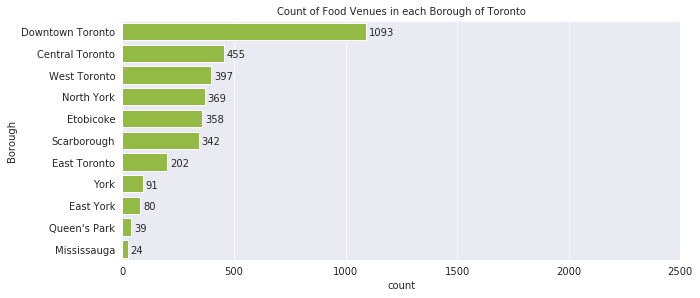

In [45]:
fig = plt.figure(figsize=(10, 4.4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Borough", x="Food Venues", data=toronto_venues_food_freq_by_borough, color="yellowgreen")
ax.set_xlim(0, 2500)
plt.title("Count of Food Venues in each Borough of Toronto", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Borough")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('toronto_venues_food_count_by_borough.png', bbox_inches = 'tight')
plt.show()

##### 3.1.T.4 Count of Food Venues in Each Neighborhood of Toronto

Let's create a dataframe for Toronto Food venues by neighborhood

In [46]:
toronto_venues_food_freq_by_neighborhood = toronto_venues_food.groupby(['Neighborhood'])['Venue Category'].count().reset_index(name='Food Venues')
toronto_venues_food_freq_by_neighborhood = toronto_venues_food_freq_by_neighborhood.sort_values(by='Food Venues', ascending=False)
toronto_venues_food_freq_by_neighborhood.head()

Neighborhood  Food Venues
0                Adelaide          100
133          Queen's Park          100
36        Design Exchange          100
54   First Canadian Place          100
59        Garden District          100

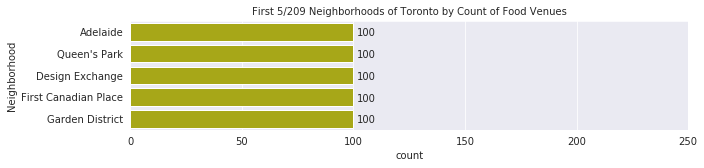

In [47]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Neighborhood", x="Food Venues", data=toronto_venues_food_freq_by_neighborhood.head(5), color="y")
ax.set_xlim(0, 250)
plt.title("First 5/209 Neighborhoods of Toronto by Count of Food Venues", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Neighborhood")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('toronto_venues_food_freq_by_neighborhood_first_5.png', bbox_inches = 'tight')
plt.show()

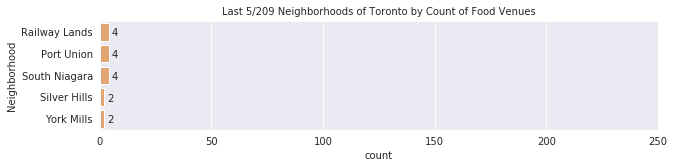

In [48]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Neighborhood", x="Food Venues", data=toronto_venues_food_freq_by_neighborhood.tail(5), color="sandybrown")
ax.set_xlim(0, 250)
plt.title("Last 5/209 Neighborhoods of Toronto by Count of Food Venues", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Neighborhood")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('toronto_venues_food_freq_by_neighborhood_last_5.png', bbox_inches = 'tight')
plt.show()

The maximum number of venues returned by Foursquare API is 100. 
So if a neighborhood has more than 100 Food Venues within 1000 meters then it will not be included in the above result.
This is one of the limitation in the analysis of neighborhood data at the moment. 
So the final analysis will have a slight margin or error.

##### 3.1.T.5 Count of Food Venues of Each Food Venue Category in Toronto

In [49]:
toronto_venues_food_vc = toronto_venues_food['Venue Category'].value_counts().to_frame(name='Count').reset_index()
toronto_venues_food_vc = toronto_venues_food_vc.rename(columns = {"index": "Food Venue Category"}) 
toronto_venues_food_vc.head()

Food Venue Category  Count
0                Café    602
1         Pizza Place    508
2          Restaurant    397
3  Italian Restaurant    395
4      Sandwich Place    307

We could see that the count of *Food* venue category found in the neighborhoods of Toronto is maximum for **Café**. 
**Pizza** places are also very frequent, then comes the **Italian** restaurants.

We have a 'Restaurant' Venue Category as well on 3rd position, but that seems to be the kind of restaurant where all the different kinds of cuisines are served.

Let's create a simple bar plot of the count of 'Food' venue categories  in *Toronto*.

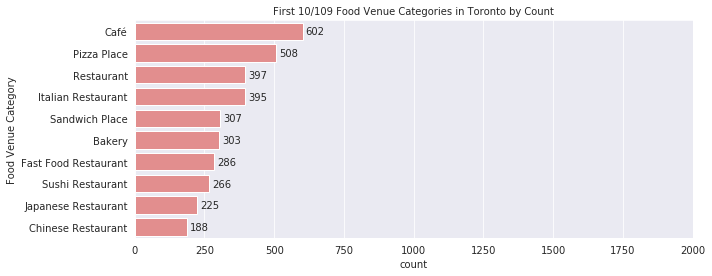

In [50]:
fig = plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Food Venue Category", x="Count", data=toronto_venues_food_vc.head(10), color="lightcoral")
ax.set_xlim(0, 2000)
plt.title("First 10/109 Food Venue Categories in Toronto by Count", fontsize="medium")
plt.xlabel("count")
plt.ylabel ("Food Venue Category")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')

fig.savefig('toronto_venues_food_vc_head_10.png', bbox_inches = 'tight')
plt.show()

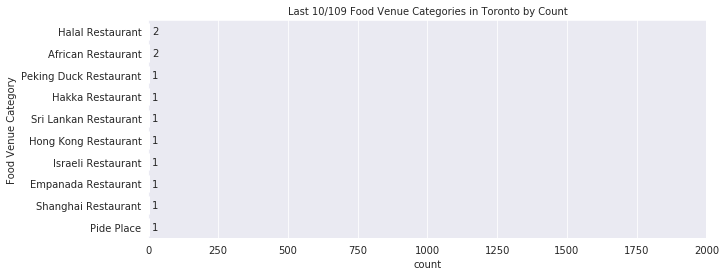

In [51]:
fig = plt.figure(figsize=(10,4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Food Venue Category", x="Count", data=toronto_venues_food_vc.tail(10), color="blue")
ax.set_xlim(0, 2000)
plt.title("Last 10/109 Food Venue Categories in Toronto by Count", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Food Venue Category")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')
    
fig.savefig('toronto_venues_food_vc_tail_10.png', bbox_inches = 'tight')
plt.show()

Now let's move on to the **New York City** and find out the most common *Food* Venue Category found there.

In [52]:
# creating a new dataframe for all the New York City Food venue categories using the <code>getNearbyVenues</code> funtion
newyork_venues_food = getNearbyVenues(names=df_newyork_neighborhoods['Neighborhood'],
                                 latitudes=df_newyork_neighborhoods['Latitude'],
                                 longitudes=df_newyork_neighborhoods['Longitude'],
                                 categoryId='4d4b7105d754a06374d81259' # categoryId of 'Food'
                                )

# let's save the dataframe to a .csv file for later use
newyork_venues_food.to_csv('newyork_venues_food.csv', index=False)

In [53]:
newyork_venues_food = pd.read_csv('newyork_venues_food.csv')

Let's check the size of the resulting New York City dataframe.

In [54]:
print(newyork_venues_food.shape)
newyork_venues_food.head()

(17971, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

                                     Venue  Venue Latitude  Venue Longitude  \
0                       Ripe Kitchen & Bar       40.898152       -73.838875   
1                          Ali's Roti Shop       40.894036       -73.856935   
2              Jackie's West Indian Bakery       40.889283       -73.843310   
3                                  Jimbo's       40.891740       -73.858226   
4  Cooler Runnings Jamaican Restaurant Inc       40.898276       -73.850381   

         Venue Category  
0  Caribbean Restaurant  
1  Caribbean Restaurant  
2  Caribbean Restaurant  
3          Burger Joint  
4  Caribbean Restaurant

##### 3.1.N.1 Neighborhoods Without Any Food Venues in New York City

Let's find number of neighborhoods in New York City after filtering (by 'Food' Venue Category)

In [55]:
newyork_neighborhoods_food_after = newyork_venues_food['Neighborhood'].unique()
len(newyork_neighborhoods_food_after)

302

In [56]:
"Number of unique neighborhoods in New York City before being filtered by Food venue categories was {} but after fitering it has come down to {}. Let us find out the {} neighborhoods that do not have any Food venues around them.".format(len(newyork_neighborhoods_before), len(newyork_neighborhoods_food_after), len(newyork_neighborhoods_before) - len(newyork_neighborhoods_food_after) )

'Number of unique neighborhoods in New York City before being filtered by Food venue categories was 302 but after fitering it has come down to 302. Let us find out the 0 neighborhoods that do not have any Food venues around them.'

In [57]:
# New York City neighborhoods that do not have any Food venues
newyork_neighborhoods_with_no_food = np.setdiff1d(newyork_neighborhoods_before, newyork_neighborhoods_food_after)
newyork_neighborhoods_with_no_food

array([], dtype=object)

In [58]:
# neighborhoors with no Food venues around them
df_newyork_neighborhoods[df_newyork_neighborhoods['Neighborhood'].isin(newyork_neighborhoods_with_no_food)]

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

In [59]:
# indices of New York City neighborhoors with no Food venues within 500 meters around them
newyork_neighborhoods_with_no_food_indices = df_newyork_neighborhoods[df_newyork_neighborhoods['Neighborhood'].isin(newyork_neighborhoods_with_no_food)].index.values
newyork_neighborhoods_with_no_food_indices

array([], dtype=int64)

Let's find out how many unique categories can be curated from all the returned venues.

In [60]:
print('There are {} unique food venue categories.'.format(len(newyork_venues_food['Venue Category'].unique())))

There are 142 unique food venue categories.


In [61]:
"Now let's find out what are the most common {} Food venue categories in New York City.".format(len(newyork_venues_food['Venue Category'].unique()))

"Now let's find out what are the most common 142 Food venue categories in New York City."

##### 3.1.N.2 Count of Food Venues by Neighborhood and Food Venue Category in New York City 

Let's create a dataframe for count of New York City venues by neighborhood and Food venue category

In [62]:
newyork_venues_food_freq_by_neighborhood_and_food_vc = newyork_venues_food.groupby(['Neighborhood', 'Venue Category'])['Venue Category'].count().reset_index(name="Count")
newyork_venues_food_freq_by_neighborhood_and_food_vc = newyork_venues_food_freq_by_neighborhood_and_food_vc.rename(columns = {"Venue Category": "Food Venue Category"}) 
newyork_venues_food_freq_by_neighborhood_and_food_vc.head(5)

Neighborhood   Food Venue Category  Count
0     Allerton   American Restaurant      2
1     Allerton                Bakery      2
2     Allerton        Breakfast Spot      1
3     Allerton  Caribbean Restaurant      4
4     Allerton    Chinese Restaurant      8

##### 3.1.N.3 Count of Food Venues in each Borough of New York City

Let's now find count of the Food Venues in each Borough of New York City. But to do that we need to add the borough of each neighborhood in our dataframe first.


In [63]:
# joining 'newyork_venues_food_freq_by_neighborhood_and_food_vc' with 'df_newyork_neighborhoods' to add 'Borough' in the dataframe
df_newyork_venues_food_freq_by_borough = newyork_venues_food_freq_by_neighborhood_and_food_vc.join(df_newyork_neighborhoods.set_index('Neighborhood'), on='Neighborhood')
df_newyork_venues_food_freq_by_borough.head(5)

Neighborhood   Food Venue Category  Count Borough   Latitude  Longitude
0     Allerton   American Restaurant      2   Bronx  40.865788 -73.859319
1     Allerton                Bakery      2   Bronx  40.865788 -73.859319
2     Allerton        Breakfast Spot      1   Bronx  40.865788 -73.859319
3     Allerton  Caribbean Restaurant      4   Bronx  40.865788 -73.859319
4     Allerton    Chinese Restaurant      8   Bronx  40.865788 -73.859319

In [64]:
# showing the 'Count of Food Venues' for each 'Borough' in New York City
newyork_venues_food_freq_by_borough = df_newyork_venues_food_freq_by_borough.groupby(['Borough'])['Food Venue Category'].count().reset_index(name="Food Venues")
newyork_venues_food_freq_by_borough = newyork_venues_food_freq_by_borough.sort_values(by='Food Venues', ascending=False)
newyork_venues_food_freq_by_borough

Borough  Food Venues
1       Brooklyn         1939
3         Queens         1882
2      Manhattan         1575
0          Bronx         1028
4  Staten Island          978

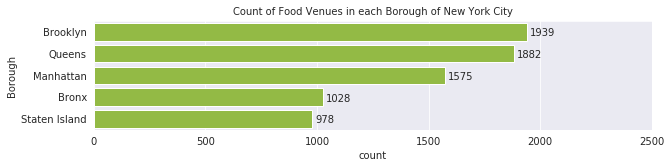

In [65]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Borough", x="Food Venues", data=newyork_venues_food_freq_by_borough, color='yellowgreen')
ax.set_xlim(0, 2500)
plt.title("Count of Food Venues in each Borough of New York City", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Borough")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('newyork_venues_food_count_by_borough.png', bbox_inches = 'tight')
plt.show()

##### 3.1.N.4 Count of Food Venues in Each Neighborhood of  New York City 

Let's create a dataframe for the count of New York City Food venues by neighborhood

In [66]:
newyork_venues_food_freq_by_neighborhood = newyork_venues_food.groupby(['Neighborhood'])['Venue Category'].count().reset_index(name='Food Venues')
newyork_venues_food_freq_by_neighborhood = newyork_venues_food_freq_by_neighborhood.sort_values(by='Food Venues', ascending=False)
newyork_venues_food_freq_by_neighborhood.head()

Neighborhood  Food Venues
186   Murray Hill          200
49        Chelsea          115
264     Sunnyside          105
151    Lenox Hill          100
135  Hudson Yards          100

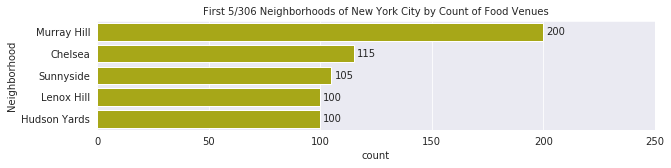

In [67]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Neighborhood", x="Food Venues", data=newyork_venues_food_freq_by_neighborhood.head(5), color="y")
ax.set_xlim(0, 250)
plt.title("First 5/306 Neighborhoods of New York City by Count of Food Venues", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Neighborhood")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')

fig.savefig('newyork_venues_food_freq_by_neighborhood_first_5.png', bbox_inches = 'tight')
plt.show()

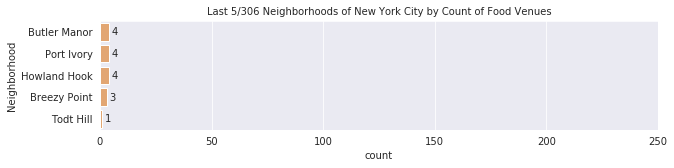

In [68]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Neighborhood", x="Food Venues", data=newyork_venues_food_freq_by_neighborhood.tail(5), color="sandybrown")
ax.set_xlim(0, 250)
plt.title("Last 5/306 Neighborhoods of New York City by Count of Food Venues", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Neighborhood")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')

fig.savefig('newyork_venues_food_freq_by_neighborhood_last_5.png', bbox_inches = 'tight')
plt.show()

##### 3.1.N.5 Count of Food Venues of Each Food Venue Category in New York City

In [69]:
newyork_venues_food_vc = newyork_venues_food['Venue Category'].value_counts().to_frame(name='Count').reset_index()
newyork_venues_food_vc = newyork_venues_food_vc.rename(columns = {"index": "Food Venue Category"}) 
newyork_venues_food_vc.head()

Food Venue Category  Count
0         Pizza Place   1774
1       Deli / Bodega   1426
2  Chinese Restaurant   1148
3  Italian Restaurant    957
4              Bakery    750

We could see that the most common *Food* venue category found in the neighborhoods of New York City is **Pizza** places. 
**Deli / Bodega**  comes next, and then come the **Chinese** restaurants. 
**Chinese** restaurants closely beat the **Italian** restaurants. 

Let's create a simple bar plot of the count of 'Food' venue categories  in *New York City*.

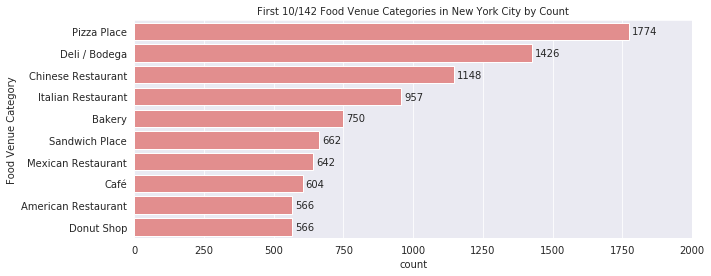

In [70]:
fig = plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Food Venue Category", x="Count", data=newyork_venues_food_vc.head(10), color="lightcoral")
ax.set_xlim(0, 2000)
plt.title("First 10/142 Food Venue Categories in New York City by Count", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Food Venue Category")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')
fig.savefig('newyork_venues_food_vc_head_10.png', bbox_inches = 'tight')
plt.show()

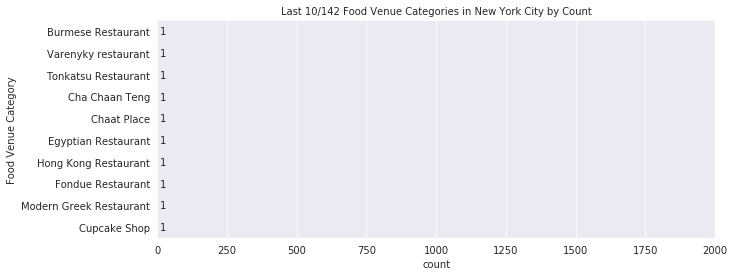

In [71]:
fig = plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Food Venue Category", x="Count", data=newyork_venues_food_vc.tail(10), color="blue")
ax.set_xlim(0, 2000)
plt.title("Last 10/142 Food Venue Categories in New York City by Count", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Food Venue Category")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')
fig.savefig('newyork_venues_food_vc_tail_10.png', bbox_inches = 'tight')
plt.show()

##### 3.1.N.6 Food Venue Categories Found in New York City, but Not in Toronto

In [72]:
"So Toronto has {} unique Food venue categories whereas New York City has {} unique Food venue categories.".format(len(toronto_venues_food['Venue Category'].unique()), len(newyork_venues_food['Venue Category'].unique()))

'So Toronto has 109 unique Food venue categories whereas New York City has 142 unique Food venue categories.'

In [73]:
# unique Food venue categories in Toronto
toronto_food_vc = toronto_venues_food['Venue Category'].unique()

# unique Food venue categories in New York City
newyork_food_vc = newyork_venues_food['Venue Category'].unique()

Let's find out the Food venue categories that are available in New York City but *not* in Toronto.

In [74]:
newyork_food_vc_not_in_toronto = np.setdiff1d(newyork_food_vc, toronto_food_vc)
print("The number of unique venue categories found in New York City, but not in Toronto are", len(newyork_food_vc_not_in_toronto))
newyork_food_vc_not_in_toronto

The number of unique venue categories found in New York City, but not in Toronto are 39


array(['Argentinian Restaurant', 'Australian Restaurant',
       'Austrian Restaurant', 'Burmese Restaurant',
       'Caucasian Restaurant', 'Cha Chaan Teng', 'Chaat Place',
       'Cupcake Shop', 'Czech Restaurant', 'Egyptian Restaurant',
       'English Restaurant', 'Fondue Restaurant', 'Food Stand',
       'Himalayan Restaurant', 'Japanese Curry Restaurant',
       'Kebab Restaurant', 'Kofte Place', 'Kosher Restaurant',
       'Lebanese Restaurant', 'Modern Greek Restaurant',
       'Molecular Gastronomy Restaurant', 'Paella Restaurant',
       'Peruvian Restaurant', 'Pet Café', 'Polish Restaurant',
       'Romanian Restaurant', 'Russian Restaurant',
       'Salvadoran Restaurant', 'Scandinavian Restaurant',
       'Shabu-Shabu Restaurant', 'Soba Restaurant',
       'South Indian Restaurant', 'Swiss Restaurant',
       'Szechuan Restaurant', 'Tex-Mex Restaurant', 'Tonkatsu Restaurant',
       'Ukrainian Restaurant', 'Varenyky restaurant',
       'Venezuelan Restaurant'], dtype=objec

In [75]:
"Let's find the count of each of these {} Food Venue Categories in the neighborhoods of New York City.".format(len(newyork_food_vc_not_in_toronto))

"Let's find the count of each of these 39 Food Venue Categories in the neighborhoods of New York City."

In [76]:
newyork_food_vc_not_in_toronto_count = newyork_venues_food[newyork_venues_food['Venue Category'].isin(newyork_food_vc_not_in_toronto)]['Venue Category'].value_counts().rename_axis('Food Venue Category').reset_index(name='Count')
newyork_food_vc_not_in_toronto_count.head(10)

Food Venue Category  Count
0        Peruvian Restaurant     61
1         Russian Restaurant     28
2     Argentinian Restaurant     26
3      Australian Restaurant     16
4        Szechuan Restaurant     16
5        Lebanese Restaurant     12
6  Japanese Curry Restaurant     11
7                 Food Stand     11
8          Kosher Restaurant     11
9        Austrian Restaurant     10

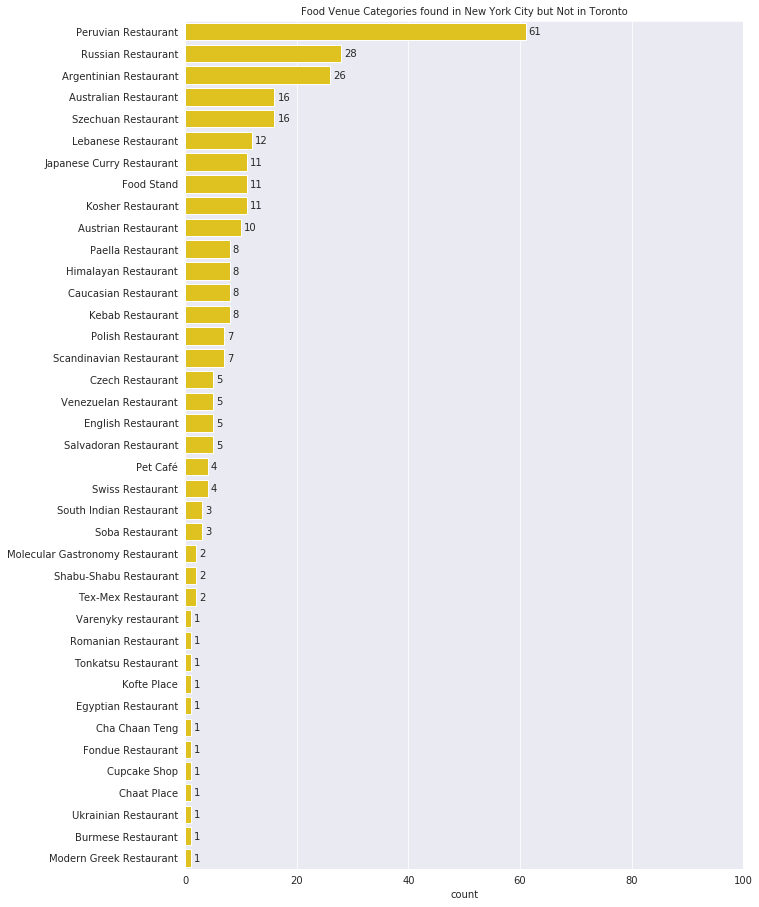

In [77]:
fig = plt.figure(figsize=(10, 15.6))
sns.set_style('darkgrid')
ax=sns.barplot(y="Food Venue Category", x="Count", data=newyork_food_vc_not_in_toronto_count, color="gold")
ax.set_xlim(0, 100)
plt.title("Food Venue Categories found in New York City but Not in Toronto", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')

fig.savefig('newyork_food_vc_not_in_toronto_count.png', bbox_inches = 'tight')
plt.show()

In [78]:

display_side_by_side(newyork_food_vc_not_in_toronto_count[0:20],newyork_food_vc_not_in_toronto_count[20:40])

Food Venue Category 
 Count 
 
 
 
 
 0 
 Peruvian Restaurant 
 61 
 
 
 1 
 Russian Restaurant 
 28 
 
 
 2 
 Argentinian Restaurant 
 26 
 
 
 3 
 Australian Restaurant 
 16 
 
 
 4 
 Szechuan Restaurant 
 16 
 
 
 5 
 Lebanese Restaurant 
 12 
 
 
 6 
 Japanese Curry Restaurant 
 11 
 
 
 7 
 Food Stand 
 11 
 
 
 8 
 Kosher Restaurant 
 11 
 
 
 9 
 Austrian Restaurant 
 10 
 
 
 10 
 Paella Restaurant 
 8 
 
 
 11 
 Himalayan Restaurant 
 8 
 
 
 12 
 Caucasian Restaurant 
 8 
 
 
 13 
 Kebab Restaurant 
 8 
 
 
 14 
 Polish Restaurant 
 7 
 
 
 15 
 Scandinavian Restaurant 
 7 
 
 
 16 
 Czech Restaurant 
 5 
 
 
 17 
 Venezuelan Restaurant 
 5 
 
 
 18 
 English Restaurant 
 5 
 
 
 19 
 Salvadoran Restaurant 
 5 
 
 
 
 
 
 
 Food Venue Category 
 Count 
 
 
 
 
 20 
 Pet Café 
 4 
 
 
 21 
 Swiss Restaurant 
 4 
 
 
 22 
 South Indian Restaurant 
 3 
 
 
 23 
 Soba Restaurant 
 3 
 
 
 24 
 Molecular Gastronomy Restaurant 
 2 
 
 
 25 
 Shabu-Shabu Restaurant 
 2 
 
 
 26 
 Tex-Mex Restaurant 
 2 
 
 
 27 
 Varenyky restaurant 
 1 
 
 
 28 
 Romanian Restaurant 
 1 
 
 
 29 
 Tonkatsu Restaurant 
 1 
 
 
 30 
 Kofte Place 
 1 
 
 
 31 
 Egyptian Restaurant 
 1 
 
 
 32 
 Cha Chaan Teng 
 1 
 
 
 33 
 Fondue Restaurant 
 1 
 
 
 34 
 Cupcake Shop 
 1 
 
 
 35 
 Chaat Place 
 1 
 
 
 36 
 Ukrainian Restaurant 
 1 
 
 
 37 
 Burmese Restaurant 
 1 
 
 
 38 
 Modern Greek Restaurant 
 1

##### 3.1.T.6 Food Venue Categories Found in Toronto, but Not in New York City

Let's find out the Food venue categories that are available in Toronto but *not* in New York City.

In [79]:
toronto_food_vc_not_in_newyork = np.setdiff1d(toronto_food_vc, newyork_food_vc)
print("The number of unique venue categories found in Toronto, but not in New York City are", len(toronto_food_vc_not_in_newyork))
toronto_food_vc_not_in_newyork

The number of unique venue categories found in Toronto, but not in New York City are 6


array(['Churrascaria', 'Doner Restaurant', 'Hakka Restaurant',
       'Indian Chinese Restaurant', 'Pide Place', 'Poutine Place'],
      dtype=object)

In [80]:
"Let's find the count of the {} Venue Categories in the neighborhoods of Toronto.".format(len(toronto_food_vc_not_in_newyork))

"Let's find the count of the 6 Venue Categories in the neighborhoods of Toronto."

In [81]:
toronto_food_vc_not_in_newyork_count = toronto_venues_food[toronto_venues_food['Venue Category'].isin(toronto_food_vc_not_in_newyork)]['Venue Category'].value_counts().rename_axis('Food Venue Category').reset_index(name='Count')
toronto_food_vc_not_in_newyork_count

Food Venue Category  Count
0              Poutine Place     28
1           Doner Restaurant      7
2  Indian Chinese Restaurant      4
3               Churrascaria      2
4           Hakka Restaurant      1
5                 Pide Place      1

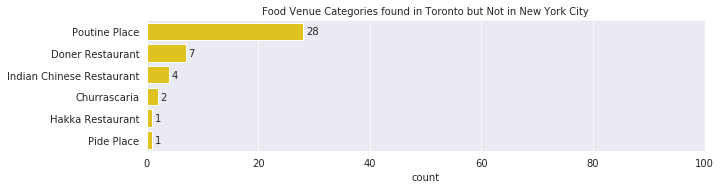

In [82]:
fig = plt.figure(figsize=(10, 2.4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Food Venue Category", x="Count", data=toronto_food_vc_not_in_newyork_count, color="gold")
ax.set_xlim(0, 100)
plt.title("Food Venue Categories found in Toronto but Not in New York City", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')

fig.savefig('toronto_food_vc_not_in_newyork_count.png', bbox_inches = 'tight')
plt.show()

##### 3.1.T.7 First 4 Food Venue Categories by Count in Each Borough of Toronto

Now let's analyse each neighborhood of **Toronto** for *Food* Venue Category. Later, we'll repeat the same exercise for New York City.

In [83]:
# one hot encoding
toronto_onehot_food = pd.get_dummies(toronto_venues_food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot_food['Neighborhood'] = toronto_venues_food['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [toronto_onehot_food.columns[-1]] + list(toronto_onehot_food.columns[:-1])
toronto_onehot_food = toronto_onehot_food[fixed_columns]
print(toronto_onehot_food.shape)

toronto_onehot_food.head(5)

(6984, 110)


Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0    Parkwoods                  0                   0                    0   
1    Parkwoods                  0                   0                    0   
2    Parkwoods                  0                   0                    0   
3    Parkwoods                  0                   0                    0   
4    Parkwoods                  0                   0                    0   

   Arepa Restaurant  Asian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                 0                 0          0           0       0   
1                 0                 0          0           0       0   
2                 0                 0          0           0       0   
3                 0                 0          0           0       0   
4                 0                 0          0           0       0   

   Belgian Restaurant  Bistro  Brazilian Restaurant  Breakfast Spot  Buffet  \
0                   0       0                     0               0       0   
1                   0       0                     0               0       0   
2                   0       0                     0               0       0   
3                   0       0                     0               0       0   
4                   0       0                     0               0       0   

   Burger Joint  Burrito Place  Cafeteria  Café  Cajun / Creole Restaurant  \
0             0              0          0     0                          0   
1             0              0          0     1                          0   
2             0              0          0     0                          0   
3             0              0          0     0                          0   
4             0              0          0     0                          0   

   Cambodian Restaurant  Cantonese Restaurant  Caribbean Restaurant  \
0                     0                     0                     1   
1                     0                     0                     0   
2                     0                     0                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   Chinese Restaurant  Churrascaria  Colombian Restaurant  \
0                   0             0                     0   
1                   0             0                     0   
2                   0             0                     0   
3                   0             0                     0   
4                   0             0                     0   

   Comfort Food Restaurant  Creperie  Cuban Restaurant  Deli / Bodega  \
0                        0         0                 0              0   
1                        0         0                 0              0   
2                        0         0                 0              0   
3                        0         0                 0              0   
4                        0         0                 0              0   

   Dim Sum Restaurant  Diner  Doner Restaurant  Donut Shop  \
0                   0      0                 0           0   
1                   0      0                 0           0   
2                   0      0                 0           0   
3                   0      0                 0           0   
4                   0      0                 0           0   

   Dumpling Restaurant  Eastern European Restaurant  Empanada Restaurant  \
0                    0                            0                    0   
1                    0                            0                    0   
2                    0                            0                    0   
3                    0                            0                    0   
4                    0                            0                    0   

   Ethiopian Restaurant  Falafel Restaurant  Fast Food Restaurant  \
0                     0 

Now let's draw a Bar Plot of the first 4 Food venue categories by their count in each Borough of Toronto. 
Earlier we found that Café, Pizza Place, Restaurant and Sandwich Place were the first 4 Food venue categories by count in Toronto. 

In [84]:
df_toronto_venues_cafe_freq_by_borough = df_toronto_venues_food_freq_by_borough[df_toronto_venues_food_freq_by_borough['Food Venue Category'].isin(["Café"])]
df_toronto_cafe_borough = df_toronto_venues_cafe_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Café').reset_index()

df_toronto_venues_pizza_freq_by_borough = df_toronto_venues_food_freq_by_borough[df_toronto_venues_food_freq_by_borough['Food Venue Category'].isin(["Pizza Place"])]
df_toronto_pizza_borough = df_toronto_venues_pizza_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Pizza Place').reset_index()

df_toronto_venues_restaurant_freq_by_borough = df_toronto_venues_food_freq_by_borough[df_toronto_venues_food_freq_by_borough['Food Venue Category'].isin(["Restaurant"])]
df_toronto_restaurant_borough = df_toronto_venues_restaurant_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Restaurant').reset_index()

# df_toronto_venues_sandwich_freq_by_borough = df_toronto_venues_food_freq_by_borough[df_toronto_venues_food_freq_by_borough['Food Venue Category'].isin(["Sandwich Place"])]
# df_toronto_sandwich_borough = df_toronto_venues_sandwich_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Sandwich Place').reset_index()

# dfs = [df_toronto_pizza_borough, df_toronto_restaurant_borough, df_toronto_sandwich_borough, df_toronto_cafe_borough]

df_toronto_venues_italian_freq_by_borough = df_toronto_venues_food_freq_by_borough[df_toronto_venues_food_freq_by_borough['Food Venue Category'].isin(["Italian Restaurant"])]
df_toronto_italian_borough = df_toronto_venues_italian_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Italian Restaurant').reset_index()

dfs = [df_toronto_pizza_borough, df_toronto_restaurant_borough, df_toronto_italian_borough, df_toronto_cafe_borough]

df_toronto_4_mc_food_vc = reduce(lambda left, right: pd.merge(left, right, on='Borough', how='outer'), dfs)
df_toronto_4_mc_food_vc['Café'] = df_toronto_4_mc_food_vc['Café'].replace(np.nan, 0)
df_toronto_4_mc_food_vc = df_toronto_4_mc_food_vc.astype({"Café": int})
df_toronto_4_mc_food_vc['Pizza Place'] = df_toronto_4_mc_food_vc['Pizza Place'].replace(np.nan, 0)
df_toronto_4_mc_food_vc = df_toronto_4_mc_food_vc.astype({"Pizza Place": int})
df_toronto_4_mc_food_vc['Restaurant'] = df_toronto_4_mc_food_vc['Restaurant'].replace(np.nan, 0)
df_toronto_4_mc_food_vc = df_toronto_4_mc_food_vc.astype({"Restaurant": int})
# df_toronto_4_mc_food_vc['Sandwich Place'] = df_toronto_4_mc_food_vc['Sandwich Place'].replace(np.nan, 0)
# df_toronto_4_mc_food_vc = df_toronto_4_mc_food_vc.astype({"Sandwich Place": int})
df_toronto_4_mc_food_vc['Italian Restaurant'] = df_toronto_4_mc_food_vc['Italian Restaurant'].replace(np.nan, 0)
df_toronto_4_mc_food_vc = df_toronto_4_mc_food_vc.astype({"Italian Restaurant": int})
df_toronto_4_mc_food_vc

Borough  Pizza Place  Restaurant  Italian Restaurant  Café
0    Central Toronto           64          40                  87    68
1   Downtown Toronto           96         178                 153   298
2       East Toronto           40          22                  18    34
3          East York           18           9                   3    12
4          Etobicoke           70          16                  46    24
5        Mississauga            2           2                   1     0
6         North York           58          44                  23    29
7       Queen's Park            5           6                   4     8
8        Scarborough           67          17                   9     4
9       West Toronto           71          57                  46   121
10              York           28           9                   8    13

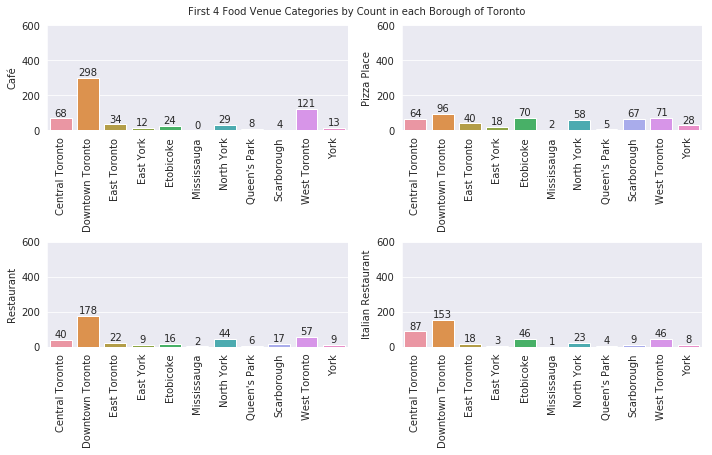

In [85]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 6.4))

sns.barplot(x="Borough", y="Café", data=df_toronto_4_mc_food_vc, ax=axarr[0][0]);
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 600)
for tick in axarr[0,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.barplot(x="Borough", y="Pizza Place", data=df_toronto_4_mc_food_vc, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 600)
for tick in axarr[0,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.barplot(x="Borough", y="Restaurant", data=df_toronto_4_mc_food_vc, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 600)
for tick in axarr[1,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.barplot(x="Borough", y="Italian Restaurant", data=df_toronto_4_mc_food_vc, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 600)
for tick in axarr[1,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.94)
fig.suptitle('First 4 Food Venue Categories by Count in each Borough of Toronto', fontsize='medium')
fig.savefig('df_toronto_4_mc_food_vc.png', bbox_inches = 'tight')
plt.show()

##### 3.1.T.8 1st, 2nd, 3rd and 4th Most Common Food Venue in the Neighborhoods of Toronto

Let's group the rows by neighborhood and taking the mean of the frequency of occurrence of each *Food* Value category

In [86]:
toronto_grouped_food = toronto_onehot_food.groupby('Neighborhood').mean().reset_index()
toronto_grouped_food.head()

Neighborhood  Afghan Restaurant  African Restaurant  \
0         Adelaide                0.0                 0.0   
1        Agincourt                0.0                 0.0   
2  Agincourt North                0.0                 0.0   
3   Albion Gardens                0.0                 0.0   
4        Alderwood                0.0                 0.0   

   American Restaurant  Arepa Restaurant  Asian Restaurant  BBQ Joint  \
0             0.040000               0.0          0.020000   0.000000   
1             0.025641               0.0          0.051282   0.025641   
2             0.000000               0.0          0.000000   0.083333   
3             0.000000               0.0          0.000000   0.000000   
4             0.000000               0.0          0.000000   0.000000   

   Bagel Shop    Bakery  Belgian Restaurant  Bistro  Brazilian Restaurant  \
0         0.0  0.030000                 0.0     0.0                  0.01   
1         0.0  0.051282                 0.0     0.0                  0.00   
2         0.0  0.083333                 0.0     0.0                  0.00   
3         0.0  0.000000                 0.0     0.0                  0.00   
4         0.0  0.000000                 0.0     0.0                  0.00   

   Breakfast Spot  Buffet  Burger Joint  Burrito Place  Cafeteria  Café  \
0        0.040000     0.0          0.03           0.03        0.0   0.1   
1        0.025641     0.0          0.00           0.00        0.0   0.0   
2        0.000000     0.0          0.00           0.00        0.0   0.0   
3        0.000000     0.0          0.00           0.00        0.0   0.0   
4        0.000000     0.0          0.00           0.00        0.0   0.0   

   Cajun / Creole Restaurant  Cambodian Restaurant  Cantonese Restaurant  \
0                        0.0                   0.0              0.000000   
1                        0.0                   0.0              0.025641   
2                        0.0                   0.0              0.000000   
3                        0.0                   0.0              0.000000   
4                        0.0                   0.0              0.000000   

   Caribbean Restaurant  Chinese Restaurant  Churrascaria  \
0              0.000000            0.000000           0.0   
1              0.051282            0.307692           0.0   
2              0.041667            0.333333           0.0   
3              0.000000            0.000000           0.0   
4              0.000000            0.000000           0.0   

   Colombian Restaurant  Comfort Food Restaurant  Creperie  Cuban Restaurant  \
0                  0.01                      0.0       0.0               0.0   
1                  0.00                      0.0       0.0               0.0   
2                  0.00                      0.0       0.0               0.0   
3                  0.00                      0.0       0.0               0.0   
4                  0.00                      0.0       0.0               0.0   

   Deli / Bodega  Dim Sum Restaurant  Diner  Doner Restaurant  Donut Shop  \
0           0.03                 0.0    0.0               0.0         0.0   
1           0.00                 0.0    0.0               0.0         0.0   
2           0.00                 0.0    0.0               0.0         0.0   
3           0.00                 0.0    0.0               0.0         0.0   
4           0.00                 0.0    0.0               0.0         0.2   

   Dumpling Restaurant  Eastern European Restaurant  Empanada Restaurant  \
0                  0.0                          0.0                  0.0   
1                  0.0                          0.0                  0.0   
2                  0.0                          0.0                  0.0   
3                  0.0                          0.0                  0.0   
4                  0.0                          0.0                  0.0   

   Ethiopian Restaurant  Falafel Restaurant  Fast Food Restau

Now let's create a pandas dataframe to display the top 10 food venues for each neighborhood.

But first, let's write a function to sort the venues in descending order.

In [87]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 food venues for each neighborhood.

In [88]:
num_top_food_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_food_venues):
    try:
        columns.append('{}{} Most Common Food Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Food Venue'.format(ind+1))

# create a new dataframe
toronto_neighborhoods_food_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_food_venues_sorted['Neighborhood'] = toronto_grouped_food['Neighborhood']

for ind in np.arange(toronto_grouped_food.shape[0]):
    toronto_neighborhoods_food_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped_food.iloc[ind, :], num_top_food_venues)

toronto_neighborhoods_food_venues_sorted.head()

Neighborhood 1st Most Common Food Venue 2nd Most Common Food Venue  \
0         Adelaide                       Café         Italian Restaurant   
1        Agincourt         Chinese Restaurant       Caribbean Restaurant   
2  Agincourt North         Chinese Restaurant          Korean Restaurant   
3   Albion Gardens                Pizza Place             Sandwich Place   
4        Alderwood                Pizza Place                 Donut Shop   

  3rd Most Common Food Venue 4th Most Common Food Venue  \
0                 Restaurant        Japanese Restaurant   
1                 Restaurant             Sandwich Place   
2               Noodle House                     Bakery   
3        Fried Chicken Joint           Sushi Restaurant   
4             Sandwich Place        Moroccan Restaurant   

  5th Most Common Food Venue 6th Most Common Food Venue  \
0                Pizza Place                 Steakhouse   
1           Asian Restaurant                     Bakery   
2                  BBQ Joint       Fast Food Restaurant   
3        Japanese Restaurant       Fast Food Restaurant   
4                Wings Joint         Dim Sum Restaurant   

  7th Most Common Food Venue 8th Most Common Food Venue  \
0        American Restaurant             Breakfast Spot   
1                Pizza Place       Cantonese Restaurant   
2                Pizza Place           Malay Restaurant   
3                 Donut Shop           Doner Restaurant   
4                      Diner           Doner Restaurant   

  9th Most Common Food Venue    10th Most Common Food Venue  
0                  Gastropub                  Deli / Bodega  
1         Seafood Restaurant            Shanghai Restaurant  
2        Fried Chicken Joint  Vegetarian / Vegan Restaurant  
3         Falafel Restaurant                          Diner  
4        Dumpling Restaurant    Eastern European Restaurant

In [89]:
print('The shape of toronto_neighborhoods_food_venues_sorted is', toronto_neighborhoods_food_venues_sorted.shape)

The shape of toronto_neighborhoods_food_venues_sorted is (207, 11)


Now let's draw a plot for the 1st, 2nd, 3rd and 4th Most Common Food Venue in the neighborhoods of Toronto.

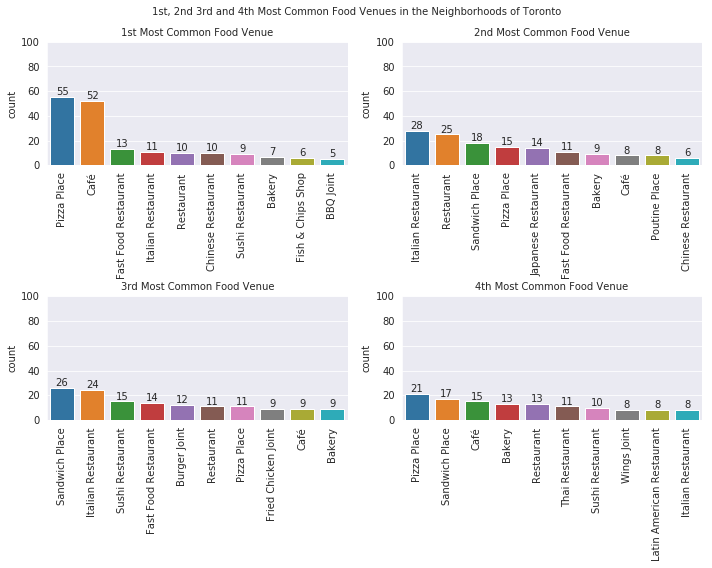

In [90]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 8))

sns.countplot(x="1st Most Common Food Venue", data=toronto_neighborhoods_food_venues_sorted, 
                 order=toronto_neighborhoods_food_venues_sorted["1st Most Common Food Venue"].value_counts().iloc[:10].index, ax=axarr[0][0])
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 100)
axarr[0,0].set_title('1st Most Common Food Venue', fontsize='medium')
for tick in axarr[0,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="2nd Most Common Food Venue", data=toronto_neighborhoods_food_venues_sorted, 
                 order=toronto_neighborhoods_food_venues_sorted["2nd Most Common Food Venue"].value_counts().iloc[:10].index, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 100)
axarr[0,1].set_title('2nd Most Common Food Venue', fontsize='medium')
for tick in axarr[0,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="3rd Most Common Food Venue", data=toronto_neighborhoods_food_venues_sorted, 
                 order=toronto_neighborhoods_food_venues_sorted["3rd Most Common Food Venue"].value_counts().iloc[:10].index, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 100)
axarr[1,0].set_title('3rd Most Common Food Venue', fontsize='medium')
for tick in axarr[1,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="4th Most Common Food Venue", data=toronto_neighborhoods_food_venues_sorted, 
                 order=toronto_neighborhoods_food_venues_sorted["4th Most Common Food Venue"].value_counts().iloc[:10].index, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 100)
axarr[1,1].set_title('4th Most Common Food Venue', fontsize='medium')
for tick in axarr[1,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle('1st, 2nd 3rd and 4th Most Common Food Venues in the Neighborhoods of Toronto', fontsize='medium')
fig.savefig('df_toronto_4_mc_food_vc_all.png', bbox_inches = 'tight')
plt.show()

##### 3.1.N.7 First 4 Food Venue Categories by Count in Each Borough of New York City

Just like we analysed each neighborhood of *Toronto* for *Food* Venue Category. Let's do the same analysis for **New York City** now.

In [91]:
# one hot encoding
newyork_onehot_food = pd.get_dummies(newyork_venues_food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot_food['Neighborhood'] = newyork_venues_food['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [newyork_onehot_food.columns[-1]] + list(newyork_onehot_food.columns[:-1])
newyork_onehot_food = newyork_onehot_food[fixed_columns]
print(newyork_onehot_food.shape)

newyork_onehot_food.head()

(17971, 143)


Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0    Wakefield                  0                   0                    0   
1    Wakefield                  0                   0                    0   
2    Wakefield                  0                   0                    0   
3    Wakefield                  0                   0                    0   
4    Wakefield                  0                   0                    0   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0                 0                       0                 0   
1                 0                       0                 0   
2                 0                       0                 0   
3                 0                       0                 0   
4                 0                       0                 0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                      0                    0          0           0       0   
1                      0                    0          0           0       0   
2                      0                    0          0           0       0   
3                      0                    0          0           0       0   
4                      0                    0          0           0       0   

   Belgian Restaurant  Bistro  Brazilian Restaurant  Breakfast Spot  Buffet  \
0                   0       0                     0               0       0   
1                   0       0                     0               0       0   
2                   0       0                     0               0       0   
3                   0       0                     0               0       0   
4                   0       0                     0               0       0   

   Burger Joint  Burmese Restaurant  Burrito Place  Cafeteria  Café  \
0             0                   0              0          0     0   
1             0                   0              0          0     0   
2             0                   0              0          0     0   
3             1                   0              0          0     0   
4             0                   0              0          0     0   

   Cajun / Creole Restaurant  Cambodian Restaurant  Cantonese Restaurant  \
0                          0                     0                     0   
1                          0                     0                     0   
2                          0                     0                     0   
3                          0                     0                     0   
4                          0                     0                     0   

   Caribbean Restaurant  Caucasian Restaurant  Cha Chaan Teng  Chaat Place  \
0                     1                     0               0            0   
1                     1                     0               0            0   
2                     1                     0               0            0   
3                     0                     0               0            0   
4                     1                     0               0            0   

   Chinese Restaurant  Colombian Restaurant  Comfort Food Restaurant  \
0                   0                     0                        0   
1                   0                     0                        0   
2                   0                     0                        0   
3                   0                     0                        0   
4                   0                     0                        0   

   Creperie  Cuban Restaurant  Cupcake Shop  Czech Restaurant  Deli / Bodega  \
0         0                 0             0                 0              0   
1         0                 0             0                 0              0   
2         0                 0             0                 0              0   
3         0                 0             0                 0              0   


Let's draw a Bar Plot of First 4 Food Venue Categories by their Count in each Borough of New York City. Earlier we found that Pizza Place, Deli / Bodega, Chinese Restaurant and Italian Restaurant were the first 4 Food venue categories by count in New York City.

In [92]:
df_newyork_venues_pizza_freq_by_borough = df_newyork_venues_food_freq_by_borough[df_newyork_venues_food_freq_by_borough['Food Venue Category'].isin(["Pizza Place"])]
df_newyork_pizza_borough = df_newyork_venues_pizza_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Pizza Place').reset_index()

df_newyork_venues_deli_freq_by_borough = df_newyork_venues_food_freq_by_borough[df_newyork_venues_food_freq_by_borough['Food Venue Category'].isin(["Deli / Bodega"])]
df_newyork_deli_borough = df_newyork_venues_deli_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Deli / Bodega').reset_index()

df_newyork_venues_chinese_freq_by_borough = df_newyork_venues_food_freq_by_borough[df_newyork_venues_food_freq_by_borough['Food Venue Category'].isin(["Chinese Restaurant"])]
df_newyork_chinese_borough = df_newyork_venues_chinese_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Chinese Restaurant').reset_index()

df_newyork_venues_italian_freq_by_borough = df_newyork_venues_food_freq_by_borough[df_newyork_venues_food_freq_by_borough['Food Venue Category'].isin(["Italian Restaurant"])]
df_newyork_italian_borough = df_newyork_venues_italian_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Italian Restaurant').reset_index()

dfs = [df_newyork_deli_borough, df_newyork_chinese_borough, df_newyork_italian_borough, df_newyork_pizza_borough]

df_newyork_4_mc_food_vc = reduce(lambda left, right: pd.merge(left, right, on='Borough', how='outer'), dfs)
df_newyork_4_mc_food_vc

Borough  Deli / Bodega  Chinese Restaurant  Italian Restaurant  \
0          Bronx            311                 240                 107   
1       Brooklyn            405                 303                 209   
2      Manhattan            129                 139                 352   
3         Queens            395                 363                 162   
4  Staten Island            209                 122                 152   

   Pizza Place  
0          405  
1          515  
2          239  
3          397  
4          247

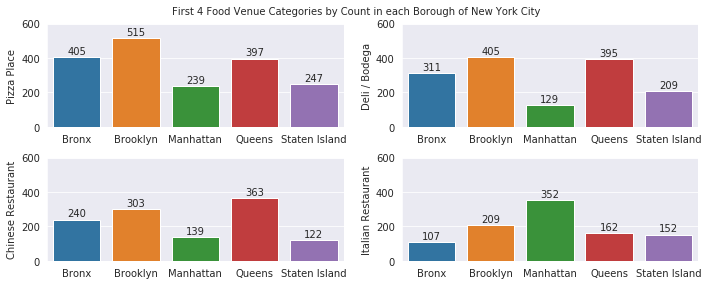

In [93]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 4))

sns.barplot(x="Borough", y="Pizza Place", data=df_newyork_4_mc_food_vc, ax=axarr[0][0]);
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 600)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 3), textcoords='offset points')

sns.barplot(x="Borough", y="Deli / Bodega", data=df_newyork_4_mc_food_vc, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 600)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 3), textcoords='offset points')

sns.barplot(x="Borough", y="Chinese Restaurant", data=df_newyork_4_mc_food_vc, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 600)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 3), textcoords='offset points')

sns.barplot(x="Borough", y="Italian Restaurant", data=df_newyork_4_mc_food_vc, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 600)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 3), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle('First 4 Food Venue Categories by Count in each Borough of New York City', fontsize='medium')
fig.savefig('df_newyork_4_mc_food_vc.png', bbox_inches = 'tight')
plt.show()

##### 3.1.N.8 1st, 2nd, 3rd and 4th Most Common Food Venues in the Neighborhoods of New York City

Let's group the rows by neighborhood and taking the mean of the frequency of occurrence of each *Food* Value category

In [94]:
newyork_grouped_food = newyork_onehot_food.groupby('Neighborhood').mean().reset_index()
newyork_grouped_food.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0       Allerton                0.0                 0.0             0.032258   
1       Annadale                0.0                 0.0             0.187500   
2  Arden Heights                0.0                 0.0             0.000000   
3      Arlington                0.0                 0.0             0.083333   
4       Arrochar                0.0                 0.0             0.000000   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0               0.0                     0.0          0.000000   
1               0.0                     0.0          0.000000   
2               0.0                     0.0          0.000000   
3               0.0                     0.0          0.083333   
4               0.0                     0.0          0.000000   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Bagel Shop  \
0                    0.0                  0.0        0.0    0.000000   
1                    0.0                  0.0        0.0    0.000000   
2                    0.0                  0.0        0.0    0.090909   
3                    0.0                  0.0        0.0    0.000000   
4                    0.0                  0.0        0.0    0.111111   

     Bakery  Belgian Restaurant  Bistro  Brazilian Restaurant  Breakfast Spot  \
0  0.032258                 0.0     0.0                   0.0        0.016129   
1  0.125000                 0.0     0.0                   0.0        0.000000   
2  0.000000                 0.0     0.0                   0.0        0.000000   
3  0.000000                 0.0     0.0                   0.0        0.000000   
4  0.000000                 0.0     0.0                   0.0        0.000000   

   Buffet  Burger Joint  Burmese Restaurant  Burrito Place  Cafeteria  Café  \
0     0.0           0.0                 0.0            0.0        0.0   0.0   
1     0.0           0.0                 0.0            0.0        0.0   0.0   
2     0.0           0.0                 0.0            0.0        0.0   0.0   
3     0.0           0.0                 0.0            0.0        0.0   0.0   
4     0.0           0.0                 0.0            0.0        0.0   0.0   

   Cajun / Creole Restaurant  Cambodian Restaurant  Cantonese Restaurant  \
0                        0.0                   0.0                   0.0   
1                        0.0                   0.0                   0.0   
2                        0.0                   0.0                   0.0   
3                        0.0                   0.0                   0.0   
4                        0.0                   0.0                   0.0   

   Caribbean Restaurant  Caucasian Restaurant  Cha Chaan Teng  Chaat Place  \
0              0.064516                   0.0             0.0          0.0   
1              0.000000                   0.0             0.0          0.0   
2              0.000000                   0.0             0.0          0.0   
3              0.000000                   0.0             0.0          0.0   
4              0.000000                   0.0             0.0          0.0   

   Chinese Restaurant  Colombian Restaurant  Comfort Food Restaurant  \
0            0.129032                   0.0                      0.0   
1            0.000000                   0.0                      0.0   
2            0.090909                   0.0                      0.0   
3            0.000000                   0.0                      0.0   
4            0.055556                   0.0                      0.0   

   Creperie  Cuban Restaurant  Cupcake Shop  Czech Restaurant  Deli / Bodega  \
0       0.0               0.0           0.0               0.0       0.129032   
1       0.0               0.0           0.0               0.0       0.062500   
2       0.0               0.0           0.0               0.0       0.090909   
3       0.0               0.0           0.0               

Now let's create a pandas dataframe to display the top 10 food venues for each neighborhood.

In [95]:
num_top_food_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_food_venues):
    try:
        columns.append('{}{} Most Common Food Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Food Venue'.format(ind+1))

# create a new dataframe
newyork_neighborhoods_food_venues_sorted = pd.DataFrame(columns=columns)
newyork_neighborhoods_food_venues_sorted['Neighborhood'] = newyork_grouped_food['Neighborhood']

for ind in np.arange(newyork_grouped_food.shape[0]):
    newyork_neighborhoods_food_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped_food.iloc[ind, :], num_top_food_venues)

newyork_neighborhoods_food_venues_sorted.head()

Neighborhood 1st Most Common Food Venue 2nd Most Common Food Venue  \
0       Allerton                Pizza Place              Deli / Bodega   
1       Annadale                Pizza Place        American Restaurant   
2  Arden Heights                       Food         Mexican Restaurant   
3      Arlington              Deli / Bodega       Fast Food Restaurant   
4       Arrochar              Deli / Bodega                Pizza Place   

  3rd Most Common Food Venue 4th Most Common Food Venue  \
0         Chinese Restaurant         Mexican Restaurant   
1                 Restaurant                     Bakery   
2         Italian Restaurant                 Bagel Shop   
3           Asian Restaurant                Snack Place   
4                 Bagel Shop                 Food Truck   

  5th Most Common Food Venue 6th Most Common Food Venue  \
0        Fried Chicken Joint       Caribbean Restaurant   
1              Deli / Bodega                      Diner   
2                Pizza Place             Sandwich Place   
3         Spanish Restaurant                Wings Joint   
4         Italian Restaurant  Middle Eastern Restaurant   

  7th Most Common Food Venue 8th Most Common Food Venue  \
0                 Donut Shop             Sandwich Place   
1           Sushi Restaurant                       Food   
2         Chinese Restaurant           Sushi Restaurant   
3                 Donut Shop          Polish Restaurant   
4             Sandwich Place                 Steakhouse   

  9th Most Common Food Venue 10th Most Common Food Venue  
0       Fast Food Restaurant                        Food  
1       Ethiopian Restaurant           Fish & Chips Shop  
2              Deli / Bodega            Greek Restaurant  
3        American Restaurant         Dumpling Restaurant  
4   Mediterranean Restaurant                  Taco Place

In [96]:
print('The shape of newyork_neighborhoods_food_venues_sorted is', newyork_neighborhoods_food_venues_sorted.shape)

The shape of newyork_neighborhoods_food_venues_sorted is (302, 11)


Now let's draw a plot for the 1st, 2nd, 3rd and 4th Most Common Food Venue in the neighborhoods of New York City.

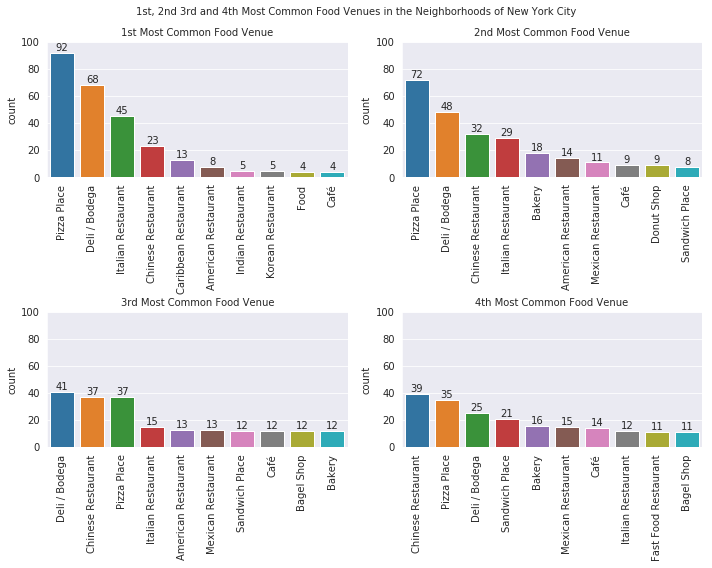

In [97]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 8))

sns.countplot(x="1st Most Common Food Venue", data=newyork_neighborhoods_food_venues_sorted, 
                 order=newyork_neighborhoods_food_venues_sorted["1st Most Common Food Venue"].value_counts().iloc[:10].index, ax=axarr[0][0])
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 100)
axarr[0,0].set_title('1st Most Common Food Venue', fontsize='medium')
for tick in axarr[0,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="2nd Most Common Food Venue", data=newyork_neighborhoods_food_venues_sorted, 
                 order=newyork_neighborhoods_food_venues_sorted["2nd Most Common Food Venue"].value_counts().iloc[:10].index, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 100)
axarr[0,1].set_title('2nd Most Common Food Venue', fontsize='medium')
for tick in axarr[0,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="3rd Most Common Food Venue", data=newyork_neighborhoods_food_venues_sorted, 
                 order=newyork_neighborhoods_food_venues_sorted["3rd Most Common Food Venue"].value_counts().iloc[:10].index, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 100)
axarr[1,0].set_title('3rd Most Common Food Venue', fontsize='medium')
for tick in axarr[1,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="4th Most Common Food Venue", data=newyork_neighborhoods_food_venues_sorted, 
                 order=newyork_neighborhoods_food_venues_sorted["4th Most Common Food Venue"].value_counts().iloc[:10].index, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 100)
axarr[1,1].set_title('4th Most Common Food Venue', fontsize='medium')
for tick in axarr[1,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle('1st, 2nd 3rd and 4th Most Common Food Venues in the Neighborhoods of New York City', fontsize='medium')
fig.savefig('df_newyork_4_mc_food_vc_all.png', bbox_inches = 'tight')
plt.show()

##### 3.1.T.9 Cluster the Neighborhoods in Toronto based on Food Venue Categories <a name="3.1.T.9"></a>

Let's **Cluster the Neighborhoods in Toronto** next to determine similar neighborhoods based on Food venue categories. But first, let's find out the optimum value of k using Elbow Method.

Sqaured Error (Cost) [22.253517952157427, 19.224807010682472, 17.123520846602304, 14.977398237571675, 13.369701553661056, 12.814263279523512, 11.7413776970705, 11.12518695073298, 10.54595334504413, 9.726062433633528, 9.184858098377642]
Elbow Point 5


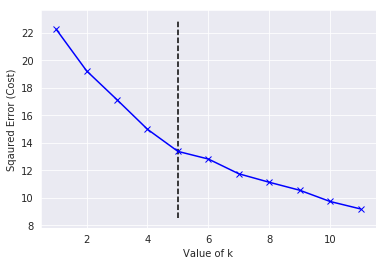

In [98]:
# cluster dataset
toronto_grouped_food_clustering = toronto_grouped_food.drop('Neighborhood', 1)

cost =[] 
for i in range(1, 12): 
    KM = KMeans(n_clusters = i, random_state=0) 
    KM.fit(toronto_grouped_food_clustering)       
    cost.append(KM.inertia_)  
    
print("Sqaured Error (Cost)", cost)
  
k = range(1, len(cost)+1)

from kneed import KneeLocator
kn = KneeLocator(k, cost, curve='convex', direction='decreasing')
t_food_knee = kn.knee
print("Elbow Point", t_food_knee)
plt.xlabel('Value of k')
plt.ylabel('Sqaured Error (Cost)')
plt.plot(k, cost, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [99]:
"As the Elbow Point turns out to be {}, we'll run *k*-means to cluster the neighborhood into {} clusters".format(t_food_knee, t_food_knee)

"As the Elbow Point turns out to be 5, we'll run *k*-means to cluster the neighborhood into 5 clusters"

In [100]:
# set number of clusters
kclusters = t_food_knee

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_food_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 3, 3, 1, 2, 0, 3, 0], dtype=int32)

In [101]:
# drop clustering labels if already inserted
# toronto_neighborhoods_food_venues_sorted = toronto_neighborhoods_food_venues_sorted.drop('Cluster Labels', axis=1)

# add clustering labels
toronto_neighborhoods_food_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# toronto_neighborhoods_with_no_food_indices do not have any Food venues 1000 meters around it, so let's drop them.
# execute the following line just once
toronto_merged_food = df_postalcodes_toronto.drop(df_postalcodes_toronto.index[toronto_neighborhoods_with_no_food_indices]) 

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged_food = toronto_merged_food.join(toronto_neighborhoods_food_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged_food.head() # check the last columns!

Borough      Neighborhood   Latitude  Longitude  Cluster Labels  \
0        North York         Parkwoods  43.753259 -79.329656               1   
1        North York  Victoria Village  43.725882 -79.315572               0   
2  Downtown Toronto      Harbourfront  43.654260 -79.360636               0   
3  Downtown Toronto       Regent Park  43.654260 -79.360636               0   
4        North York  Lawrence Heights  43.718518 -79.464763               0   

  1st Most Common Food Venue 2nd Most Common Food Venue  \
0          Fish & Chips Shop         Chinese Restaurant   
1                       Café      Portuguese Restaurant   
2                       Café         Italian Restaurant   
3                       Café         Italian Restaurant   
4       Fast Food Restaurant                 Restaurant   

  3rd Most Common Food Venue 4th Most Common Food Venue  \
0       Caribbean Restaurant                       Café   
1          French Restaurant                Pizza Place   
2             Sandwich Place                Pizza Place   
3             Sandwich Place                Pizza Place   
4      Vietnamese Restaurant        Fried Chicken Joint   

  5th Most Common Food Venue 6th Most Common Food Venue  \
0       Fast Food Restaurant                Pizza Place   
1           Greek Restaurant     Gluten-free Restaurant   
2           Sushi Restaurant                 Restaurant   
3           Sushi Restaurant                 Restaurant   
4         Seafood Restaurant           Sushi Restaurant   

  7th Most Common Food Venue 8th Most Common Food Venue  \
0        Filipino Restaurant                      Diner   
1              Deli / Bodega         Dim Sum Restaurant   
2       Fast Food Restaurant                      Diner   
3       Fast Food Restaurant                      Diner   
4           Greek Restaurant             Sandwich Place   

  9th Most Common Food Venue 10th Most Common Food Venue  
0           Doner Restaurant                  Donut Shop  
1                      Diner            Doner Restaurant  
2            Thai Restaurant              Breakfast Spot  
3            Thai Restaurant              Breakfast Spot  
4                       Café               Deli / Bodega

Let's use 'geopy' now to get the latitude and longitude values of 'Toronto, Ontario, Canada'. We'll need this to create the map.

In [102]:
toronto_address = 'Toronto, Ontario, Canada'

toronto_geolocator = Nominatim(user_agent="my-application")
toronto_location = toronto_geolocator.geocode(toronto_address)
toronto_latitude = toronto_location.latitude
toronto_longitude = toronto_location.longitude
print('The geograpical coordinates (toronto_latitude, toronto_longitude) of "Toronto, Ontario, Canada" are ({}, {}).'.format(toronto_latitude, toronto_longitude))

The geograpical coordinates (toronto_latitude, toronto_longitude) of "Toronto, Ontario, Canada" are (43.653963, -79.387207).


Let's visualize the resulting clusters now.

In [103]:
# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_food['Latitude'], toronto_merged_food['Longitude'], toronto_merged_food['Neighborhood'], toronto_merged_food['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label, #map not rendering with popup specified
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, let's examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

In [104]:
# Cluster 0
toronto_merged_food.loc[toronto_merged_food['Cluster Labels'] == 0, toronto_merged_food.columns[[1] + list(range(5, toronto_merged_food.shape[1]))]]

Neighborhood  \
1                                     Victoria Village   
2                                         Harbourfront   
3                                          Regent Park   
4                                     Lawrence Heights   
5                                       Lawrence Manor   
6                                         Queen's Park   
10                                     Don Mills North   
13                                             Ryerson   
14                                     Garden District   
21                                      Highland Creek   
22                                          Rouge Hill   
23                                          Port Union   
24                                     Flemingdon Park   
25                                     Don Mills South   
26                                    Woodbine Heights   
27                                  Humewood-Cedarvale   
35                                         The Beaches   
36                                         Berczy Park   
37                                 Caledonia-Fairbanks   
39                                             Leaside   
40                                  Central Bay Street   
41                                            Christie   
42                                           Cedarbrae   
47                                    Thorncliffe Park   
48                                            Adelaide   
49                                                King   
50                                            Richmond   
51                                  Dovercourt Village   
52                                            Dufferin   
59                                        East Toronto   
60                                   Harbourfront East   
61                                     Toronto Islands   
62                                       Union Station   
63                                     Little Portugal   
64                                             Trinity   
68                                     Bayview Village   
69                                         CFB Toronto   
70                                      Downsview East   
71                                   The Danforth West   
72                                           Riverdale   
73                                     Design Exchange   
74                             Toronto Dominion Centre   
75                                            Brockton   
76                                    Exhibition Place   
77                                    Parkdale Village   
81                                        Silver Hills   
82                                          York Mills   
84                                    The Beaches West   
85                                        India Bazaar   
86                                      Commerce Court   
87                                      Victoria Hotel   
95                                         Newtonbrook   
96                                          Willowdale   
97                                   Downsview Central   
98                                     Studio District   
99                                        Bedford Park   
100                                Lawrence Manor East   
105                                              Emery   
106                                          Humberlea   
107                                        Birch Cliff   
108                                     Cliffside West   
109                                   Willowdale South   
112                                           Roselawn   
114                                          Runnymede   
116                                        Dorset Park   
117                            Scarborough Town Centre   
118                                    Wexford Heights   
120                                   Davisville North   
121                                  For

In [105]:
# Cluster 1
toronto_merged_food.loc[toronto_merged_food['Cluster Labels'] == 1, toronto_merged_food.columns[[1] + list(range(5, toronto_merged_food.shape[1]))]]

Neighborhood 1st Most Common Food Venue  \
0               Parkwoods          Fish & Chips Shop   
7        Islington Avenue                     Bakery   
8                   Rouge       Fast Food Restaurant   
9                 Malvern       Fast Food Restaurant   
11       Woodbine Gardens                Pizza Place   
12          Parkview Hill                Pizza Place   
15              Glencairn                Pizza Place   
38                 Woburn          Fish & Chips Shop   
43      Hillcrest Village                Pizza Place   
44         Bathurst Manor                Pizza Place   
45        Downsview North                Pizza Place   
46         Wilson Heights                Pizza Place   
53    Scarborough Village                 Restaurant   
54               Fairview       Fast Food Restaurant   
55             Henry Farm       Fast Food Restaurant   
56                 Oriole       Fast Food Restaurant   
57         Northwood Park                Pizza Place   
58        York University                Pizza Place   
65   East Birchmount Park         Chinese Restaurant   
66                Ionview         Chinese Restaurant   
67           Kennedy Park         Chinese Restaurant   
78               Clairlea                     Bakery   
79            Golden Mile                     Bakery   
80               Oakridge                     Bakery   
83         Downsview West      Vietnamese Restaurant   
88              Downsview                Pizza Place   
89             North Park                Pizza Place   
90            Upwood Park                Pizza Place   
101               Del Ray                 Restaurant   
102            Keelesdale                 Restaurant   
103          Mount Dennis                 Restaurant   
104           Silverthorn                 Restaurant   
110   Downsview Northwest       Fast Food Restaurant   
119       York Mills West                 Restaurant   
128       Willowdale West                Pizza Place   
136     Kingsview Village       Fast Food Restaurant   
137  Martin Grove Gardens       Fast Food Restaurant   
138      Richview Gardens       Fast Food Restaurant   
139          St. Phillips       Fast Food Restaurant   
140             Agincourt         Chinese Restaurant   
146        Clarks Corners                Pizza Place   
147              Sullivan                Pizza Place   
148         Tam O'Shanter                Pizza Place   
154       Agincourt North         Chinese Restaurant   
155       L'Amoreaux East         Chinese Restaurant   
156              Milliken         Chinese Restaurant   
157          Steeles East         Chinese Restaurant   
181       L'Amoreaux West         Chinese Restaurant   

      2nd Most Common Food Venue 3rd Most Common Food Venue  \
0             Chinese Restaurant       Caribbean Restaurant   
7           Fast Food Restaurant                       Café   
8                         Bakery         African Restaurant   
9                         Bakery         African Restaurant   
11                        Bakery       Fast Food Restaurant   
12                        Bakery       Fast Food Restaurant   
15            Italian Restaurant       Fast Food Restaurant   
38             Indian Restaurant                 Restaurant   
43                         Diner         Chinese Restaurant   
44                 Deli / Bodega   Mediterranean Restaurant   
45                 Deli / Bodega   Mediterranean Restaurant   
46                 Deli / Bodega   Mediterranean Restaurant   
53                Sandwich Place        Japanese Restaurant   
54                    Restaurant             Sandwich Place   
55                    Restaurant             Sandwich Place   
56                    Restaurant             Sandwich Place   
57                    Restaurant       Caribbean Restaurant   
58                    Restaurant       Caribbean Restaurant   
65                   Pizza Place       Fast Food Restaurant   
66      

In [106]:
# Cluster 2
toronto_merged_food.loc[toronto_merged_food['Cluster Labels'] == 2, toronto_merged_food.columns[[1] + list(range(5, toronto_merged_food.shape[1]))]]

Neighborhood 1st Most Common Food Venue 2nd Most Common Food Venue  \
111      Lawrence Park                       Café                 Restaurant   
163           CN Tower                       Café        Japanese Restaurant   
164      Bathurst Quay                       Café        Japanese Restaurant   
165     Island airport                       Café        Japanese Restaurant   
166  Harbourfront West                       Café        Japanese Restaurant   
167   King and Spadina                       Café        Japanese Restaurant   
168      Railway Lands                       Café        Japanese Restaurant   
169      South Niagara                       Café        Japanese Restaurant   

    3rd Most Common Food Venue 4th Most Common Food Venue  \
111           Sushi Restaurant       Fast Food Restaurant   
163           Sushi Restaurant                Wings Joint   
164           Sushi Restaurant                Wings Joint   
165           Sushi Restaurant                Wings Joint   
166           Sushi Restaurant                Wings Joint   
167           Sushi Restaurant                Wings Joint   
168           Sushi Restaurant                Wings Joint   
169           Sushi Restaurant                Wings Joint   

    5th Most Common Food Venue 6th Most Common Food Venue  \
111                Wings Joint        Filipino Restaurant   
163          Fish & Chips Shop                      Diner   
164          Fish & Chips Shop                      Diner   
165          Fish & Chips Shop                      Diner   
166          Fish & Chips Shop                      Diner   
167          Fish & Chips Shop                      Diner   
168          Fish & Chips Shop                      Diner   
169          Fish & Chips Shop                      Diner   

    7th Most Common Food Venue 8th Most Common Food Venue  \
111         Dim Sum Restaurant                      Diner   
163           Doner Restaurant                 Donut Shop   
164           Doner Restaurant                 Donut Shop   
165           Doner Restaurant                 Donut Shop   
166           Doner Restaurant                 Donut Shop   
167           Doner Restaurant                 Donut Shop   
168           Doner Restaurant                 Donut Shop   
169           Doner Restaurant                 Donut Shop   

    9th Most Common Food Venue  10th Most Common Food Venue  
111           Doner Restaurant                   Donut Shop  
163        Dumpling Restaurant  Eastern European Restaurant  
164        Dumpling Restaurant  Eastern European Restaurant  
165        Dumpling Restaurant  Eastern European Restaurant  
166        Dumpling Restaurant  Eastern European Restaurant  
167        Dumpling Restaurant  Eastern European Restaurant  
168        Dumpling Restaurant  Eastern European Restaurant  
169        Dumpling Restaurant  Eastern European Restaurant

In [107]:
# Cluster 3
toronto_merged_food.loc[toronto_merged_food['Cluster Labels'] == 3, toronto_merged_food.columns[[1] + list(range(5, toronto_merged_food.shape[1]))]]

Neighborhood 1st Most Common Food Venue  \
16                 Cloverdale                Pizza Place   
17                  Islington                Pizza Place   
18               Martin Grove                Pizza Place   
19           Princess Gardens                Pizza Place   
20            West Deane Park                Pizza Place   
28          Bloordale Gardens          Fish & Chips Shop   
29                   Eringate          Fish & Chips Shop   
30              Markland Wood          Fish & Chips Shop   
31          Old Burnhamthorpe          Fish & Chips Shop   
32                  Guildwood                Pizza Place   
33                Morningside                Pizza Place   
34                  West Hill                Pizza Place   
91              Humber Summit                Pizza Place   
92                 Cliffcrest                Pizza Place   
93                  Cliffside                Pizza Place   
94   Scarborough Village West                Pizza Place   
113        The Junction North                Pizza Place   
115                    Weston                Pizza Place   
125                 Westmount                Pizza Place   
173            Albion Gardens                Pizza Place   
174          Beaumond Heights                Pizza Place   
175                Humbergate                Pizza Place   
176                 Jamestown                Pizza Place   
177               Mount Olive                Pizza Place   
178               Silverstone                Pizza Place   
179             South Steeles                Pizza Place   
180               Thistletown                Pizza Place   
184                 Alderwood                Pizza Place   
185               Long Branch                Pizza Place   

    2nd Most Common Food Venue 3rd Most Common Food Venue  \
16           Fish & Chips Shop        American Restaurant   
17           Fish & Chips Shop        American Restaurant   
18           Fish & Chips Shop        American Restaurant   
19           Fish & Chips Shop        American Restaurant   
20           Fish & Chips Shop        American Restaurant   
28              Sandwich Place             Breakfast Spot   
29              Sandwich Place             Breakfast Spot   
30              Sandwich Place             Breakfast Spot   
31              Sandwich Place             Breakfast Spot   
32        Fast Food Restaurant           Greek Restaurant   
33        Fast Food Restaurant           Greek Restaurant   
34        Fast Food Restaurant           Greek Restaurant   
91          Italian Restaurant                     Bakery   
92                 Wings Joint  Cajun / Creole Restaurant   
93                 Wings Joint  Cajun / Creole Restaurant   
94                 Wings Joint  Cajun / Creole Restaurant   
113       Fast Food Restaurant             Sandwich Place   
115                      Diner             Sandwich Place   
125         Chinese Restaurant             Sandwich Place   
173             Sandwich Place        Fried Chicken Joint   
174             Sandwich Place        Fried Chicken Joint   
175             Sandwich Place        Fried Chicken Joint   
176             Sandwich Place        Fried Chicken Joint   
177             Sandwich Place        Fried Chicken Joint   
178             Sandwich Place        Fried Chicken Joint   
179             Sandwich Place        Fried Chicken Joint   
180             Sandwich Place        Fried Chicken Joint   
184                 Donut Shop             Sandwich Place   
185                 Donut Shop             Sandwich Place   

    4th Most Common Food Venue 5th Most Common Food Venue  \
16                        Café         Mexican Restaurant   
17                        Café         Mexican Restaurant   
18                        Café         Mexican Restaurant   
19                        Café         Mexican Restaurant   
20                        Café         Mexican Restaurant   
28                 

In [108]:
# Cluster 4
toronto_merged_food.loc[toronto_merged_food['Cluster Labels'] == 4, toronto_merged_food.columns[[1] + list(range(5, toronto_merged_food.shape[1]))]]

Neighborhood 1st Most Common Food Venue  \
197                Humber Bay         Italian Restaurant   
198          King's Mill Park         Italian Restaurant   
199  Kingsway Park South East         Italian Restaurant   
200                 Mimico NE         Italian Restaurant   
201            Old Mill South         Italian Restaurant   
202        The Queensway East         Italian Restaurant   
203     Royal York South East         Italian Restaurant   
204                  Sunnylea         Italian Restaurant   

    2nd Most Common Food Venue   3rd Most Common Food Venue  \
197              Poutine Place  Eastern European Restaurant   
198              Poutine Place  Eastern European Restaurant   
199              Poutine Place  Eastern European Restaurant   
200              Poutine Place  Eastern European Restaurant   
201              Poutine Place  Eastern European Restaurant   
202              Poutine Place  Eastern European Restaurant   
203              Poutine Place  Eastern European Restaurant   
204              Poutine Place  Eastern European Restaurant   

    4th Most Common Food Venue 5th Most Common Food Venue  \
197  Latin American Restaurant                Wings Joint   
198  Latin American Restaurant                Wings Joint   
199  Latin American Restaurant                Wings Joint   
200  Latin American Restaurant                Wings Joint   
201  Latin American Restaurant                Wings Joint   
202  Latin American Restaurant                Wings Joint   
203  Latin American Restaurant                Wings Joint   
204  Latin American Restaurant                Wings Joint   

    6th Most Common Food Venue 7th Most Common Food Venue  \
197          Fish & Chips Shop                      Diner   
198          Fish & Chips Shop                      Diner   
199          Fish & Chips Shop                      Diner   
200          Fish & Chips Shop                      Diner   
201          Fish & Chips Shop                      Diner   
202          Fish & Chips Shop                      Diner   
203          Fish & Chips Shop                      Diner   
204          Fish & Chips Shop                      Diner   

    8th Most Common Food Venue 9th Most Common Food Venue  \
197           Doner Restaurant                 Donut Shop   
198           Doner Restaurant                 Donut Shop   
199           Doner Restaurant                 Donut Shop   
200           Doner Restaurant                 Donut Shop   
201           Doner Restaurant                 Donut Shop   
202           Doner Restaurant                 Donut Shop   
203           Doner Restaurant                 Donut Shop   
204           Doner Restaurant                 Donut Shop   

    10th Most Common Food Venue  
197         Dumpling Restaurant  
198         Dumpling Restaurant  
199         Dumpling Restaurant  
200         Dumpling Restaurant  
201         Dumpling Restaurant  
202         Dumpling Restaurant  
203         Dumpling Restaurant  
204         Dumpling Restaurant

##### 3.1.N.9 Cluster the Neighborhoods in New York City based on Food Venue Categories <a name="3.1.N.9"></a>

Now Let's **Cluster the Neighborhoods in New York City** to determine similar neighborhoods based on Food venue categories. But first, let's find out the optimum value of k using Elbow Method.

Sqaured Error (Cost) [14.308077783884311, 12.761493855031322, 12.12404255423833, 11.211779743209124, 10.612015127200067, 10.181930564487754, 9.871795162002748, 9.564932436110993, 9.26523044412404, 9.042023415907806, 8.820266550747485]
Elbow Point 5


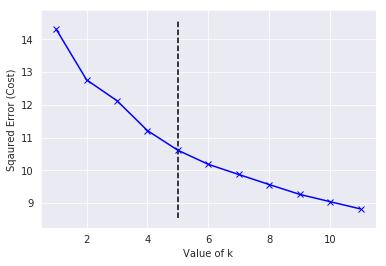

In [109]:
# cluster dataset
newyork_grouped_food_clustering = newyork_grouped_food.drop('Neighborhood', 1)

cost =[] 
for i in range(1, 12): 
    KM = KMeans(n_clusters = i, random_state=0) 
    KM.fit(newyork_grouped_food_clustering)       
    cost.append(KM.inertia_)  
    
print("Sqaured Error (Cost)", cost)
  
k = range(1, len(cost)+1)

kn = KneeLocator(k, cost, curve='convex', direction='decreasing')
n_food_knee = kn.knee
print("Elbow Point", n_food_knee)
plt.xlabel('Value of k')
plt.ylabel('Sqaured Error (Cost)')
plt.plot(k, cost, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [110]:
"As the Elbow Point turns out to be {}, we'll run *k*-means to cluster the neighborhood into {} clusters".format(n_food_knee, n_food_knee)

"As the Elbow Point turns out to be 5, we'll run *k*-means to cluster the neighborhood into 5 clusters"

In [111]:
# set number of clusters
kclusters = n_food_knee

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_food_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 2, 4, 2, 4, 0, 2, 0, 4], dtype=int32)

In [112]:
# drop clustering labels if already inserted
# newyork_neighborhoods_food_venues_sorted = newyork_neighborhoods_food_venues_sorted.drop('Cluster Labels', axis=1)

# add clustering labels
newyork_neighborhoods_food_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# toronto_neighborhoods_with_no_food_indices do not have any Food venues 1000 meters around it, so let's drop them.
# execute the following line just once
newyork_merged_food = df_newyork_neighborhoods.drop(df_newyork_neighborhoods.index[newyork_neighborhoods_with_no_food_indices])

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_merged_food = newyork_merged_food.join(newyork_neighborhoods_food_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newyork_merged_food.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201               1   
1   Bronx   Co-op City  40.874294 -73.829939               4   
2   Bronx  Eastchester  40.887556 -73.827806               1   
3   Bronx    Fieldston  40.895437 -73.905643               4   
4   Bronx    Riverdale  40.890834 -73.912585               0   

  1st Most Common Food Venue 2nd Most Common Food Venue  \
0              Deli / Bodega                Pizza Place   
1                Pizza Place              Deli / Bodega   
2       Caribbean Restaurant                Pizza Place   
3              Deli / Bodega                Pizza Place   
4                Pizza Place         Italian Restaurant   

  3rd Most Common Food Venue 4th Most Common Food Venue  \
0       Fast Food Restaurant       Caribbean Restaurant   
1         Chinese Restaurant       Fast Food Restaurant   
2                      Diner              Deli / Bodega   
3             Sandwich Place         Chinese Restaurant   
4         Mexican Restaurant                       Café   

  5th Most Common Food Venue 6th Most Common Food Venue  \
0         Chinese Restaurant        Fried Chicken Joint   
1                     Bakery                  BBQ Joint   
2             Sandwich Place       Fast Food Restaurant   
3         Mexican Restaurant                 Food Truck   
4                 Food Truck              Deli / Bodega   

  7th Most Common Food Venue 8th Most Common Food Venue  \
0                       Food                 Donut Shop   
1                       Food         Mexican Restaurant   
2         Chinese Restaurant                       Café   
3                 Donut Shop                 Restaurant   
4                 Restaurant             Sandwich Place   

  9th Most Common Food Venue 10th Most Common Food Venue  
0           Asian Restaurant                      Bakery  
1         Seafood Restaurant         Fried Chicken Joint  
2                 Donut Shop            Asian Restaurant  
3       Fast Food Restaurant                        Café  
4         Chinese Restaurant                        Food

Let's use 'geopy' now to get the latitude and longitude values of 'New York City, USA'. We'll need this to create the map.

In [113]:
newyork_address = 'New York City, NY, USA'

newyork_geolocator = Nominatim(user_agent="my-application")
newyork_location = newyork_geolocator.geocode(newyork_address)
newyork_latitude = newyork_location.latitude
newyork_longitude = newyork_location.longitude
print('The geograpical coordinates (newyork_latitude, newyork_longitude) of "New York City, NY, USA" are ({}, {}).'.format(newyork_latitude, newyork_longitude))

The geograpical coordinates (newyork_latitude, newyork_longitude) of "New York City, NY, USA" are (40.7127281, -74.0060152).


Let's visualize the resulting clusters now.

In [114]:
# create map
map_clusters = folium.Map(location=[newyork_latitude, newyork_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged_food['Latitude'], newyork_merged_food['Longitude'], newyork_merged_food['Neighborhood'], newyork_merged_food['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label, #map not rendering with popup specified
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, let's examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

In [115]:
# Cluster 0
newyork_merged_food.loc[newyork_merged_food['Cluster Labels'] == 0, newyork_merged_food.columns[[1] + list(range(5, newyork_merged_food.shape[1]))]]

Neighborhood       1st Most Common Food Venue  \
4               Riverdale                      Pizza Place   
35         Spuyten Duyvil                      Pizza Place   
46              Bay Ridge                      Pizza Place   
49             Greenpoint                      Pizza Place   
51         Brighton Beach                       Restaurant   
52         Sheepshead Bay                 Sushi Restaurant   
58        Windsor Terrace                    Deli / Bodega   
59       Prospect Heights              American Restaurant   
61           Williamsburg                      Pizza Place   
62               Bushwick               Mexican Restaurant   
64       Brooklyn Heights                      Pizza Place   
65            Cobble Hill               Italian Restaurant   
66        Carroll Gardens               Italian Restaurant   
68                Gowanus               Italian Restaurant   
69            Fort Greene               Italian Restaurant   
70             Park Slope                      Pizza Place   
77        Manhattan Beach               Italian Restaurant   
81          Dyker Heights               Chinese Restaurant   
84           Clinton Hill                      Pizza Place   
86               Downtown                           Bakery   
87            Boerum Hill                      Pizza Place   
95      East Williamsburg               Mexican Restaurant   
96             North Side              American Restaurant   
97             South Side                      Pizza Place   
98          Ocean Parkway                      Pizza Place   
99          Fort Hamilton                      Pizza Place   
100             Chinatown               Chinese Restaurant   
104        Manhattanville                    Deli / Bodega   
105        Central Harlem  Southern / Soul Food Restaurant   
106           East Harlem                      Pizza Place   
107       Upper East Side               Italian Restaurant   
108             Yorkville               Italian Restaurant   
109            Lenox Hill               Italian Restaurant   
111       Upper West Side               Italian Restaurant   
112        Lincoln Square               Italian Restaurant   
113               Clinton               Italian Restaurant   
114               Midtown                   Sandwich Place   
115           Murray Hill                Korean Restaurant   
116               Chelsea               Italian Restaurant   
117     Greenwich Village               Italian Restaurant   
118          East Village                      Pizza Place   
119       Lower East Side               Italian Restaurant   
120               Tribeca               Italian Restaurant   
121          Little Italy                             Café   
122                  Soho               Italian Restaurant   
123          West Village               Italian Restaurant   
124      Manhattan Valley                      Pizza Place   
125   Morningside Heights               Chinese Restaurant   
126              Gramercy               Italian Restaurant   
127     Battery Park City               Italian Restaurant   
128    Financial District              American Restaurant   
129               Astoria                 Greek Restaurant   
130              Woodside                Indian Restaurant   
131       Jackson Heights               Mexican Restaurant   
132              Elmhurst                  Thai Restaurant   
135          Forest Hills                           Bakery   
139      Long Island City                             Café   
140             Sunnyside                    Deli / Bodega   
141         East Elmhurst                             Café   
151               Bayside                Korean Restaurant   
152            Auburndale                Korean Restaurant   
155             Glen Oaks                Indian Restaurant   
161       Oakland Gardens                Korean Restaurant   
173              Steinway                    

In [116]:
# Cluster 1
newyork_merged_food.loc[newyork_merged_food['Cluster Labels'] == 1, newyork_merged_food.columns[[1] + list(range(5, newyork_merged_food.shape[1]))]]

Neighborhood 1st Most Common Food Venue  \
0                    Wakefield              Deli / Bodega   
2                  Eastchester       Caribbean Restaurant   
9               Williamsbridge                Pizza Place   
45                    Edenwald                Pizza Place   
54                    Flatbush       Caribbean Restaurant   
56               East Flatbush       Caribbean Restaurant   
74                    Canarsie       Caribbean Restaurant   
75                   Flatlands              Deli / Bodega   
88   Prospect Lefferts Gardens       Caribbean Restaurant   
93         Prospect Park South              Deli / Bodega   
165                 St. Albans         Chinese Restaurant   
168            Cambria Heights       Caribbean Restaurant   
169                   Rosedale       Caribbean Restaurant   
188                  Laurelton       Caribbean Restaurant   
193                 Brookville              Deli / Bodega   
207                 Port Ivory                Snack Place   
221                Ditmas Park              Deli / Bodega   
222                    Wingate       Caribbean Restaurant   
223                      Rugby       Caribbean Restaurant   
259             Remsen Village       Caribbean Restaurant   
261            Paerdegat Basin       Caribbean Restaurant   
300                    Erasmus       Caribbean Restaurant   

    2nd Most Common Food Venue 3rd Most Common Food Venue  \
0                  Pizza Place       Fast Food Restaurant   
2                  Pizza Place                      Diner   
9         Caribbean Restaurant              Deli / Bodega   
45          Chinese Restaurant       Caribbean Restaurant   
54                 Pizza Place              Deli / Bodega   
56               Deli / Bodega                 Restaurant   
74                        Food              Deli / Bodega   
75        Caribbean Restaurant        Fried Chicken Joint   
88                 Pizza Place                     Bakery   
93        Caribbean Restaurant                Pizza Place   
165       Caribbean Restaurant              Deli / Bodega   
168                 Donut Shop                Pizza Place   
169        Fried Chicken Joint        American Restaurant   
188              Deli / Bodega         Chinese Restaurant   
193                     Bakery                Pizza Place   
207        American Restaurant       Caribbean Restaurant   
221       Caribbean Restaurant         Mexican Restaurant   
222                Pizza Place              Deli / Bodega   
223                Pizza Place                       Food   
259         Chinese Restaurant                       Food   
261              Deli / Bodega                       Food   
300              Deli / Bodega         Chinese Restaurant   

    4th Most Common Food Venue 5th Most Common Food Venue  \
0         Caribbean Restaurant         Chinese Restaurant   
2                Deli / Bodega             Sandwich Place   
9          Fried Chicken Joint         Chinese Restaurant   
45        Fast Food Restaurant                     Bakery   
54          Chinese Restaurant         Mexican Restaurant   
56                 Pizza Place                 Food Truck   
74                 Pizza Place         Mexican Restaurant   
75                 Pizza Place         Chinese Restaurant   
88               Deli / Bodega                       Café   
93          Mexican Restaurant                     Bakery   
165         Seafood Restaurant                Pizza Place   
168         Chinese Restaurant       Fast Food Restaurant   
169             Sandwich Place         Chinese Restaurant   
188                 Restaurant                 Donut Shop   
193         Chinese Restaurant       Fast Food Restaurant   
207         Falafel Restaurant                Wings Joint   
221                Pizza Place        Fried Chicken Joint   
222                     Bakery       Fast Food Restaurant   
223        Fried Chicken Joint              Deli / 

In [117]:
# Cluster 2
newyork_merged_food.loc[newyork_merged_food['Cluster Labels'] == 2, newyork_merged_food.columns[[1] + list(range(5, newyork_merged_food.shape[1]))]]

Neighborhood 1st Most Common Food Venue 2nd Most Common Food Venue  \
12         City Island         Seafood Restaurant              Deli / Bodega   
28         Throgs Neck         Italian Restaurant              Deli / Bodega   
34             Belmont         Italian Restaurant                Pizza Place   
37          Pelham Bay              Deli / Bodega         Italian Restaurant   
39      Edgewater Park         Italian Restaurant              Deli / Bodega   
91        Bergen Beach           Sushi Restaurant                 Donut Shop   
94          Georgetown         Chinese Restaurant         Italian Restaurant   
133       Howard Beach         Italian Restaurant         Chinese Restaurant   
150         Whitestone         Italian Restaurant                 Donut Shop   
153        Little Neck         Chinese Restaurant         Italian Restaurant   
154         Douglaston         Chinese Restaurant         Italian Restaurant   
174         Beechhurst         Italian Restaurant                 Donut Shop   
175        Bay Terrace         Italian Restaurant                 Donut Shop   
179           Neponsit              Deli / Bodega                     Bakery   
187         Lindenwood                Pizza Place         Italian Restaurant   
190       Belle Harbor              Deli / Bodega                 Bagel Shop   
200           Rosebank              Deli / Bodega         Italian Restaurant   
208  Castleton Corners                Pizza Place              Deli / Bodega   
210             Travis         Italian Restaurant              Deli / Bodega   
211           New Dorp                Pizza Place         Italian Restaurant   
212            Oakwood                 Bagel Shop              Deli / Bodega   
213        Great Kills         Italian Restaurant                Pizza Place   
214        Eltingville                Pizza Place         Italian Restaurant   
216            Woodrow                 Donut Shop         Italian Restaurant   
217        Tottenville         Italian Restaurant              Deli / Bodega   
224          Park Hill                Pizza Place              Deli / Bodega   
228           Arrochar              Deli / Bodega                Pizza Place   
229           Grasmere              Deli / Bodega         Italian Restaurant   
230           Old Town         Italian Restaurant                Pizza Place   
231       Dongan Hills         Italian Restaurant                Pizza Place   
235        Bay Terrace         Italian Restaurant                 Donut Shop   
236           Huguenot         Italian Restaurant              Deli / Bodega   
240          Rossville                Pizza Place                 Bagel Shop   
241      Arden Heights                       Food         Mexican Restaurant   
242         Greenridge           Asian Restaurant                 Bagel Shop   
251      Richmond Town         Italian Restaurant                 Bagel Shop   
252        Shore Acres              Deli / Bodega         Italian Restaurant   
254            Concord         Italian Restaurant              Deli / Bodega   
255       Emerson Hill                       Food         Italian Restaurant   
266    Astoria Heights              Deli / Bodega         Italian Restaurant   
286       Sandy Ground                 Bagel Shop                 Donut Shop   
287        Egbertville              Deli / Bodega                 Bagel Shop   
291       Prince's Bay         Italian Restaurant                Pizza Place   
292    Lighthouse Hill         Italian Restaurant                 Bagel Shop   

    3rd Most Common Food Venue 4th Most Common Food Venue  \
12          Italian Restaurant        American Restaurant   
28          Chinese Restaurant                Pizza Place   
34               Deli / Bodega             Sandwich Place   
37        Fast Food Restaurant         Chinese Restaurant   
39                 Pizza Place         Chinese Restaurant   
91          Italian Restaurant             

In [118]:
# Cluster 3
newyork_merged_food.loc[newyork_merged_food['Cluster Labels'] == 3, newyork_merged_food.columns[[1] + list(range(5, newyork_merged_food.shape[1]))]]

Neighborhood 1st Most Common Food Venue 2nd Most Common Food Venue  \
203    Todt Hill                 Donut Shop                Wings Joint   

    3rd Most Common Food Venue 4th Most Common Food Venue  \
203       Ethiopian Restaurant                       Food   

    5th Most Common Food Venue 6th Most Common Food Venue  \
203          Fondue Restaurant          Fish & Chips Shop   

    7th Most Common Food Venue 8th Most Common Food Venue  \
203        Filipino Restaurant       Fast Food Restaurant   

    9th Most Common Food Venue 10th Most Common Food Venue  
203         Falafel Restaurant          English Restaurant

In [119]:
# Cluster 3
newyork_merged_food.loc[newyork_merged_food['Cluster Labels'] == 3, newyork_merged_food.columns[[1] + list(range(5, newyork_merged_food.shape[1]))]]

Neighborhood 1st Most Common Food Venue 2nd Most Common Food Venue  \
203    Todt Hill                 Donut Shop                Wings Joint   

    3rd Most Common Food Venue 4th Most Common Food Venue  \
203       Ethiopian Restaurant                       Food   

    5th Most Common Food Venue 6th Most Common Food Venue  \
203          Fondue Restaurant          Fish & Chips Shop   

    7th Most Common Food Venue 8th Most Common Food Venue  \
203        Filipino Restaurant       Fast Food Restaurant   

    9th Most Common Food Venue 10th Most Common Food Venue  
203         Falafel Restaurant          English Restaurant

In [120]:
# Cluster 4
newyork_merged_food.loc[newyork_merged_food['Cluster Labels'] == 4, newyork_merged_food.columns[[1] + list(range(5, newyork_merged_food.shape[1]))]]

Neighborhood 1st Most Common Food Venue  \
1             Co-op City                Pizza Place   
3              Fieldston              Deli / Bodega   
5            Kingsbridge                Pizza Place   
6            Marble Hill                Pizza Place   
7               Woodlawn              Deli / Bodega   
8                Norwood                Pizza Place   
10            Baychester                Pizza Place   
11        Pelham Parkway                Pizza Place   
13          Bedford Park                Pizza Place   
14    University Heights                Pizza Place   
15        Morris Heights                Pizza Place   
16               Fordham                Pizza Place   
17          East Tremont                Pizza Place   
18            West Farms                Pizza Place   
19          High  Bridge             Sandwich Place   
20               Melrose                Pizza Place   
21            Mott Haven                Pizza Place   
22           Port Morris                Pizza Place   
23              Longwood                Pizza Place   
24           Hunts Point                       Food   
25            Morrisania       Fast Food Restaurant   
26             Soundview       Fast Food Restaurant   
27          Clason Point                Wings Joint   
29          Country Club              Deli / Bodega   
30           Parkchester                Pizza Place   
31    Westchester Square                Pizza Place   
32              Van Nest              Deli / Bodega   
33           Morris Park                Pizza Place   
36       North Riverdale                Pizza Place   
38         Schuylerville                Pizza Place   
40           Castle Hill                Pizza Place   
41             Olinville                Pizza Place   
42        Pelham Gardens              Deli / Bodega   
43             Concourse              Deli / Bodega   
44             Unionport                Pizza Place   
47           Bensonhurst         Chinese Restaurant   
48           Sunset Park         Chinese Restaurant   
50             Gravesend         Chinese Restaurant   
53     Manhattan Terrace                Pizza Place   
55         Crown Heights              Deli / Bodega   
57            Kensington                Pizza Place   
60           Brownsville                Pizza Place   
63    Bedford Stuyvesant              Deli / Bodega   
67              Red Hook              Deli / Bodega   
71         Cypress Hills                Pizza Place   
72         East New York         Chinese Restaurant   
73         Starrett City                Pizza Place   
76           Mill Island               Burger Joint   
78          Coney Island                Pizza Place   
79            Bath Beach         Chinese Restaurant   
80          Borough Park                Pizza Place   
82       Gerritsen Beach              Deli / Bodega   
83           Marine Park              Deli / Bodega   
85              Sea Gate                 Donut Shop   
89            Ocean Hill              Deli / Bodega   
90             City Line                Pizza Place   
92               Midwood                Pizza Place   
101   Washington Heights                Pizza Place   
102               Inwood                Pizza Place   
103     Hamilton Heights              Deli / Bodega   
110     Roosevelt Island              Deli / Bodega   
134               Corona              Deli / Bodega   
136          Kew Gardens                Pizza Place   
137        Richmond Hill              Deli / Bodega   
138             Flushing         Chinese Restaurant   
142              Maspeth              Deli / Bodega   
143            Ridgewood              Deli / Bodega   
144             Glendale              Deli / Bodega   
145            Rego Park         Chinese Restaurant   
146            Woodhaven                Pizza Place   
147           Ozone Park                Pizza Place   
148     South Ozone Park              Deli / Bodega 

##### 3.1.TN Count Comparision of Food Venue Categories between Toronto and New York City

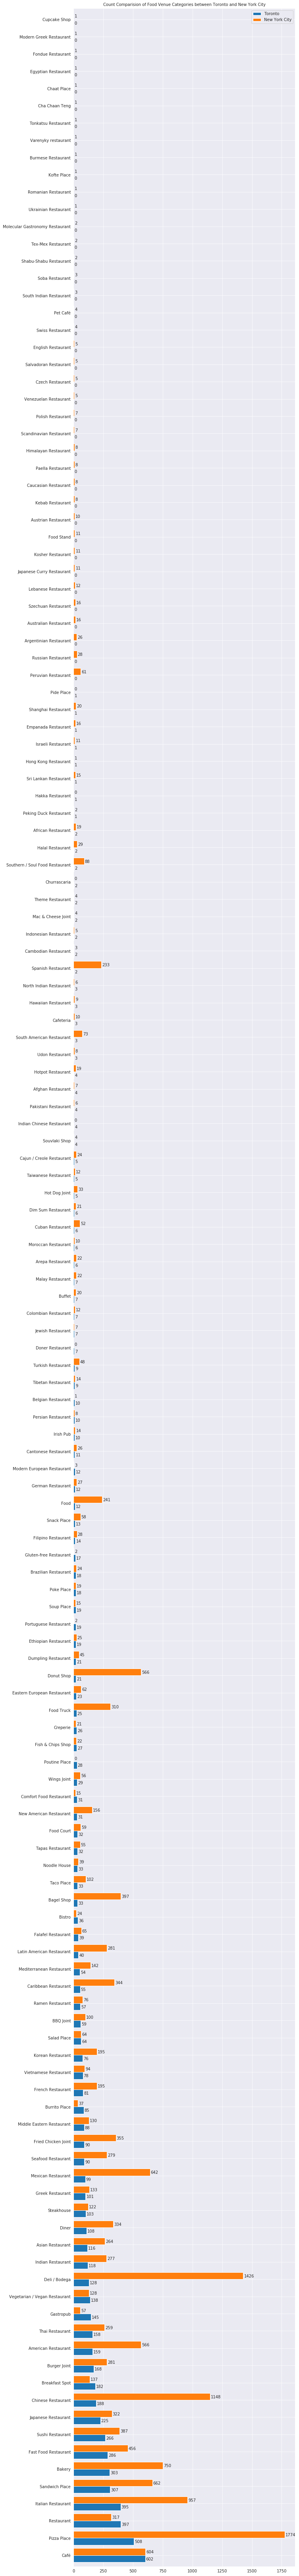

In [121]:
# creating dataframe of Toronto Food Venue Categories and their counts
ds_toronto_food_count = toronto_venues_food['Venue Category'].value_counts()
df_toronto_food_count = pd.DataFrame(ds_toronto_food_count).reset_index()
df_toronto_food_count.columns = ['Food Venue Category', 'Toronto']

# creating dataframe of New York City Food Venue Categories and their counts
ds_newyork_food_count = newyork_venues_food['Venue Category'].value_counts()
df_newyork_food_count = pd.DataFrame(ds_newyork_food_count).reset_index()
df_newyork_food_count.columns = ['Food Venue Category', 'New York City']

# creating a full outer join of the above two dataframes
df_food_tn_outer = pd.merge(df_toronto_food_count, df_newyork_food_count, on='Food Venue Category', how='outer')
df_food_tn_outer['Toronto'] = df_food_tn_outer['Toronto'].replace(np.nan, 0)
df_food_tn_outer['New York City'] = df_food_tn_outer['New York City'].replace(np.nan, 0)
df_food_tn_outer = df_food_tn_outer.astype({"Toronto": int, "New York City": int})

# creating a grouped bar plot
ax_food = df_food_tn_outer.plot(kind='barh', x='Food Venue Category', figsize=(10, 118.4), width=.8, align='center')
ax_food.set_title('Count Comparision of Food Venue Categories between Toronto and New York City', fontsize='medium')
for p in ax_food.patches:
    ax_food.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(2, 5), textcoords='offset points', fontsize=10)

ax_food.set_ylabel("")
ax_food.get_figure().savefig('df_food_tn_outer_all.png', bbox_inches = 'tight')

#### 3.2 Exploring Arts & Entertainment Venue Category in Toronto and New York City <a name="dataexploratoryanalysisae"></a>

Next, we'll explore the **Toronto** for its *Arts & Entertainment* venue categories. We'll then repeat the same analysis for New York City. 

In [122]:
# creating a new dataframe for all the Toronto Arts & Entertainment venue categories using the <code>getNearbyVenues</code> funtion
toronto_venues_ae = getNearbyVenues(names=df_postalcodes_toronto['Neighborhood'],
                                 latitudes=df_postalcodes_toronto['Latitude'],
                                 longitudes=df_postalcodes_toronto['Longitude'],
                                 categoryId='4d4b7104d754a06370d81259' # categoryId of 'Arts & Entertainment'
                                )

# let's save the dataframe to a .csv file for later use.
toronto_venues_ae.to_csv('toronto_venues_ae.csv', index=False)

In [123]:
toronto_venues_ae = pd.read_csv('toronto_venues_ae.csv')

In [124]:
print(toronto_venues_ae.shape)
toronto_venues_ae.head()

(2083, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1  Victoria Village              43.725882              -79.315572   
2  Victoria Village              43.725882              -79.315572   
3  Victoria Village              43.725882              -79.315572   
4      Harbourfront              43.654260              -79.360636   

                                  Venue  Venue Latitude  Venue Longitude  \
0                 Mrs. Claus' Sweatshop       43.753800       -79.319582   
1                               876 411       43.728933       -79.321074   
2  Frolick in the Face of Certain Death       43.721814       -79.311157   
3                Sandra Ainsley Gallery       43.719044       -79.308892   
4  Young Centre for the Performing Arts       43.650825       -79.357593   

          Venue Category  
0             Public Art  
1            Music Venue  
2                Theater  
3            Art Gallery  
4  Performing Arts Venue

##### 3.2.T.1 Neighborhoods Without Any Arts & Entertainment Venues in Toronto

Let's find number of neighborhoods in Toronto after filtering (by 'Arts & Entertainment' Venue Category)

In [125]:
toronto_neighborhoods_ae_after = toronto_venues_ae['Neighborhood'].unique()
len(toronto_neighborhoods_ae_after)

189

In [126]:
"Number of unique neighborhoods in Toronto before being filtered by Arts & Entertainment venue category was {} but after fitering it has come down to {}. Let us find out the {} neighborhoods that do not have any Arts & Entertainment venues around them.".format(len(toronto_neighborhoods_before), len(toronto_neighborhoods_ae_after), len(toronto_neighborhoods_before) - len(toronto_neighborhoods_ae_after) )

'Number of unique neighborhoods in Toronto before being filtered by Arts & Entertainment venue category was 209 but after fitering it has come down to 189. Let us find out the 20 neighborhoods that do not have any Arts & Entertainment venues around them.'

In [127]:
# Toronto neighborhoods that do not have any Arts & Entertainment venues within 500 meters around them
toronto_neighborhoods_with_no_ae = np.setdiff1d(toronto_neighborhoods_before, toronto_neighborhoods_ae_after)
toronto_neighborhoods_with_no_ae

array(['Caledonia-Fairbanks', 'Clarks Corners', 'Downsview Central',
       'Downsview Northwest', 'Downsview West', 'Emery', 'Guildwood',
       'Humberlea', 'Malvern', 'Morningside', 'Northwest', 'Rouge',
       'Scarborough Village', 'Sullivan', "Tam O'Shanter", 'Upper Rouge',
       'West Hill', 'Westmount', 'Willowdale West', 'Woburn'],
      dtype=object)

In [128]:
# Toronto neighborhoors with no Arts & Entertainment venues
df_postalcodes_toronto[df_postalcodes_toronto['Neighborhood'].isin(toronto_neighborhoods_with_no_ae)]

Borough         Neighborhood   Latitude  Longitude
8    Scarborough                Rouge  43.806686 -79.194353
9    Scarborough              Malvern  43.806686 -79.194353
32   Scarborough            Guildwood  43.763573 -79.188711
33   Scarborough          Morningside  43.763573 -79.188711
34   Scarborough            West Hill  43.763573 -79.188711
37          York  Caledonia-Fairbanks  43.689026 -79.453512
38   Scarborough               Woburn  43.770992 -79.216917
53   Scarborough  Scarborough Village  43.744734 -79.239476
83    North York       Downsview West  43.739015 -79.506944
97    North York    Downsview Central  43.728496 -79.495697
105   North York                Emery  43.724766 -79.532242
106   North York            Humberlea  43.724766 -79.532242
110   North York  Downsview Northwest  43.761631 -79.520999
125    Etobicoke            Westmount  43.696319 -79.532242
128   North York      Willowdale West  43.782736 -79.442259
146  Scarborough       Clarks Corners  43.781638 -79.304302
147  Scarborough             Sullivan  43.781638 -79.304302
148  Scarborough        Tam O'Shanter  43.781638 -79.304302
186    Etobicoke            Northwest  43.706748 -79.594054
187  Scarborough          Upper Rouge  43.836125 -79.205636

In [129]:
# indices of Toronto neighborhoors with no Arts & Entertainment venues
toronto_neighborhoods_with_no_ae_indices = df_postalcodes_toronto[df_postalcodes_toronto['Neighborhood'].isin(toronto_neighborhoods_with_no_ae)].index.values
toronto_neighborhoods_with_no_ae_indices

array([  8,   9,  32,  33,  34,  37,  38,  53,  83,  97, 105, 106, 110,
       125, 128, 146, 147, 148, 186, 187])

In [130]:
print('There are {} unique Arts & Entertainment venue categories.'.format(len(toronto_venues_ae['Venue Category'].unique())))

There are 30 unique Arts & Entertainment venue categories.


In [131]:
"Now let's find out what are the most common {} Arts & Entertainment venue categories in Toronto.".format(len(toronto_venues_ae['Venue Category'].unique()))

"Now let's find out what are the most common 30 Arts & Entertainment venue categories in Toronto."

##### 3.2.T.2 Count of Food Venues by Neighborhood and Food Venue Category in Toronto

Let's create a dataframe for the count of Toronto venues by neighborhood and Arts & Entertainment venue category.

In [132]:
toronto_venues_ae_freq_by_neighborhood_and_ae_vc = toronto_venues_ae.groupby(['Neighborhood', 'Venue Category'])['Venue Category'].count().reset_index(name="Count")
toronto_venues_ae_freq_by_neighborhood_and_ae_vc = toronto_venues_ae_freq_by_neighborhood_and_ae_vc.rename(columns = {"Venue Category": "Arts & Entertainment Venue Category"}) 
toronto_venues_ae_freq_by_neighborhood_and_ae_vc.head()

Neighborhood Arts & Entertainment Venue Category  Count
0     Adelaide                         Art Gallery     16
1     Adelaide                          Art Museum      1
2     Adelaide                Arts & Entertainment      2
3     Adelaide                         Comedy Club      3
4     Adelaide                        Concert Hall      5

##### 3.2.T.3 Count of Arts & Entertainment Venues in Each Borough of Toronto

Let's now find count of the Arts & Entertainment Venues in each Borough of Toronto. But to do that we need to add the borough of each neighborhood in our dataframe first.

In [133]:
# joining 'toronto_venues_food_freq_by_neighborhood_and_ae_vc' with 'df_postalcodes_toronto' to add 'Borough' in the dataframe
df_toronto_venues_ae_freq_by_borough = toronto_venues_ae_freq_by_neighborhood_and_ae_vc.join(df_postalcodes_toronto.set_index('Neighborhood'), on='Neighborhood')
df_toronto_venues_ae_freq_by_borough.head()

Neighborhood Arts & Entertainment Venue Category  Count           Borough  \
0     Adelaide                         Art Gallery     16  Downtown Toronto   
1     Adelaide                          Art Museum      1  Downtown Toronto   
2     Adelaide                Arts & Entertainment      2  Downtown Toronto   
3     Adelaide                         Comedy Club      3  Downtown Toronto   
4     Adelaide                        Concert Hall      5  Downtown Toronto   

    Latitude  Longitude  
0  43.650571 -79.384568  
1  43.650571 -79.384568  
2  43.650571 -79.384568  
3  43.650571 -79.384568  
4  43.650571 -79.384568

In [134]:
# showing the 'Count of Arts & Entertainment Venues' for each 'Borough'
toronto_venues_ae_freq_by_borough = df_toronto_venues_ae_freq_by_borough.groupby(['Borough'])['Arts & Entertainment Venue Category'].count().reset_index(name="Arts & Entertainment Venues")
toronto_venues_ae_freq_by_borough = toronto_venues_ae_freq_by_borough.sort_values(by='Arts & Entertainment Venues', ascending=False)
toronto_venues_ae_freq_by_borough

Borough  Arts & Entertainment Venues
1   Downtown Toronto                          381
4          Etobicoke                          109
0    Central Toronto                           87
6         North York                           75
9       West Toronto                           66
2       East Toronto                           35
8        Scarborough                           35
10              York                           24
3          East York                           18
7       Queen's Park                           12
5        Mississauga                            4

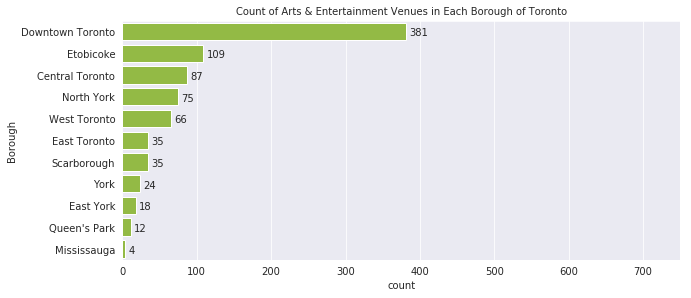

In [135]:
fig = plt.figure(figsize=(10, 4.4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Borough", x="Arts & Entertainment Venues", data=toronto_venues_ae_freq_by_borough, color="yellowgreen")
ax.set_xlim(0, 750)
plt.title("Count of Arts & Entertainment Venues in Each Borough of Toronto", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Borough")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('toronto_venues_ae_freq_by_borough.png', bbox_inches = 'tight')
plt.show()

##### 3.2.T.4 Count of Arts & Entertainment Venues in Each Neighborhood of Toronto

Let's create a dataframe for the count of Toronto Arts & Entertainment venues by neighborhood.

In [136]:
toronto_venues_ae_freq_by_neighborhood = toronto_venues_ae.groupby(['Neighborhood'])['Venue Category'].count().reset_index(name='Arts & Entertainment Venues')
toronto_venues_ae_freq_by_neighborhood = toronto_venues_ae_freq_by_neighborhood.sort_values(by='Arts & Entertainment Venues', ascending=False)
toronto_venues_ae_freq_by_neighborhood.head()

Neighborhood  Arts & Entertainment Venues
0                   Adelaide                           69
127                 Richmond                           69
79                      King                           69
34           Design Exchange                           65
167  Toronto Dominion Centre                           65

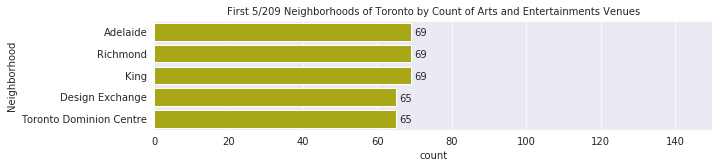

In [137]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Neighborhood", x="Arts & Entertainment Venues", data=toronto_venues_ae_freq_by_neighborhood.head(5), color="y")
ax.set_xlim(0, 150)
plt.title("First 5/209 Neighborhoods of Toronto by Count of Arts and Entertainments Venues", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Neighborhood")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('toronto_venues_ae_freq_by_neighborhood_first_5.png', bbox_inches = 'tight')
plt.show()

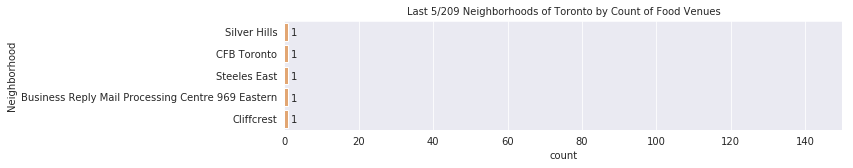

In [138]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Neighborhood", x="Arts & Entertainment Venues", data=toronto_venues_ae_freq_by_neighborhood.tail(5), color="sandybrown")
ax.set_xlim(0, 150)
plt.title("Last 5/209 Neighborhoods of Toronto by Count of Food Venues", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Neighborhood")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('toronto_venues_ae_freq_by_neighborhood_last_5.png', bbox_inches = 'tight')
plt.show()

##### 3.2.T.5 Count of Arts & Entertainment Venues of Each Arts & Entertainment Venue Category in Toronto

Let's find out the count of Arts & Entertainment Venue Categories in the neighborhoods of Toronoto.

In [139]:
toronto_venues_ae_vc = toronto_venues_ae['Venue Category'].value_counts().to_frame(name='Count').reset_index()
toronto_venues_ae_vc = toronto_venues_ae_vc.rename(columns = {"index": "Arts & Entertainment Venue Category"}) 
toronto_venues_ae_vc.head()

Arts & Entertainment Venue Category  Count
0                         Art Gallery    450
1                       Movie Theater    305
2                         Music Venue    295
3                             Theater    248
4                        Dance Studio    182

Let's create a simple bar plot of the count of 'Arts & Entertainment' venue categories  in *Toronto*.

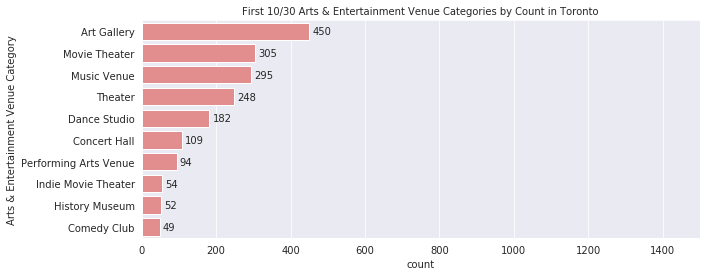

In [140]:
fig = plt.figure(figsize=(10,4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Arts & Entertainment Venue Category", x="Count", data=toronto_venues_ae_vc.head(10), color='lightcoral')
ax.set_xlim(0, 1500)
plt.title("First 10/30 Arts & Entertainment Venue Categories by Count in Toronto", fontsize="medium")
plt.xlabel("count")
plt.ylabel ("Arts & Entertainment Venue Category")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')
    
fig.savefig('toronto_venues_ae_vc_head_10.png', bbox_inches = 'tight')
plt.show()

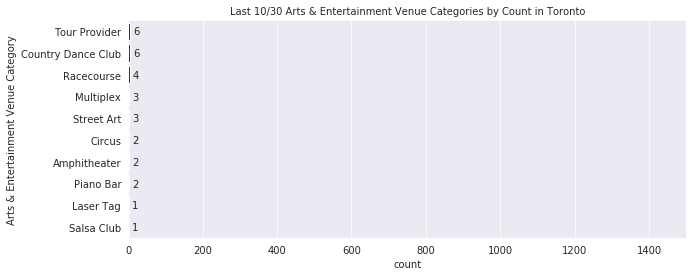

In [141]:
fig = plt.figure(figsize=(10,4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Arts & Entertainment Venue Category", x="Count", data=toronto_venues_ae_vc.tail(10), color='blue')
ax.set_xlim(0, 1500)
plt.title("Last 10/30 Arts & Entertainment Venue Categories by Count in Toronto", fontsize="medium")
plt.xlabel("count")
plt.ylabel ("Arts & Entertainment Venue Category")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')
    
fig.savefig('toronto_venues_ae_vc_tail_10.png', bbox_inches = 'tight')
plt.show()

Now, let's do the same analysis of 'Arts & Entertainment' Venue Category for **New York City**.

In [142]:
# creating a new dataframe for all the New York City Arts & Entertainment venue categories using the <code>getNearbyVenues</code> funtion
newyork_venues_ae = getNearbyVenues(names=df_newyork_neighborhoods['Neighborhood'],
                                 latitudes=df_newyork_neighborhoods['Latitude'],
                                 longitudes=df_newyork_neighborhoods['Longitude'],
                                 categoryId='4d4b7104d754a06370d81259' # categoryId of 'Arts & Entertainment'
                                )

# let's save the dataframe to a .csv file for later use.
newyork_venues_ae.to_csv('newyork_venues_ae.csv', index=False)

In [143]:
newyork_venues_ae = pd.read_csv('newyork_venues_ae.csv')

In [144]:
print(newyork_venues_ae.shape)
newyork_venues_ae.head()

(4984, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

                      Venue  Venue Latitude  Venue Longitude Venue Category  
0        Grene Diamonds Inc       40.894507       -73.845235     Salsa Club  
1            The Upper Room       40.892567       -73.846406    Music Venue  
2           Dyme Life Radio       40.894541       -73.843266    Music Venue  
3  Major League Music Group       40.891367       -73.850088    Music Venue  
4                  Par-City       40.890211       -73.847002    Music Venue

##### 3.2.N.1 Neighborhoods Without Any Food Venues in New York City

Let's find number of neighborhoods in New York City after filtering (by 'Arts & Entertainment' Venue Category)

In [145]:
newyork_neighborhoods_ae_after = newyork_venues_ae['Neighborhood'].unique()
len(newyork_neighborhoods_ae_after)

292

In [146]:
"Number of unique neighborhoods in New York City before being filtered by Arts & Entertainment venue category was {} but after fitering it has come down to {}. Let us find out the {} neighborhoods that do not have any Arts & Entertainment venues around them.".format(len(newyork_neighborhoods_before), len(newyork_neighborhoods_ae_after), len(newyork_neighborhoods_before) - len(newyork_neighborhoods_ae_after) )

'Number of unique neighborhoods in New York City before being filtered by Arts & Entertainment venue category was 302 but after fitering it has come down to 292. Let us find out the 10 neighborhoods that do not have any Arts & Entertainment venues around them.'

In [147]:
# New York City neighborhoods that do not have any Arts & Entertainment venues within 1000 meters around them
newyork_neighborhoods_with_no_ae = np.setdiff1d(newyork_neighborhoods_before, newyork_neighborhoods_ae_after)
newyork_neighborhoods_with_no_ae

array(['Arlington', 'Arverne', 'Bayswater', 'Bloomfield', 'Breezy Point',
       'Howland Hook', 'Mill Island', 'Neponsit', 'Port Ivory',
       'Todt Hill'], dtype=object)

In [148]:
# New York City neighborhoors with no Arts & Entertainment venues within 1000 meters around them
df_newyork_neighborhoods[df_newyork_neighborhoods['Neighborhood'].isin(newyork_neighborhoods_with_no_ae)]

Borough  Neighborhood   Latitude  Longitude
76        Brooklyn   Mill Island  40.606336 -73.908186
172         Queens  Breezy Point  40.557401 -73.925512
177         Queens       Arverne  40.589144 -73.791992
179         Queens      Neponsit  40.572037 -73.857547
203  Staten Island     Todt Hill  40.597069 -74.111329
207  Staten Island    Port Ivory  40.639683 -74.174645
227  Staten Island     Arlington  40.635325 -74.165104
245  Staten Island    Bloomfield  40.605779 -74.187256
257  Staten Island  Howland Hook  40.638433 -74.186223
303         Queens     Bayswater  40.611322 -73.765968

In [149]:
# indices of New York City neighborhoors with no Arts & Entertainment venues within 1000 meters around them
newyork_neighborhoods_with_no_ae_indices = df_newyork_neighborhoods[df_newyork_neighborhoods['Neighborhood'].isin(newyork_neighborhoods_with_no_ae)].index.values
newyork_neighborhoods_with_no_ae_indices

array([ 76, 172, 177, 179, 203, 207, 227, 245, 257, 303])

In [150]:
print('There are {} unique Arts & Entertainment venue categories.'.format(len(newyork_venues_ae['Venue Category'].unique())))

There are 37 unique Arts & Entertainment venue categories.


In [151]:
"Now let's find out what are the most common {} Arts & Entertainment venue categories in New York City.".format(len(newyork_venues_ae['Venue Category'].unique()))

"Now let's find out what are the most common 37 Arts & Entertainment venue categories in New York City."

In [152]:
##### 3.2.N.2 Count of Arts & Entertainment Venues by Neighborhood and Food Venue Category in New York City 

Let's create a dataframe for the count of New York City venues by neighborhood and Arts & Entertainment venue category.

In [153]:
newyork_venues_ae_freq_by_neighborhood_and_ae_vc = newyork_venues_ae.groupby(['Neighborhood', 'Venue Category'])['Venue Category'].count().reset_index(name="Count")
newyork_venues_ae_freq_by_neighborhood_and_ae_vc = newyork_venues_ae_freq_by_neighborhood_and_ae_vc.rename(columns = {"Venue Category": "Arts & Entertainment Venue Category"}) 
newyork_venues_ae_freq_by_neighborhood_and_ae_vc.head()

Neighborhood Arts & Entertainment Venue Category  Count
0       Allerton                  Country Dance Club      1
1       Allerton                        Dance Studio      2
2       Allerton                         Music Venue      1
3       Annadale                        Dance Studio      1
4  Arden Heights                         Art Gallery      1

##### 3.2.N.3 Count of Arts & Entertainment Venues in each Borough of New York City

Let's now find count of the Arts & Entertainment Venues in each Borough of New York City. But to do that we need to add the borough of each neighborhood in our dataframe first.

In [154]:
# joining 'newyork_venues_ae_freq_by_neighborhood_and_ae_vc' with 'df_newyork_neighborhoods' to add 'Borough' in the dataframe
df_newyork_venues_ae_freq_by_borough = newyork_venues_ae_freq_by_neighborhood_and_ae_vc.join(df_newyork_neighborhoods.set_index('Neighborhood'), on='Neighborhood')
df_newyork_venues_ae_freq_by_borough.head(5)

Neighborhood Arts & Entertainment Venue Category  Count        Borough  \
0       Allerton                  Country Dance Club      1          Bronx   
1       Allerton                        Dance Studio      2          Bronx   
2       Allerton                         Music Venue      1          Bronx   
3       Annadale                        Dance Studio      1  Staten Island   
4  Arden Heights                         Art Gallery      1  Staten Island   

    Latitude  Longitude  
0  40.865788 -73.859319  
1  40.865788 -73.859319  
2  40.865788 -73.859319  
3  40.538114 -74.178549  
4  40.549286 -74.185887

In [155]:
# showing the 'Count of Arts & Entertainment Venues' for each 'Borough' in New York City
newyork_venues_ae_freq_by_borough = df_newyork_venues_ae_freq_by_borough.groupby(['Borough'])['Arts & Entertainment Venue Category'].count().reset_index(name="Arts & Entertainment Venues")
newyork_venues_ae_freq_by_borough = newyork_venues_ae_freq_by_borough.sort_values(by='Arts & Entertainment Venues', ascending=False)
newyork_venues_ae_freq_by_borough

Borough  Arts & Entertainment Venues
2      Manhattan                          581
1       Brooklyn                          432
3         Queens                          306
0          Bronx                          196
4  Staten Island                          181

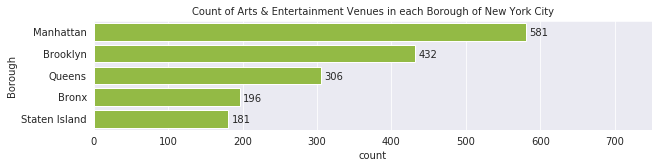

In [156]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Borough", x="Arts & Entertainment Venues", data=newyork_venues_ae_freq_by_borough, color='yellowgreen')
ax.set_xlim(0, 750)
plt.title("Count of Arts & Entertainment Venues in each Borough of New York City", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Borough")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('newyork_venues_ae_freq_by_borough.png', bbox_inches = 'tight')
plt.show()

##### 3.2.N.4 Count of Arts & Entertainment Venues in Each Neighborhood of  New York City 

In [157]:
newyork_venues_ae_freq_by_neighborhood = newyork_venues_ae.groupby(['Neighborhood'])['Venue Category'].count().reset_index(name='Arts & Entertainment Venues')
newyork_venues_ae_freq_by_neighborhood = newyork_venues_ae_freq_by_neighborhood.sort_values(by='Arts & Entertainment Venues', ascending=False)
newyork_venues_ae_freq_by_neighborhood.head()

Neighborhood  Arts & Entertainment Venues
44          Chelsea                          105
240            Soho                          100
147  Lincoln Square                          100
45        Chinatown                          100
278    West Village                          100

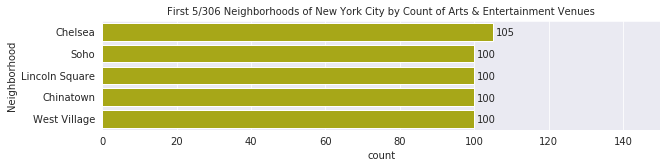

In [158]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Neighborhood", x="Arts & Entertainment Venues", data=newyork_venues_ae_freq_by_neighborhood.head(5), color="y")
ax.set_xlim(0, 150)
plt.title("First 5/306 Neighborhoods of New York City by Count of Arts & Entertainment Venues", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Neighborhood")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('newyork_venues_ae_freq_by_neighborhood_first_5.png', bbox_inches = 'tight')
plt.show()

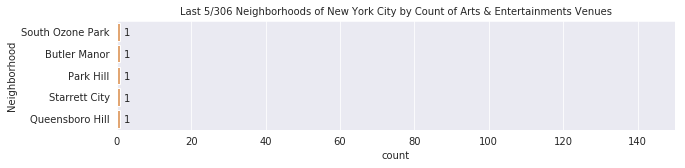

In [159]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Neighborhood", x="Arts & Entertainment Venues", data=newyork_venues_ae_freq_by_neighborhood.tail(5), color="sandybrown")
ax.set_xlim(0, 150)
plt.title("Last 5/306 Neighborhoods of New York City by Count of Arts & Entertainments Venues", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Neighborhood")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('newyork_venues_ae_freq_by_neighborhood_last_5.png', bbox_inches = 'tight')
plt.show()

##### 3.2.N.5 Count of Arts & Entertainment Venues of Each Arts & Entertainment Venue Category in New York City

Let's find out the count of Arts & Entertainment Venue Categories in the neighborhoods of New York City.

In [160]:
newyork_venues_ae_vc = newyork_venues_ae['Venue Category'].value_counts().to_frame(name='Count').reset_index()
newyork_venues_ae_vc = newyork_venues_ae_vc.rename(columns = {"index": "Arts & Entertainment Venue Category"}) 
newyork_venues_ae_vc.head()

Arts & Entertainment Venue Category  Count
0                         Art Gallery   1418
1                        Dance Studio    631
2                             Theater    538
3                         Music Venue    504
4               Performing Arts Venue    247

Let's create a simple bar plot of the count of 'Arts & Entertainment' venue categories  in *New York City*.

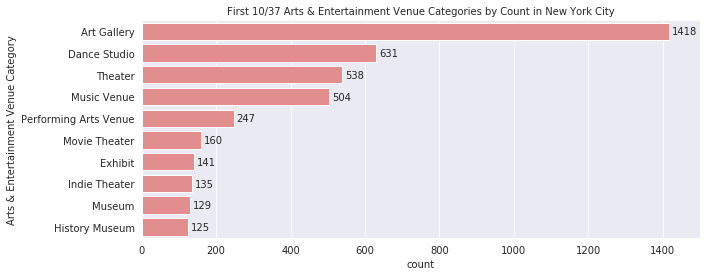

In [161]:
fig = plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Arts & Entertainment Venue Category", x="Count", data=newyork_venues_ae_vc.head(10), color="lightcoral")
ax.set_xlim(0, 1500)
plt.title("First 10/37 Arts & Entertainment Venue Categories by Count in New York City", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Arts & Entertainment Venue Category")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')
fig.savefig('newyork_venues_ae_vc_head_10.png', bbox_inches = 'tight')
plt.show()

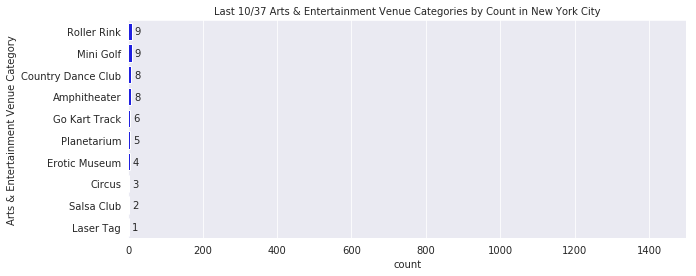

In [162]:
fig = plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Arts & Entertainment Venue Category", x="Count", data=newyork_venues_ae_vc.tail(10), color="blue")
ax.set_xlim(0, 1500)
plt.title("Last 10/37 Arts & Entertainment Venue Categories by Count in New York City", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Arts & Entertainment Venue Category")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')
fig.savefig('newyork_venues_ae_vc_tail_10.png', bbox_inches = 'tight')
plt.show()

##### 3.2.N.6 Arts & Entertainment Venue Categories Found in New York City, but Not in Toronto

In [163]:
"So Toronto has {} unique Food venue categories whereas New York City has {} unique Arts & Entertainment venue categories.".format(len(toronto_venues_ae['Venue Category'].unique()), len(newyork_venues_ae['Venue Category'].unique()))

'So Toronto has 30 unique Food venue categories whereas New York City has 37 unique Arts & Entertainment venue categories.'

In [164]:
# unique Arts & Entertainment venue categories in Toronto
toronto_ae_vc = toronto_venues_ae['Venue Category'].unique()

# unique Arts & Entertainment venue categories in New York City
newyork_ae_vc = newyork_venues_ae['Venue Category'].unique()

Let's find out the Arts & Entertainment venue categories that are available in New York City but *not* in Toronto.

In [165]:
newyork_ae_vc_not_in_toronto = np.setdiff1d(newyork_ae_vc, toronto_ae_vc)
print("The number of unique venue categories found in New York City, but not in Toronto are", len(newyork_ae_vc_not_in_toronto))
newyork_ae_vc_not_in_toronto

The number of unique venue categories found in New York City, but not in Toronto are 8


array(['Erotic Museum', 'Go Kart Track', 'Memorial Site', 'Mini Golf',
       'Planetarium', 'Roller Rink', 'Science Museum', 'Zoo Exhibit'],
      dtype=object)

In [166]:
"Let's find the count of each of these {} Arts & Entertainment Venue Categories in the neighborhoods of New York City.".format(len(newyork_ae_vc_not_in_toronto))

"Let's find the count of each of these 8 Arts & Entertainment Venue Categories in the neighborhoods of New York City."

In [167]:
newyork_ae_vc_not_in_toronto_count = newyork_venues_ae[newyork_venues_ae['Venue Category'].isin(newyork_ae_vc_not_in_toronto)]['Venue Category'].value_counts().rename_axis('Arts & Entertainment Venue Category').reset_index(name='Count')
newyork_ae_vc_not_in_toronto_count

Arts & Entertainment Venue Category  Count
0                       Memorial Site     34
1                      Science Museum     19
2                         Zoo Exhibit     12
3                           Mini Golf      9
4                         Roller Rink      9
5                       Go Kart Track      6
6                         Planetarium      5
7                       Erotic Museum      4

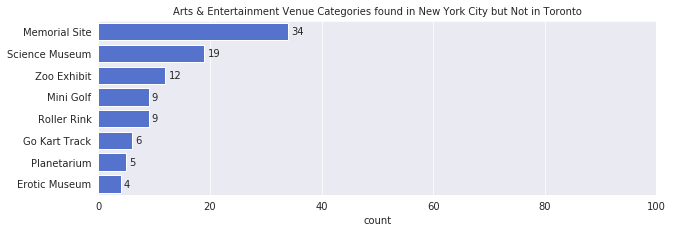

In [168]:
fig = plt.figure(figsize=(10, 3.2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Arts & Entertainment Venue Category", x="Count", data=newyork_ae_vc_not_in_toronto_count, color="royalblue")
ax.set_xlim(0, 100)
plt.title("Arts & Entertainment Venue Categories found in New York City but Not in Toronto", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')

fig.savefig('newyork_ae_vc_not_in_toronto_count.png', bbox_inches = 'tight')
plt.show()

##### 3.2.T.6 Arts & Entertainment Venue Categories Found in Toronto, but Not in New York City

Let's find out the Arts & Entertainment venue categories that are available in Toronto but *not* in New York City.

In [169]:
toronto_ae_vc_not_in_newyork = np.setdiff1d(toronto_ae_vc, newyork_ae_vc)
print("The number of unique venue categories found in New York City, but not in Toronto are", len(toronto_ae_vc_not_in_newyork))
toronto_ae_vc_not_in_newyork

The number of unique venue categories found in New York City, but not in Toronto are 1


array(['Racecourse'], dtype=object)

In [170]:
"Let's find the count of the {} Venue Categories in the neighborhoods of Toronto.".format(len(toronto_ae_vc_not_in_newyork))

"Let's find the count of the 1 Venue Categories in the neighborhoods of Toronto."

In [171]:
toronto_ae_vc_not_in_newyork_count = toronto_venues_ae[toronto_venues_ae['Venue Category'].isin(toronto_ae_vc_not_in_newyork)]['Venue Category'].value_counts().rename_axis('Arts & Entertainment Venue Category').reset_index(name='Count')
toronto_ae_vc_not_in_newyork_count

Arts & Entertainment Venue Category  Count
0                          Racecourse      4

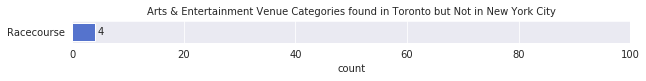

In [172]:
fig = plt.figure(figsize=(10, .4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Arts & Entertainment Venue Category", x="Count", data=toronto_ae_vc_not_in_newyork_count, color="royalblue")
ax.set_xlim(0, 100)
plt.title("Arts & Entertainment Venue Categories found in Toronto but Not in New York City", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')

fig.savefig('toronto_ae_vc_not_in_newyork_count.png', bbox_inches = 'tight')
plt.show()

##### 3.2.T.7 First 4 Arts & Entertainment Venue Categories by Count in Each Borough of Toronto

Now let's analyse each neighborhood of **Toronto** for Arts & Entertainment Venue Category. Later, we'll repeat the same exercise for New York City.

In [173]:
# one hot encoding
toronto_onehot_ae = pd.get_dummies(toronto_venues_ae[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot_ae['Neighborhood'] = toronto_venues_ae['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [toronto_onehot_ae.columns[-1]] + list(toronto_onehot_ae.columns[:-1])
toronto_onehot_ae = toronto_onehot_ae[fixed_columns]
print(toronto_onehot_ae.shape)

toronto_onehot_ae.head()

(2083, 31)


Neighborhood  Amphitheater  Art Gallery  Art Museum  \
0         Parkwoods             0            0           0   
1  Victoria Village             0            0           0   
2  Victoria Village             0            0           0   
3  Victoria Village             0            1           0   
4      Harbourfront             0            0           0   

   Arts & Entertainment  Circus  Comedy Club  Concert Hall  \
0                     0       0            0             0   
1                     0       0            0             0   
2                     0       0            0             0   
3                     0       0            0             0   
4                     0       0            0             0   

   Country Dance Club  Dance Studio  Exhibit  History Museum  \
0                   0             0        0               0   
1                   0             0        0               0   
2                   0             0        0               0   
3                   0             0        0               0   
4                   0             0        0               0   

   Indie Movie Theater  Indie Theater  Jazz Club  Laser Tag  Movie Theater  \
0                    0              0          0          0              0   
1                    0              0          0          0              0   
2                    0              0          0          0              0   
3                    0              0          0          0              0   
4                    0              0          0          0              0   

   Multiplex  Museum  Music Venue  Opera House  Outdoor Sculpture  \
0          0       0            0            0                  0   
1          0       0            1            0                  0   
2          0       0            0            0                  0   
3          0       0            0            0                  0   
4          0       0            0            0                  0   

   Performing Arts Venue  Piano Bar  Public Art  Racecourse  Rock Club  \
0                      0          0           1           0          0   
1                      0          0           0           0          0   
2                      0          0           0           0          0   
3                      0          0           0           0          0   
4                      1          0           0           0          0   

   Salsa Club  Street Art  Theater  Tour Provider  
0           0           0        0              0  
1           0           0        0              0  
2           0           0        1              0  
3           0           0        0              0  
4           0           0        0              0

Now let's draw a Bar Plot of the first 4 Arts & Entertainment venue categories by their count in each Borough of Toronto.
Earlier we found that Art Gallery, Music Venue, Theater and Movie Theater were the first 4 Arts & Entertainment venue categories by count in Toronto.

In [174]:
df_toronto_venues_art_freq_by_borough = df_toronto_venues_ae_freq_by_borough[df_toronto_venues_ae_freq_by_borough['Arts & Entertainment Venue Category'].isin(["Art Gallery"])]
df_toronto_art_borough = df_toronto_venues_art_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Art Gallery').reset_index()

df_toronto_venues_music_freq_by_borough = df_toronto_venues_ae_freq_by_borough[df_toronto_venues_ae_freq_by_borough['Arts & Entertainment Venue Category'].isin(["Music Venue"])]
df_toronto_music_borough = df_toronto_venues_music_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Music Venue').reset_index()

df_toronto_venues_theater_freq_by_borough = df_toronto_venues_ae_freq_by_borough[df_toronto_venues_ae_freq_by_borough['Arts & Entertainment Venue Category'].isin(["Theater"])]
df_toronto_theater_borough = df_toronto_venues_theater_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Theater').reset_index()

df_toronto_venues_movie_freq_by_borough = df_toronto_venues_ae_freq_by_borough[df_toronto_venues_ae_freq_by_borough['Arts & Entertainment Venue Category'].isin(["Movie Theater"])]
df_toronto_movie_borough = df_toronto_venues_movie_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Movie Theater').reset_index()

dfs = [df_toronto_art_borough, df_toronto_music_borough, df_toronto_theater_borough, df_toronto_movie_borough]

df_toronto_4_mc_ae_vc = reduce(lambda left, right: pd.merge(left, right, on='Borough', how='outer'), dfs)
df_toronto_4_mc_ae_vc['Art Gallery'] = df_toronto_4_mc_ae_vc['Art Gallery'].replace(np.nan, 0)
df_toronto_4_mc_ae_vc = df_toronto_4_mc_ae_vc.astype({"Art Gallery": int})
df_toronto_4_mc_ae_vc['Music Venue'] = df_toronto_4_mc_ae_vc['Music Venue'].replace(np.nan, 0)
df_toronto_4_mc_ae_vc = df_toronto_4_mc_ae_vc.astype({"Music Venue": int})
df_toronto_4_mc_ae_vc['Theater'] = df_toronto_4_mc_ae_vc['Theater'].replace(np.nan, 0)
df_toronto_4_mc_ae_vc = df_toronto_4_mc_ae_vc.astype({"Theater": int})
df_toronto_4_mc_ae_vc['Movie Theater'] = df_toronto_4_mc_ae_vc['Movie Theater'].replace(np.nan, 0)
df_toronto_4_mc_ae_vc = df_toronto_4_mc_ae_vc.astype({"Movie Theater": int})
df_toronto_4_mc_ae_vc

Borough  Art Gallery  Music Venue  Theater  Movie Theater
0   Central Toronto           47           29       10             27
1  Downtown Toronto          246          151      193            161
2      East Toronto           11            5        6              3
3         East York            2            7        3              1
4         Etobicoke           25           30        7             53
5        North York           17           21        9             49
6      Queen's Park           13            4        6              4
7       Scarborough            5            7        0              3
8      West Toronto           83           36       14              2
9              York            1            6        1              2

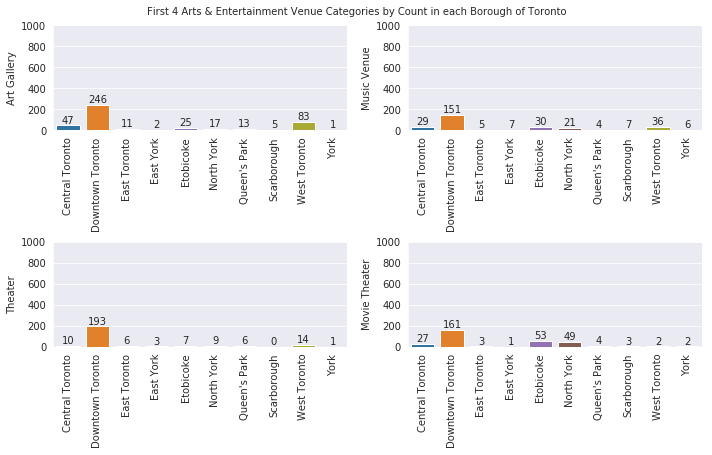

In [175]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 6.4))

sns.barplot(x="Borough", y="Art Gallery", data=df_toronto_4_mc_ae_vc, ax=axarr[0][0]);
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 1000)
for tick in axarr[0,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.barplot(x="Borough", y="Music Venue", data=df_toronto_4_mc_ae_vc, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 1000)
for tick in axarr[0,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.barplot(x="Borough", y="Theater", data=df_toronto_4_mc_ae_vc, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 1000)
for tick in axarr[1,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.barplot(x="Borough", y="Movie Theater", data=df_toronto_4_mc_ae_vc, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 1000)
for tick in axarr[1,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.94)
fig.suptitle('First 4 Arts & Entertainment Venue Categories by Count in each Borough of Toronto', fontsize='medium')
fig.savefig('df_toronto_4_mc_ae_vc.png', bbox_inches = 'tight')
plt.show()

##### 3.2.T.8 1st, 2nd, 3rd and 4th Most Common Arts & Entertainment Venue in the Neighborhoods of Toronto

Let's group the rows by neighborhood and taking the mean of the frequency of occurrence of each *Arts & Entertainment* Value category

In [176]:
toronto_grouped_ae = toronto_onehot_ae.groupby('Neighborhood').mean().reset_index()
toronto_grouped_ae.head()

Neighborhood  Amphitheater  Art Gallery  Art Museum  \
0         Adelaide           0.0     0.231884    0.014493   
1        Agincourt           0.0     0.000000    0.000000   
2  Agincourt North           0.0     0.000000    0.000000   
3   Albion Gardens           0.0     0.000000    0.000000   
4        Alderwood           0.0     0.000000    0.000000   

   Arts & Entertainment  Circus  Comedy Club  Concert Hall  \
0              0.028986     0.0     0.043478      0.072464   
1              0.000000     0.0     0.000000      0.000000   
2              0.000000     0.0     0.000000      0.000000   
3              0.000000     0.0     0.000000      0.000000   
4              0.000000     0.0     0.200000      0.000000   

   Country Dance Club  Dance Studio   Exhibit  History Museum  \
0                 0.0      0.028986  0.028986             0.0   
1                 0.0      0.000000  0.000000             0.0   
2                 0.0      1.000000  0.000000             0.0   
3                 0.0      0.000000  0.000000             0.0   
4                 0.0      0.400000  0.000000             0.0   

   Indie Movie Theater  Indie Theater  Jazz Club  Laser Tag  Movie Theater  \
0             0.028986            0.0   0.028986        0.0       0.173913   
1             0.000000            0.0   0.000000        0.0       0.000000   
2             0.000000            0.0   0.000000        0.0       0.000000   
3             0.166667            0.0   0.000000        0.0       0.833333   
4             0.000000            0.0   0.000000        0.0       0.000000   

   Multiplex    Museum  Music Venue  Opera House  Outdoor Sculpture  \
0        0.0  0.014493     0.130435     0.014493           0.014493   
1        0.0  0.000000     1.000000     0.000000           0.000000   
2        0.0  0.000000     0.000000     0.000000           0.000000   
3        0.0  0.000000     0.000000     0.000000           0.000000   
4        0.0  0.000000     0.000000     0.000000           0.000000   

   Performing Arts Venue  Piano Bar  Public Art  Racecourse  Rock Club  \
0               0.028986        0.0         0.0         0.0        0.0   
1               0.000000        0.0         0.0         0.0        0.0   
2               0.000000        0.0         0.0         0.0        0.0   
3               0.000000        0.0         0.0         0.0        0.0   
4               0.200000        0.0         0.0         0.0        0.0   

   Salsa Club  Street Art   Theater  Tour Provider  
0         0.0         0.0  0.115942            0.0  
1         0.0         0.0  0.000000            0.0  
2         0.0         0.0  0.000000            0.0  
3         0.0         0.0  0.000000            0.0  
4         0.0         0.0  0.200000            0.0

Now let's create a pandas dataframe to display the top 10 Arts & Entertainment venues for each neighborhood.

In [177]:
num_top_ae_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_ae_venues):
    try:
        columns.append('{}{} Most Common Arts & Entertainment Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Arts & Entertainment Venue'.format(ind+1))

# create a new dataframe
toronto_neighborhoods_ae_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_ae_venues_sorted['Neighborhood'] = toronto_grouped_ae['Neighborhood']

for ind in np.arange(toronto_grouped_ae.shape[0]):
    toronto_neighborhoods_ae_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped_ae.iloc[ind, :], num_top_ae_venues)

toronto_neighborhoods_ae_venues_sorted.head()

Neighborhood 1st Most Common Arts & Entertainment Venue  \
0         Adelaide                                Art Gallery   
1        Agincourt                                Music Venue   
2  Agincourt North                               Dance Studio   
3   Albion Gardens                              Movie Theater   
4        Alderwood                               Dance Studio   

  2nd Most Common Arts & Entertainment Venue  \
0                              Movie Theater   
1                              Tour Provider   
2                              Tour Provider   
3                        Indie Movie Theater   
4                                Comedy Club   

  3rd Most Common Arts & Entertainment Venue  \
0                                Music Venue   
1                                  Jazz Club   
2                                    Theater   
3                              Tour Provider   
4                      Performing Arts Venue   

  4th Most Common Arts & Entertainment Venue  \
0                                    Theater   
1                                Art Gallery   
2                                Art Gallery   
3                                  Jazz Club   
4                                    Theater   

  5th Most Common Arts & Entertainment Venue  \
0                               Concert Hall   
1                                 Art Museum   
2                                 Art Museum   
3                                Art Gallery   
4                              Tour Provider   

  6th Most Common Arts & Entertainment Venue  \
0                                Comedy Club   
1                       Arts & Entertainment   
2                       Arts & Entertainment   
3                                 Art Museum   
4                                  Jazz Club   

  7th Most Common Arts & Entertainment Venue  \
0                        Indie Movie Theater   
1                                     Circus   
2                                     Circus   
3                       Arts & Entertainment   
4                                Art Gallery   

  8th Most Common Arts & Entertainment Venue  \
0                               Dance Studio   
1                                Comedy Club   
2                                Comedy Club   
3                                     Circus   
4                                 Art Museum   

  9th Most Common Arts & Entertainment Venue  \
0                       Arts & Entertainment   
1                               Concert Hall   
2                               Concert Hall   
3                                Comedy Club   
4                       Arts & Entertainment   

  10th Most Common Arts & Entertainment Venue  
0                                   Jazz Club  
1                          Country Dance Club  
2                          Country Dance Club  
3                                Concert Hall  
4                                      Circus

In [178]:
print('The shape of toronto_neighborhoods_ae_venues_sorted is', toronto_neighborhoods_ae_venues_sorted.shape)

The shape of toronto_neighborhoods_ae_venues_sorted is (189, 11)


Now let's draw a plot for the 1st, 2nd, 3rd and 4th Most Common Arts & Entertainment Venue in the neighborhoods of Toronto.

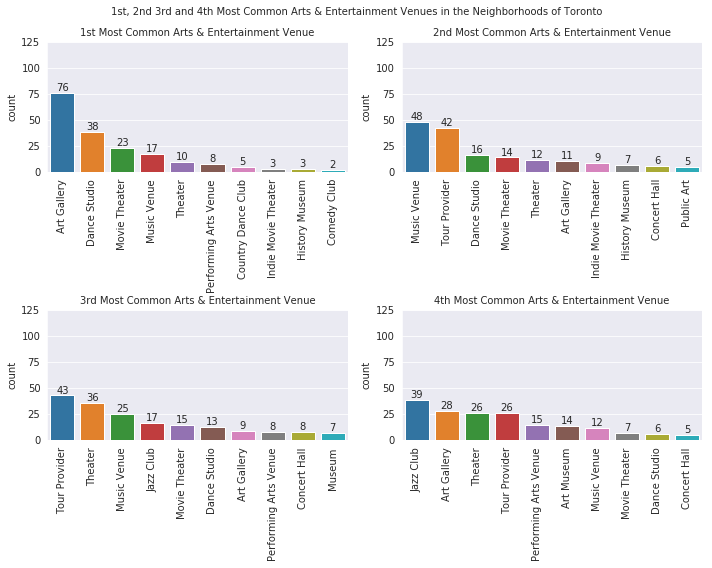

In [179]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 8))

sns.countplot(x="1st Most Common Arts & Entertainment Venue", data=toronto_neighborhoods_ae_venues_sorted, 
                 order=toronto_neighborhoods_ae_venues_sorted["1st Most Common Arts & Entertainment Venue"].value_counts().iloc[:10].index, ax=axarr[0][0])
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 125)
axarr[0,0].set_title('1st Most Common Arts & Entertainment Venue', fontsize='medium')
for tick in axarr[0,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="2nd Most Common Arts & Entertainment Venue", data=toronto_neighborhoods_ae_venues_sorted, 
                 order=toronto_neighborhoods_ae_venues_sorted["2nd Most Common Arts & Entertainment Venue"].value_counts().iloc[:10].index, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 125)
axarr[0,1].set_title('2nd Most Common Arts & Entertainment Venue', fontsize='medium')
for tick in axarr[0,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="3rd Most Common Arts & Entertainment Venue", data=toronto_neighborhoods_ae_venues_sorted, 
                 order=toronto_neighborhoods_ae_venues_sorted["3rd Most Common Arts & Entertainment Venue"].value_counts().iloc[:10].index, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 125)
axarr[1,0].set_title('3rd Most Common Arts & Entertainment Venue', fontsize='medium')
for tick in axarr[1,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="4th Most Common Arts & Entertainment Venue", data=toronto_neighborhoods_ae_venues_sorted, 
                 order=toronto_neighborhoods_ae_venues_sorted["4th Most Common Arts & Entertainment Venue"].value_counts().iloc[:10].index, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 125)
axarr[1,1].set_title('4th Most Common Arts & Entertainment Venue', fontsize='medium')
for tick in axarr[1,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle('1st, 2nd 3rd and 4th Most Common Arts & Entertainment Venues in the Neighborhoods of Toronto', fontsize='medium')
fig.savefig('df_toronto_4_mc_ae_vc_all.png', bbox_inches = 'tight')
plt.show()

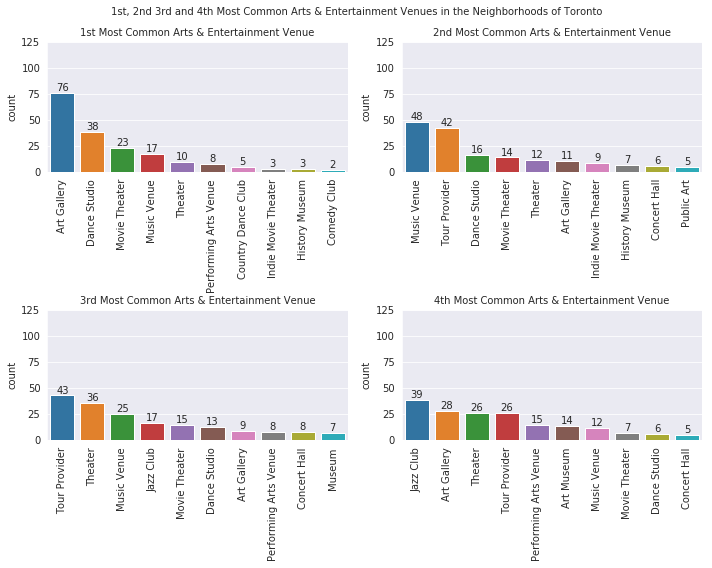

In [180]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 8))

sns.countplot(x="1st Most Common Arts & Entertainment Venue", data=toronto_neighborhoods_ae_venues_sorted, 
                 order=toronto_neighborhoods_ae_venues_sorted["1st Most Common Arts & Entertainment Venue"].value_counts().iloc[:10].index, ax=axarr[0][0])
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 125)
axarr[0,0].set_title('1st Most Common Arts & Entertainment Venue', fontsize='medium')
for tick in axarr[0,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="2nd Most Common Arts & Entertainment Venue", data=toronto_neighborhoods_ae_venues_sorted, 
                 order=toronto_neighborhoods_ae_venues_sorted["2nd Most Common Arts & Entertainment Venue"].value_counts().iloc[:10].index, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 125)
axarr[0,1].set_title('2nd Most Common Arts & Entertainment Venue', fontsize='medium')
for tick in axarr[0,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="3rd Most Common Arts & Entertainment Venue", data=toronto_neighborhoods_ae_venues_sorted, 
                 order=toronto_neighborhoods_ae_venues_sorted["3rd Most Common Arts & Entertainment Venue"].value_counts().iloc[:10].index, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 125)
axarr[1,0].set_title('3rd Most Common Arts & Entertainment Venue', fontsize='medium')
for tick in axarr[1,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="4th Most Common Arts & Entertainment Venue", data=toronto_neighborhoods_ae_venues_sorted, 
                 order=toronto_neighborhoods_ae_venues_sorted["4th Most Common Arts & Entertainment Venue"].value_counts().iloc[:10].index, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 125)
axarr[1,1].set_title('4th Most Common Arts & Entertainment Venue', fontsize='medium')
for tick in axarr[1,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle('1st, 2nd 3rd and 4th Most Common Arts & Entertainment Venues in the Neighborhoods of Toronto', fontsize='medium')
fig.savefig('df_toronto_4_mc_ae_vc_all.png', bbox_inches = 'tight')
plt.show()

##### 3.2.N.7 First 4 Arts & Entertainment Venue Categories by Count in Each Borough of New York City

Just like we analysed each neighborhood of *Toronto* for *Arts & Entertainment* Venue Category. Let's do the same analysis for **New York City** now.

In [181]:
# one hot encoding
newyork_onehot_ae = pd.get_dummies(newyork_venues_ae[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot_ae['Neighborhood'] = newyork_venues_ae['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [newyork_onehot_ae.columns[-1]] + list(newyork_onehot_ae.columns[:-1])
newyork_onehot_ae = newyork_onehot_ae[fixed_columns]
print(newyork_onehot_ae.shape)

newyork_onehot_ae.head()

(4984, 38)


Neighborhood  Amphitheater  Art Gallery  Art Museum  Arts & Entertainment  \
0    Wakefield             0            0           0                     0   
1    Wakefield             0            0           0                     0   
2    Wakefield             0            0           0                     0   
3    Wakefield             0            0           0                     0   
4    Wakefield             0            0           0                     0   

   Circus  Comedy Club  Concert Hall  Country Dance Club  Dance Studio  \
0       0            0             0                   0             0   
1       0            0             0                   0             0   
2       0            0             0                   0             0   
3       0            0             0                   0             0   
4       0            0             0                   0             0   

   Erotic Museum  Exhibit  Go Kart Track  History Museum  Indie Movie Theater  \
0              0        0              0               0                    0   
1              0        0              0               0                    0   
2              0        0              0               0                    0   
3              0        0              0               0                    0   
4              0        0              0               0                    0   

   Indie Theater  Jazz Club  Laser Tag  Memorial Site  Mini Golf  \
0              0          0          0              0          0   
1              0          0          0              0          0   
2              0          0          0              0          0   
3              0          0          0              0          0   
4              0          0          0              0          0   

   Movie Theater  Multiplex  Museum  Music Venue  Opera House  \
0              0          0       0            0            0   
1              0          0       0            1            0   
2              0          0       0            1            0   
3              0          0       0            1            0   
4              0          0       0            1            0   

   Outdoor Sculpture  Performing Arts Venue  Piano Bar  Planetarium  \
0                  0                      0          0            0   
1                  0                      0          0            0   
2                  0                      0          0            0   
3                  0                      0          0            0   
4                  0                      0          0            0   

   Public Art  Rock Club  Roller Rink  Salsa Club  Science Museum  Street Art  \
0           0          0            0           1               0           0   
1           0          0            0           0               0           0   
2           0          0            0           0               0           0   
3           0          0            0           0               0           0   
4           0          0            0           0               0           0   

   Theater  Tour Provider  Zoo Exhibit  
0        0              0            0  
1        0              0            0  
2        0              0            0  
3        0              0            0  
4        0              0            0

Let's draw a Bar Plot of First 4 Arts & Entertainment Venue Categories by their Count in each Borough of New York City. 
Earlier we found that Art Gallery, Theater, Dance Studio and Music Venue were the first 4 Arts & Entertainment venue categories by count in New York City. 

In [182]:
df_newyork_venues_art_freq_by_borough = df_newyork_venues_ae_freq_by_borough[df_newyork_venues_ae_freq_by_borough['Arts & Entertainment Venue Category'].isin(["Art Gallery"])]
df_newyork_art_borough = df_newyork_venues_art_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Art Gallery').reset_index()

df_newyork_venues_theater_freq_by_borough = df_newyork_venues_ae_freq_by_borough[df_newyork_venues_ae_freq_by_borough['Arts & Entertainment Venue Category'].isin(["Theater"])]
df_newyork_theater_borough = df_newyork_venues_theater_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Theater').reset_index()

df_newyork_venues_dance_freq_by_borough = df_newyork_venues_ae_freq_by_borough[df_newyork_venues_ae_freq_by_borough['Arts & Entertainment Venue Category'].isin(["Dance Studio"])]
df_newyork_dance_borough = df_newyork_venues_dance_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Dance Studio').reset_index()

df_newyork_venues_music_freq_by_borough = df_newyork_venues_ae_freq_by_borough[df_newyork_venues_ae_freq_by_borough['Arts & Entertainment Venue Category'].isin(["Music Venue"])]
df_newyork_music_borough = df_newyork_venues_music_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Music Venue').reset_index()

dfs = [df_newyork_art_borough, df_newyork_theater_borough, df_newyork_dance_borough, df_newyork_music_borough]

df_newyork_4_mc_ae_vc = reduce(lambda left, right: pd.merge(left, right, on='Borough', how='outer'), dfs)
df_newyork_4_mc_ae_vc['Art Gallery'] = df_newyork_4_mc_ae_vc['Art Gallery'].replace(np.nan, 0)
df_newyork_4_mc_ae_vc = df_newyork_4_mc_ae_vc.astype({"Art Gallery": int})
df_newyork_4_mc_ae_vc['Music Venue'] = df_newyork_4_mc_ae_vc['Music Venue'].replace(np.nan, 0)
df_newyork_4_mc_ae_vc = df_newyork_4_mc_ae_vc.astype({"Music Venue": int})
df_newyork_4_mc_ae_vc['Theater'] = df_newyork_4_mc_ae_vc['Theater'].replace(np.nan, 0)
df_newyork_4_mc_ae_vc = df_newyork_4_mc_ae_vc.astype({"Theater": int})
df_newyork_4_mc_ae_vc['Dance Studio'] = df_newyork_4_mc_ae_vc['Dance Studio'].replace(np.nan, 0)
df_newyork_4_mc_ae_vc = df_newyork_4_mc_ae_vc.astype({"Dance Studio": int})
df_newyork_4_mc_ae_vc

Borough  Art Gallery  Theater  Dance Studio  Music Venue
0          Bronx           48       22            42           67
1       Brooklyn          408       61           177          182
2      Manhattan          809      402           238          151
3         Queens          106       47           115           85
4  Staten Island          130       34            78           30

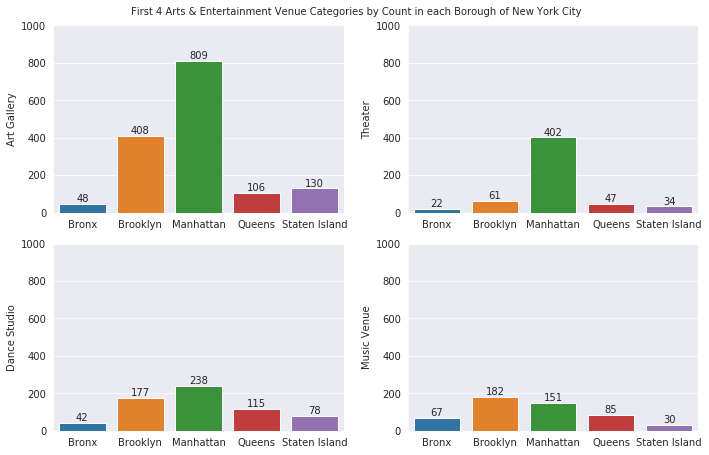

In [183]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 6.4))

sns.barplot(x="Borough", y="Art Gallery", data=df_newyork_4_mc_ae_vc, ax=axarr[0][0]);
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 1000)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.barplot(x="Borough", y="Theater", data=df_newyork_4_mc_ae_vc, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 1000)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.barplot(x="Borough", y="Dance Studio", data=df_newyork_4_mc_ae_vc, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 1000)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.barplot(x="Borough", y="Music Venue", data=df_newyork_4_mc_ae_vc, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 1000)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.94)
fig.suptitle('First 4 Arts & Entertainment Venue Categories by Count in each Borough of New York City', fontsize='medium')
fig.savefig('df_newyork_4_mc_ae_vc.png', bbox_inches = 'tight')
plt.show()

##### 3.2.N.8 1st, 2nd, 3rd and 4th Most Common Arts & Entertainment Venue in the Neighborhoods of New York City

Let's group the rows by neighborhood and taking the mean of the frequency of occurrence of each *Arts & Entertainment* Value category.

In [184]:
newyork_grouped_ae = newyork_onehot_ae.groupby('Neighborhood').mean().reset_index()
newyork_grouped_ae.head()

Neighborhood  Amphitheater  Art Gallery  Art Museum  Arts & Entertainment  \
0       Allerton           0.0          0.0         0.0                   0.0   
1       Annadale           0.0          0.0         0.0                   0.0   
2  Arden Heights           0.0          1.0         0.0                   0.0   
3       Arrochar           0.0          0.0         0.0                   0.0   
4        Astoria           0.0          0.0         0.0                   0.0   

   Circus  Comedy Club  Concert Hall  Country Dance Club  Dance Studio  \
0     0.0          0.0           0.0                0.25      0.500000   
1     0.0          0.0           0.0                0.00      1.000000   
2     0.0          0.0           0.0                0.00      0.000000   
3     0.0          0.0           0.0                0.00      1.000000   
4     0.0          0.0           0.0                0.00      0.454545   

   Erotic Museum  Exhibit  Go Kart Track  History Museum  Indie Movie Theater  \
0            0.0      0.0            0.0             0.0                  0.0   
1            0.0      0.0            0.0             0.0                  0.0   
2            0.0      0.0            0.0             0.0                  0.0   
3            0.0      0.0            0.0             0.0                  0.0   
4            0.0      0.0            0.0             0.0                  0.0   

   Indie Theater  Jazz Club  Laser Tag  Memorial Site  Mini Golf  \
0       0.000000        0.0        0.0            0.0        0.0   
1       0.000000        0.0        0.0            0.0        0.0   
2       0.000000        0.0        0.0            0.0        0.0   
3       0.000000        0.0        0.0            0.0        0.0   
4       0.090909        0.0        0.0            0.0        0.0   

   Movie Theater  Multiplex  Museum  Music Venue  Opera House  \
0            0.0        0.0     0.0     0.250000          0.0   
1            0.0        0.0     0.0     0.000000          0.0   
2            0.0        0.0     0.0     0.000000          0.0   
3            0.0        0.0     0.0     0.000000          0.0   
4            0.0        0.0     0.0     0.272727          0.0   

   Outdoor Sculpture  Performing Arts Venue  Piano Bar  Planetarium  \
0           0.000000               0.000000        0.0          0.0   
1           0.000000               0.000000        0.0          0.0   
2           0.000000               0.000000        0.0          0.0   
3           0.000000               0.000000        0.0          0.0   
4           0.090909               0.090909        0.0          0.0   

   Public Art  Rock Club  Roller Rink  Salsa Club  Science Museum  Street Art  \
0         0.0        0.0          0.0         0.0             0.0         0.0   
1         0.0        0.0          0.0         0.0             0.0         0.0   
2         0.0        0.0          0.0         0.0             0.0         0.0   
3         0.0        0.0          0.0         0.0             0.0         0.0   
4         0.0        0.0          0.0         0.0             0.0         0.0   

   Theater  Tour Provider  Zoo Exhibit  
0      0.0            0.0          0.0  
1      0.0            0.0          0.0  
2      0.0            0.0          0.0  
3      0.0            0.0          0.0  
4      0.0            0.0          0.0

Now let's create a pandas dataframe to display the top 10 Arts & Entertainment venues for each neighborhood.

In [185]:
num_top_ae_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_ae_venues):
    try:
        columns.append('{}{} Most Common Arts & Entertainment Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Arts & Entertainment Venue'.format(ind+1))

# create a new dataframe
newyork_neighborhoods_ae_venues_sorted = pd.DataFrame(columns=columns)
newyork_neighborhoods_ae_venues_sorted['Neighborhood'] = newyork_grouped_ae['Neighborhood']

for ind in np.arange(newyork_grouped_ae.shape[0]):
    newyork_neighborhoods_ae_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped_ae.iloc[ind, :], num_top_ae_venues)

newyork_neighborhoods_ae_venues_sorted.head()

Neighborhood 1st Most Common Arts & Entertainment Venue  \
0       Allerton                               Dance Studio   
1       Annadale                               Dance Studio   
2  Arden Heights                                Art Gallery   
3       Arrochar                               Dance Studio   
4        Astoria                               Dance Studio   

  2nd Most Common Arts & Entertainment Venue  \
0                                Music Venue   
1                              Memorial Site   
2                                Zoo Exhibit   
3                              Memorial Site   
4                                Music Venue   

  3rd Most Common Arts & Entertainment Venue  \
0                         Country Dance Club   
1                                  Jazz Club   
2                              Erotic Museum   
3                                  Jazz Club   
4                      Performing Arts Venue   

  4th Most Common Arts & Entertainment Venue  \
0                              Erotic Museum   
1                              Indie Theater   
2                                  Jazz Club   
3                              Indie Theater   
4                              Indie Theater   

  5th Most Common Arts & Entertainment Venue  \
0                                  Jazz Club   
1                        Indie Movie Theater   
2                              Indie Theater   
3                        Indie Movie Theater   
4                          Outdoor Sculpture   

  6th Most Common Arts & Entertainment Venue  \
0                              Indie Theater   
1                             History Museum   
2                        Indie Movie Theater   
3                             History Museum   
4                                Zoo Exhibit   

  7th Most Common Arts & Entertainment Venue  \
0                        Indie Movie Theater   
1                              Go Kart Track   
2                             History Museum   
3                              Go Kart Track   
4                        Indie Movie Theater   

  8th Most Common Arts & Entertainment Venue  \
0                             History Museum   
1                                    Exhibit   
2                              Go Kart Track   
3                                    Exhibit   
4                             History Museum   

  9th Most Common Arts & Entertainment Venue  \
0                              Go Kart Track   
1                              Erotic Museum   
2                                    Exhibit   
3                              Erotic Museum   
4                              Go Kart Track   

  10th Most Common Arts & Entertainment Venue  
0                                     Exhibit  
1                                 Zoo Exhibit  
2                                Dance Studio  
3                                 Zoo Exhibit  
4                                     Exhibit

In [186]:
print('The shape of newyork_neighborhoods_ae_venues_sorted is', newyork_neighborhoods_ae_venues_sorted.shape)

The shape of newyork_neighborhoods_ae_venues_sorted is (292, 11)


Now let's draw a plot for the 1st, 2nd, 3rd and 4th Most Common Arts & Entertainment Venue in the neighborhoods of New York City. 

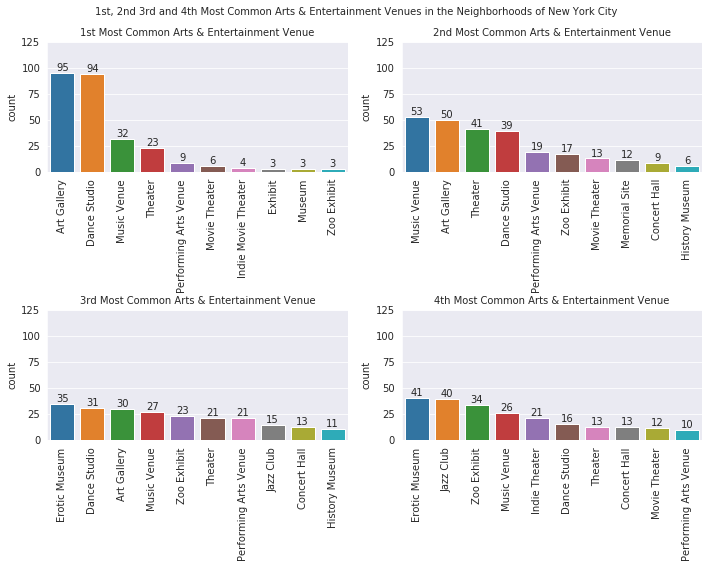

In [187]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 8))

sns.countplot(x="1st Most Common Arts & Entertainment Venue", data=newyork_neighborhoods_ae_venues_sorted, 
                 order=newyork_neighborhoods_ae_venues_sorted["1st Most Common Arts & Entertainment Venue"].value_counts().iloc[:10].index, ax=axarr[0][0])
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 125)
axarr[0,0].set_title('1st Most Common Arts & Entertainment Venue', fontsize='medium')
for tick in axarr[0,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="2nd Most Common Arts & Entertainment Venue", data=newyork_neighborhoods_ae_venues_sorted, 
                 order=newyork_neighborhoods_ae_venues_sorted["2nd Most Common Arts & Entertainment Venue"].value_counts().iloc[:10].index, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 125)
axarr[0,1].set_title('2nd Most Common Arts & Entertainment Venue', fontsize='medium')
for tick in axarr[0,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="3rd Most Common Arts & Entertainment Venue", data=newyork_neighborhoods_ae_venues_sorted, 
                 order=newyork_neighborhoods_ae_venues_sorted["3rd Most Common Arts & Entertainment Venue"].value_counts().iloc[:10].index, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 125)
axarr[1,0].set_title('3rd Most Common Arts & Entertainment Venue', fontsize='medium')
for tick in axarr[1,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="4th Most Common Arts & Entertainment Venue", data=newyork_neighborhoods_ae_venues_sorted, 
                 order=newyork_neighborhoods_ae_venues_sorted["4th Most Common Arts & Entertainment Venue"].value_counts().iloc[:10].index, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 125)
axarr[1,1].set_title('4th Most Common Arts & Entertainment Venue', fontsize='medium')
for tick in axarr[1,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle('1st, 2nd 3rd and 4th Most Common Arts & Entertainment Venues in the Neighborhoods of New York City', fontsize='medium')
fig.savefig('df_newyork_4_mc_ae_vc_all.png', bbox_inches = 'tight')
plt.show()

##### 3.2.T.9 Cluster the Neighborhoods in Toronto based on Arts & Entertainment Venue Categories

Let's **Cluster the Neighborhoods in Toronto** next to determine similar neighborhoods based on Arts & Entertainment venue categories. But first, let's find out the optimum value of k using Elbow Method.

Sqaured Error (Cost) [67.44485398270014, 53.63962310563694, 43.669010556837804, 36.06550415420149, 28.64808718424439, 25.513022398688797, 22.533845014468, 19.266139572468376, 18.061866521464367, 15.138111279940343, 13.684195083743923]
Elbow Point 5


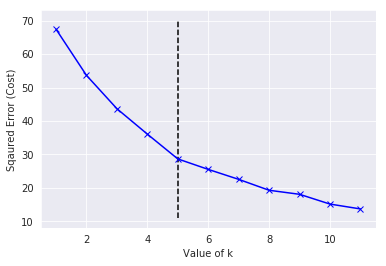

In [188]:
# cluster dataset
toronto_grouped_ae_clustering = toronto_grouped_ae.drop('Neighborhood', 1)

cost =[] 
for i in range(1, 12): 
    KM = KMeans(n_clusters = i, random_state=0) 
    KM.fit(toronto_grouped_ae_clustering)       
    cost.append(KM.inertia_)  
    
print("Sqaured Error (Cost)", cost)
  
k = range(1, len(cost)+1)

from kneed import KneeLocator
kn = KneeLocator(k, cost, curve='convex', direction='decreasing')
t_ae_knee = kn.knee
print("Elbow Point", t_ae_knee)
plt.xlabel('Value of k')
plt.ylabel('Sqaured Error (Cost)')
plt.plot(k, cost, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [189]:
"As the Elbow Point turns out to be {}, we'll run *k*-means to cluster the neighborhood into {} clusters".format(t_ae_knee, t_ae_knee)

"As the Elbow Point turns out to be 5, we'll run *k*-means to cluster the neighborhood into 5 clusters"

In [190]:
# set number of clusters
kclusters = t_ae_knee

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_ae_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 1, 3, 1, 0, 1, 1, 3, 0], dtype=int32)

In [191]:
# drop clustering labels if already inserted
# toronto_neighborhoods_ae_venues_sorted = toronto_neighborhoods_ae_venues_sorted.drop('Cluster Labels', axis=1)

# add clustering labels
toronto_neighborhoods_ae_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# toronto_neighborhoods_with_no_ae_indices do not have any Arts & Entertainment venues 1000 meters around it, so let's drop them.
# execute the following line just once
toronto_merged_ae = df_postalcodes_toronto.drop(df_postalcodes_toronto.index[toronto_neighborhoods_with_no_ae_indices])

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged_ae = toronto_merged_ae.join(toronto_neighborhoods_ae_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged_ae.head() # check the last columns!

Borough      Neighborhood   Latitude  Longitude  Cluster Labels  \
0        North York         Parkwoods  43.753259 -79.329656               0   
1        North York  Victoria Village  43.725882 -79.315572               0   
2  Downtown Toronto      Harbourfront  43.654260 -79.360636               0   
3  Downtown Toronto       Regent Park  43.654260 -79.360636               0   
4        North York  Lawrence Heights  43.718518 -79.464763               0   

  1st Most Common Arts & Entertainment Venue  \
0                                 Public Art   
1                                Art Gallery   
2                                    Theater   
3                                    Theater   
4                                Art Gallery   

  2nd Most Common Arts & Entertainment Venue  \
0                              Tour Provider   
1                                Music Venue   
2                                Art Gallery   
3                                Art Gallery   
4                                 Public Art   

  3rd Most Common Arts & Entertainment Venue  \
0                                  Jazz Club   
1                                    Theater   
2                               Dance Studio   
3                               Dance Studio   
4                              Tour Provider   

  4th Most Common Arts & Entertainment Venue  \
0                                Art Gallery   
1                              Tour Provider   
2                      Performing Arts Venue   
3                      Performing Arts Venue   
4                                  Jazz Club   

  5th Most Common Arts & Entertainment Venue  \
0                                 Art Museum   
1                                  Jazz Club   
2                                Opera House   
3                                Opera House   
4                                 Art Museum   

  6th Most Common Arts & Entertainment Venue  \
0                       Arts & Entertainment   
1                                 Art Museum   
2                                     Museum   
3                                     Museum   
4                       Arts & Entertainment   

  7th Most Common Arts & Entertainment Venue  \
0                                     Circus   
1                       Arts & Entertainment   
2                                Music Venue   
3                                Music Venue   
4                                     Circus   

  8th Most Common Arts & Entertainment Venue  \
0                                Comedy Club   
1                                     Circus   
2                             History Museum   
3                             History Museum   
4                                Comedy Club   

  9th Most Common Arts & Entertainment Venue  \
0                               Concert Hall   
1                                Comedy Club   
2                        Indie Movie Theater   
3                        Indie Movie Theater   
4                               Concert Hall   

  10th Most Common Arts & Entertainment Venue  
0                          Country Dance Club  
1                                Concert Hall  
2                          Country Dance Club  
3                          Country Dance Club  
4                          Country Dance Club

Let's visualize the resulting clusters now.

In [192]:
# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_ae['Latitude'], toronto_merged_ae['Longitude'], toronto_merged_ae['Neighborhood'], toronto_merged_ae['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label, #map not rendering with popup specified
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, let's examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

In [193]:
# Cluster 0
toronto_merged_ae.loc[toronto_merged_ae['Cluster Labels'] == 0, toronto_merged_ae.columns[[1] + list(range(5, toronto_merged_ae.shape[1]))]]

Neighborhood  \
0                                Parkwoods   
1                         Victoria Village   
2                             Harbourfront   
3                              Regent Park   
4                         Lawrence Heights   
5                           Lawrence Manor   
6                             Queen's Park   
13                                 Ryerson   
14                         Garden District   
15                               Glencairn   
16                              Cloverdale   
17                               Islington   
18                            Martin Grove   
19                        Princess Gardens   
20                         West Deane Park   
21                          Highland Creek   
22                              Rouge Hill   
23                              Port Union   
35                             The Beaches   
36                             Berczy Park   
39                                 Leaside   
40                      Central Bay Street   
41                                Christie   
42                               Cedarbrae   
44                          Bathurst Manor   
45                         Downsview North   
46                          Wilson Heights   
47                        Thorncliffe Park   
48                                Adelaide   
49                                    King   
50                                Richmond   
59                            East Toronto   
60                       Harbourfront East   
61                         Toronto Islands   
62                           Union Station   
65                    East Birchmount Park   
66                                 Ionview   
67                            Kennedy Park   
69                             CFB Toronto   
70                          Downsview East   
71                       The Danforth West   
72                               Riverdale   
73                         Design Exchange   
74                 Toronto Dominion Centre   
75                                Brockton   
76                        Exhibition Place   
77                        Parkdale Village   
84                        The Beaches West   
85                            India Bazaar   
86                          Commerce Court   
87                          Victoria Hotel   
95                             Newtonbrook   
96                              Willowdale   
98                         Studio District   
99                            Bedford Park   
100                    Lawrence Manor East   
101                                Del Ray   
102                             Keelesdale   
103                           Mount Dennis   
104                            Silverthorn   
115                                 Weston   
116                            Dorset Park   
117                Scarborough Town Centre   
118                        Wexford Heights   
121                      Forest Hill North   
122                       Forest Hill West   
123                              High Park   
124                     The Junction South   
130                              The Annex   
131                          North Midtown   
132                              Yorkville   
133                               Parkdale   
134                           Roncesvalles   
135  Canada Post Gateway Processing Centre   
136                      Kingsview Village   
137                   Martin Grove Gardens   
138                       Richview Gardens   
139                           St. Phillips   
142                                Harbord   
143                  University of Toronto   
145                                Swansea   
149                             Moore Park   
150                        Summerhill East   
151                              Chinatown   
152                            Grange Park   
153                      Kensington Market   
158                         

In [194]:
# Cluster 1
toronto_merged_ae.loc[toronto_merged_ae['Cluster Labels'] == 1, toronto_merged_ae.columns[[1] + list(range(5, toronto_merged_ae.shape[1]))]]

Neighborhood 1st Most Common Arts & Entertainment Venue  \
10            Don Mills North                               Dance Studio   
24            Flemingdon Park                               Dance Studio   
25            Don Mills South                               Dance Studio   
26           Woodbine Heights                                     Circus   
43          Hillcrest Village                               Dance Studio   
68            Bayview Village                               Dance Studio   
78                   Clairlea                               Dance Studio   
79                Golden Mile                               Dance Studio   
80                   Oakridge                               Dance Studio   
91              Humber Summit                               Dance Studio   
109          Willowdale South                               Dance Studio   
112                  Roselawn                               Dance Studio   
113        The Junction North                               Dance Studio   
114                 Runnymede                               Dance Studio   
119           York Mills West                               Dance Studio   
120          Davisville North                               Dance Studio   
129        North Toronto West                                Comedy Club   
144                 Runnymede                               Dance Studio   
154           Agincourt North                               Dance Studio   
155           L'Amoreaux East                               Dance Studio   
156                  Milliken                               Dance Studio   
157              Steeles East                               Dance Studio   
163                  CN Tower                               Dance Studio   
164             Bathurst Quay                               Dance Studio   
165            Island airport                               Dance Studio   
166         Harbourfront West                               Dance Studio   
167          King and Spadina                               Dance Studio   
168             Railway Lands                               Dance Studio   
169             South Niagara                               Dance Studio   
184                 Alderwood                               Dance Studio   
185               Long Branch                               Dance Studio   
188               Cabbagetown                               Dance Studio   
189            St. James Town                               Dance Studio   
192              The Kingsway                               Dance Studio   
193           Montgomery Road                               Dance Studio   
194            Old Mill North                               Dance Studio   
205  Kingsway Park South West                               Dance Studio   
206                 Mimico NW                               Dance Studio   
207        The Queensway West                               Dance Studio   
208     Royal York South West                               Dance Studio   
209            South of Bloor                               Dance Studio   

    2nd Most Common Arts & Entertainment Venue  \
10                                 Comedy Club   
24                              History Museum   
25                              History Museum   
26                                Dance Studio   
43                               Tour Provider   
68                                 Music Venue   
78                               Tour Provider   
79                               Tour Provider   
80                               Tour Provider   
91                               Tour Provider   
109                                    Theater   
112                                Music Venue   
113                                Music Venue   
114                                  Jazz Club   
119                        Indie Movie Theater   
120                     

In [195]:
# Cluster 2
toronto_merged_ae.loc[toronto_merged_ae['Cluster Labels'] == 2, toronto_merged_ae.columns[[1] + list(range(5, toronto_merged_ae.shape[1]))]]

Neighborhood 1st Most Common Arts & Entertainment Venue  \
28          Bloordale Gardens                                Art Gallery   
29                   Eringate                                Art Gallery   
30              Markland Wood                                Art Gallery   
31          Old Burnhamthorpe                                Art Gallery   
51         Dovercourt Village                                Art Gallery   
52                   Dufferin                                Art Gallery   
63            Little Portugal                                Art Gallery   
64                    Trinity                                Art Gallery   
88                  Downsview                                Art Gallery   
89                 North Park                                Art Gallery   
90                Upwood Park                                Art Gallery   
107               Birch Cliff                                Art Gallery   
108            Cliffside West                                Art Gallery   
111             Lawrence Park                                Art Gallery   
197                Humber Bay                                Art Gallery   
198          King's Mill Park                                Art Gallery   
199  Kingsway Park South East                                Art Gallery   
200                 Mimico NE                                Art Gallery   
201            Old Mill South                                Art Gallery   
202        The Queensway East                                Art Gallery   
203     Royal York South East                                Art Gallery   
204                  Sunnylea                                Art Gallery   

    2nd Most Common Arts & Entertainment Venue  \
28                              History Museum   
29                              History Museum   
30                              History Museum   
31                              History Museum   
51                                 Music Venue   
52                                 Music Venue   
63                                 Music Venue   
64                                 Music Venue   
88                               Tour Provider   
89                               Tour Provider   
90                               Tour Provider   
107                              Tour Provider   
108                              Tour Provider   
111                              Tour Provider   
197                              Tour Provider   
198                              Tour Provider   
199                              Tour Provider   
200                              Tour Provider   
201                              Tour Provider   
202                              Tour Provider   
203                              Tour Provider   
204                              Tour Provider   

    3rd Most Common Arts & Entertainment Venue  \
28                               Tour Provider   
29                               Tour Provider   
30                               Tour Provider   
31                               Tour Provider   
51                               Tour Provider   
52                               Tour Provider   
63                                     Theater   
64                                     Theater   
88                                     Theater   
89                                     Theater   
90                                     Theater   
107                                    Theater   
108                                    Theater   
111                                    Theater   
197                                    Theater   
198                                    Theater   
199                                    Theater   
200                                    Theater   
201                                    Theater   
202                                    Theater   
203                                    Theater   
204              

In [196]:
# Cluster 3
toronto_merged_ae.loc[toronto_merged_ae['Cluster Labels'] == 3, toronto_merged_ae.columns[[1] + list(range(5, toronto_merged_ae.shape[1]))]]

Neighborhood  \
27                                  Humewood-Cedarvale   
54                                            Fairview   
55                                          Henry Farm   
56                                              Oriole   
92                                          Cliffcrest   
93                                           Cliffside   
94                            Scarborough Village West   
141                                         Davisville   
173                                     Albion Gardens   
174                                   Beaumond Heights   
175                                         Humbergate   
176                                          Jamestown   
177                                        Mount Olive   
178                                        Silverstone   
179                                      South Steeles   
180                                        Thistletown   
196  Business Reply Mail Processing Centre 969 Eastern   

    1st Most Common Arts & Entertainment Venue  \
27                               Movie Theater   
54                               Movie Theater   
55                               Movie Theater   
56                               Movie Theater   
92                               Movie Theater   
93                               Movie Theater   
94                               Movie Theater   
141                              Movie Theater   
173                              Movie Theater   
174                              Movie Theater   
175                              Movie Theater   
176                              Movie Theater   
177                              Movie Theater   
178                              Movie Theater   
179                              Movie Theater   
180                              Movie Theater   
196                              Movie Theater   

    2nd Most Common Arts & Entertainment Venue  \
27                                 Art Gallery   
54                                     Theater   
55                                     Theater   
56                                     Theater   
92                               Tour Provider   
93                               Tour Provider   
94                               Tour Provider   
141                               Dance Studio   
173                        Indie Movie Theater   
174                        Indie Movie Theater   
175                        Indie Movie Theater   
176                        Indie Movie Theater   
177                        Indie Movie Theater   
178                        Indie Movie Theater   
179                        Indie Movie Theater   
180                        Indie Movie Theater   
196                              Tour Provider   

    3rd Most Common Arts & Entertainment Venue  \
27                                Dance Studio   
54                                Concert Hall   
55                                Concert Hall   
56                                Concert Hall   
92                                   Jazz Club   
93                                   Jazz Club   
94                                   Jazz Club   
141                                Comedy Club   
173                              Tour Provider   
174                              Tour Provider   
175                              Tour Provider   
176                              Tour Provider   
177                              Tour Provider   
178                              Tour Provider   
179                              Tour Provider   
180                              Tour Provider   
196                                  Jazz Club   

    4th Most Common Arts & Entertainment Venue  \
27                               Tour Provider   
54                       Performing Arts Venue   
55                       Performing Arts Venue   
56                       Performing Arts Venue   
92                                 Art Galle

In [197]:
# Cluster 4
toronto_merged_ae.loc[toronto_merged_ae['Cluster Labels'] == 4, toronto_merged_ae.columns[[1] + list(range(5, toronto_merged_ae.shape[1]))]]

Neighborhood 1st Most Common Arts & Entertainment Venue  \
7     Islington Avenue                               Concert Hall   
11    Woodbine Gardens                                Music Venue   
12       Parkview Hill                                Music Venue   
57      Northwood Park                                Music Venue   
58     York University                                Music Venue   
81        Silver Hills                                Music Venue   
82          York Mills                                Music Venue   
126           Maryvale                                Music Venue   
127            Wexford                                Music Venue   
140          Agincourt                                Music Venue   
170  Humber Bay Shores                                Music Venue   
171       Mimico South                                Music Venue   
172        New Toronto                                Music Venue   
181    L'Amoreaux West                                Music Venue   

    2nd Most Common Arts & Entertainment Venue  \
7                                  Music Venue   
11                               Tour Provider   
12                               Tour Provider   
57                                Dance Studio   
58                                Dance Studio   
81                               Tour Provider   
82                               Tour Provider   
126                              Tour Provider   
127                              Tour Provider   
140                              Tour Provider   
170                               Concert Hall   
171                               Concert Hall   
172                               Concert Hall   
181                              Tour Provider   

    3rd Most Common Arts & Entertainment Venue  \
7                                Tour Provider   
11                                   Jazz Club   
12                                   Jazz Club   
57                                Concert Hall   
58                                Concert Hall   
81                                   Jazz Club   
82                                   Jazz Club   
126                                  Jazz Club   
127                                  Jazz Club   
140                                  Jazz Club   
170                               Dance Studio   
171                               Dance Studio   
172                               Dance Studio   
181                                  Jazz Club   

    4th Most Common Arts & Entertainment Venue  \
7                                    Jazz Club   
11                                 Art Gallery   
12                                 Art Gallery   
57                               Tour Provider   
58                               Tour Provider   
81                                 Art Gallery   
82                                 Art Gallery   
126                                Art Gallery   
127                                Art Gallery   
140                                Art Gallery   
170                              Tour Provider   
171                              Tour Provider   
172                              Tour Provider   
181                                Art Gallery   

    5th Most Common Arts & Entertainment Venue  \
7                                  Art Gallery   
11                                  Art Museum   
12                                  Art Museum   
57                                   Jazz Club   
58                                   Jazz Club   
81                                  Art Museum   
82                                  Art Museum   
126                                 Art Museum   
127                                 Art Museum   
140                                 Art Museum   
170                                  Jazz Club   
171                                  Jazz Club   
172                                  Jazz Club   
181                  

##### 3.2.N.9 Cluster the Neighborhoods in New York City based on Arts & Entertainment Venue Categories

Let's **Cluster the Neighborhoods in New York City** to determine similar neighborhoods based on Arts & Entertainment venue categories. But first, let's find out the optimum value of k using Elbow Method.

Sqaured Error (Cost) [73.89027514498306, 58.54736958595028, 50.74048872290697, 45.40942996150795, 43.01292305949128, 40.749378547144204, 38.99403328930512, 36.90645101089978, 35.198746947326526, 34.135882174253176, 32.579755140156145]
Elbow Point 4


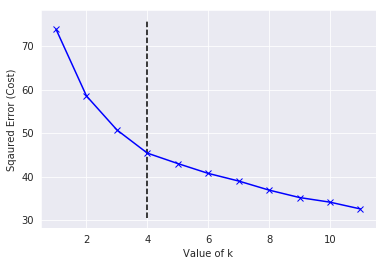

In [198]:
# cluster dataset
newyork_grouped_ae_clustering = newyork_grouped_ae.drop('Neighborhood', 1)

cost =[] 
for i in range(1, 12): 
    KM = KMeans(n_clusters = i, random_state=0) 
    KM.fit(newyork_grouped_ae_clustering)       
    cost.append(KM.inertia_)  
    
print("Sqaured Error (Cost)", cost)
  
k = range(1, len(cost)+1)

kn = KneeLocator(k, cost, curve='convex', direction='decreasing')
n_ae_knee = kn.knee
print("Elbow Point", n_ae_knee)
plt.xlabel('Value of k')
plt.ylabel('Sqaured Error (Cost)')
plt.plot(k, cost, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [199]:
"As the Elbow Point turns out to be {}, we'll run *k*-means to cluster the neighborhood into {} clusters".format(n_ae_knee, n_ae_knee)

"As the Elbow Point turns out to be 4, we'll run *k*-means to cluster the neighborhood into 4 clusters"

In [200]:
# set number of clusters
kclusters = n_ae_knee

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_ae_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 3, 1, 1, 3, 0, 1, 2, 1], dtype=int32)

In [201]:
# drop clustering labels if already inserted
# newyork_neighborhoods_ae_venues_sorted = newyork_neighborhoods_ae_venues_sorted.drop('Cluster Labels', axis=1)

# add clustering labels
newyork_neighborhoods_ae_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# newyork_neighborhoods_with_no_ae_indices do not have any Arts & Entertainment venues 1000 meters around it, so let's drop them.
# execute the following line just once
newyork_merged_ae = df_newyork_neighborhoods.drop(df_newyork_neighborhoods.index[newyork_neighborhoods_with_no_ae_indices])

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_merged_ae = newyork_merged_ae.join(newyork_neighborhoods_ae_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newyork_merged_ae.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201               0   
1   Bronx   Co-op City  40.874294 -73.829939               3   
2   Bronx  Eastchester  40.887556 -73.827806               0   
3   Bronx    Fieldston  40.895437 -73.905643               3   
4   Bronx    Riverdale  40.890834 -73.912585               0   

  1st Most Common Arts & Entertainment Venue  \
0                                Music Venue   
1                                Art Gallery   
2                                Art Gallery   
3                                Art Gallery   
4                                Music Venue   

  2nd Most Common Arts & Entertainment Venue  \
0                      Performing Arts Venue   
1                              Movie Theater   
2                                Music Venue   
3                             History Museum   
4                                Art Gallery   

  3rd Most Common Arts & Entertainment Venue  \
0                                Art Gallery   
1                                Music Venue   
2                                Zoo Exhibit   
3                                 Public Art   
4                                    Theater   

  4th Most Common Arts & Entertainment Venue  \
0                                 Salsa Club   
1                               Dance Studio   
2                              Erotic Museum   
3                                Zoo Exhibit   
4                              Go Kart Track   

  5th Most Common Arts & Entertainment Venue  \
0                                Zoo Exhibit   
1                                 Public Art   
2                                  Jazz Club   
3                              Erotic Museum   
4                                Zoo Exhibit   

  6th Most Common Arts & Entertainment Venue  \
0                              Indie Theater   
1                                  Jazz Club   
2                              Indie Theater   
3                                  Jazz Club   
4                              Erotic Museum   

  7th Most Common Arts & Entertainment Venue  \
0                        Indie Movie Theater   
1                                Comedy Club   
2                        Indie Movie Theater   
3                              Indie Theater   
4                              Indie Theater   

  8th Most Common Arts & Entertainment Venue  \
0                             History Museum   
1                               Concert Hall   
2                             History Museum   
3                        Indie Movie Theater   
4                        Indie Movie Theater   

  9th Most Common Arts & Entertainment Venue  \
0                              Go Kart Track   
1                                     Circus   
2                              Go Kart Track   
3                              Go Kart Track   
4                             History Museum   

  10th Most Common Arts & Entertainment Venue  
0                                     Exhibit  
1                          Country Dance Club  
2                                     Exhibit  
3                                     Exhibit  
4                                     Exhibit

Let's visualize the resulting clusters now.

In [202]:
# create map
map_clusters = folium.Map(location=[newyork_latitude, newyork_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged_ae['Latitude'], newyork_merged_ae['Longitude'], newyork_merged_ae['Neighborhood'], newyork_merged_ae['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label, #map not rendering with popup specified
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, let's examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

In [203]:
# Cluster 0
newyork_merged_ae.loc[newyork_merged_ae['Cluster Labels'] == 0, newyork_merged_ae.columns[[1] + list(range(5, newyork_merged_ae.shape[1]))]]

Neighborhood 1st Most Common Arts & Entertainment Venue  \
0                    Wakefield                                Music Venue   
2                  Eastchester                                Art Gallery   
4                    Riverdale                                Music Venue   
5                  Kingsbridge                                Music Venue   
6                  Marble Hill                                Music Venue   
14          University Heights                                Music Venue   
15              Morris Heights                                Music Venue   
21                  Mott Haven                      Performing Arts Venue   
22                 Port Morris                                Music Venue   
25                  Morrisania                                Art Gallery   
26                   Soundview                      Performing Arts Venue   
35              Spuyten Duyvil                                Music Venue   
36             North Riverdale                              Movie Theater   
37                  Pelham Bay                               Dance Studio   
39              Edgewater Park                               Dance Studio   
41                   Olinville                                Art Gallery   
42              Pelham Gardens                                Art Gallery   
45                    Edenwald                                Music Venue   
50                   Gravesend                               Dance Studio   
56               East Flatbush                                Music Venue   
57                  Kensington                               Dance Studio   
62                    Bushwick                                Music Venue   
72               East New York                                Music Venue   
73               Starrett City                                Music Venue   
74                    Canarsie                                Music Venue   
75                   Flatlands                                Music Venue   
78                Coney Island                                Music Venue   
84                Clinton Hill                                Music Venue   
85                    Sea Gate                                Music Venue   
88   Prospect Lefferts Gardens                                Music Venue   
101         Washington Heights                                    Theater   
133               Howard Beach                                Music Venue   
136                Kew Gardens                                Art Gallery   
137              Richmond Hill                                Art Gallery   
145                  Rego Park                               Dance Studio   
149              College Point                                Music Venue   
150                 Whitestone                                Music Venue   
152                 Auburndale                               Dance Studio   
159                  Briarwood                                Music Venue   
162             Queens Village                                Music Venue   
163                     Hollis                               Dance Studio   
167        Springfield Gardens                                Art Gallery   
169                   Rosedale                                Music Venue   
173                   Steinway                                Music Venue   
174                 Beechhurst                                Art Gallery   
176                   Edgemere                                Art Gallery   
182                 Holliswood                              Movie Theater   
187                 Lindenwood                               Dance Studio   
188                  Laurelton                               Dance Studio   
189                Lefrak City                                Music Venue   
194                   Bellaire                                Music Venue   
200           

In [204]:
# Cluster 1
newyork_merged_ae.loc[newyork_merged_ae['Cluster Labels'] == 1, newyork_merged_ae.columns[[1] + list(range(5, newyork_merged_ae.shape[1]))]]

Neighborhood 1st Most Common Arts & Entertainment Venue  \
11        Pelham Parkway                               Dance Studio   
28           Throgs Neck                               Dance Studio   
30           Parkchester                               Dance Studio   
31    Westchester Square                               Dance Studio   
33           Morris Park                               Dance Studio   
38         Schuylerville                               Dance Studio   
43             Concourse                               Dance Studio   
44             Unionport                               Dance Studio   
46             Bay Ridge                               Dance Studio   
47           Bensonhurst                               Dance Studio   
48           Sunset Park                               Dance Studio   
53     Manhattan Terrace                               Dance Studio   
79            Bath Beach                               Dance Studio   
89            Ocean Hill                               Dance Studio   
90             City Line                               Dance Studio   
91          Bergen Beach                               Dance Studio   
93   Prospect Park South                               Dance Studio   
94            Georgetown                               Dance Studio   
98         Ocean Parkway                               Dance Studio   
129              Astoria                               Dance Studio   
130             Woodside                               Dance Studio   
131      Jackson Heights                               Dance Studio   
132             Elmhurst                               Dance Studio   
135         Forest Hills                               Dance Studio   
141        East Elmhurst                               Dance Studio   
142              Maspeth                               Dance Studio   
144             Glendale                               Dance Studio   
146            Woodhaven                               Dance Studio   
147           Ozone Park                               Dance Studio   
151              Bayside                               Dance Studio   
165           St. Albans                               Dance Studio   
168      Cambria Heights                               Dance Studio   
171        Broad Channel                               Dance Studio   
211             New Dorp                               Dance Studio   
215             Annadale                               Dance Studio   
221          Ditmas Park                               Dance Studio   
222              Wingate                               Dance Studio   
228             Arrochar                               Dance Studio   
229             Grasmere                               Dance Studio   
230             Old Town                               Dance Studio   
231         Dongan Hills                               Dance Studio   
232        Midland Beach                               Dance Studio   
233           Grant City                               Dance Studio   
239           Charleston                               Dance Studio   
246           Bulls Head                               Dance Studio   
254              Concord                               Dance Studio   
262           Mill Basin                               Dance Studio   
285          Willowbrook                               Dance Studio   
289            Homecrest                               Dance Studio   
290       Middle Village                               Dance Studio   
293      Richmond Valley                               Dance Studio   
296              Madison                               Dance Studio   
297            Bronxdale                               Dance Studio   
298             Allerton                               Dance Studio   
300              Erasmus                               Dance Studio   

    2nd Most Common Arts & Entertai

In [205]:
# Cluster 2
newyork_merged_ae.loc[newyork_merged_ae['Cluster Labels'] == 2, newyork_merged_ae.columns[[1] + list(range(5, newyork_merged_ae.shape[1]))]]

Neighborhood 1st Most Common Arts & Entertainment Venue  \
7                Woodlawn                               Dance Studio   
8                 Norwood                      Performing Arts Venue   
10             Baychester                                Art Gallery   
12            City Island                                    Theater   
13           Bedford Park                                    Theater   
16                Fordham                                  Piano Bar   
17           East Tremont                                Zoo Exhibit   
18             West Farms                                Zoo Exhibit   
19           High  Bridge                                Art Gallery   
23               Longwood                                    Theater   
27           Clason Point                       Arts & Entertainment   
32               Van Nest                               Dance Studio   
34                Belmont                                Zoo Exhibit   
40            Castle Hill                                    Theater   
51         Brighton Beach                               Dance Studio   
52         Sheepshead Bay                               Dance Studio   
54               Flatbush                               Dance Studio   
55          Crown Heights                                     Museum   
58        Windsor Terrace                                Art Gallery   
59       Prospect Heights                                Art Gallery   
60            Brownsville                      Performing Arts Venue   
69            Fort Greene                               Dance Studio   
70             Park Slope                                Art Gallery   
77        Manhattan Beach                                    Theater   
80           Borough Park                               Amphitheater   
82        Gerritsen Beach                              Movie Theater   
83            Marine Park                              Movie Theater   
86               Downtown                                Art Gallery   
87            Boerum Hill                                Art Gallery   
92                Midwood                                    Theater   
99          Fort Hamilton                               Dance Studio   
102                Inwood                                 Art Museum   
104        Manhattanville                                    Theater   
105        Central Harlem                                Art Gallery   
106           East Harlem                               Dance Studio   
107       Upper East Side                                    Exhibit   
108             Yorkville                               Dance Studio   
110      Roosevelt Island                               Dance Studio   
111       Upper West Side                                    Exhibit   
112        Lincoln Square                                    Theater   
113               Clinton                                    Theater   
114               Midtown                                    Theater   
115           Murray Hill                               Dance Studio   
118          East Village                                Art Gallery   
123          West Village                                Art Gallery   
124      Manhattan Valley                                    Theater   
125   Morningside Heights                                    Theater   
126              Gramercy                                Art Gallery   
127     Battery Park City                                Art Gallery   
128    Financial District                                Art Gallery   
134                Corona                             Science Museum   
138              Flushing                             History Museum   
139      Long Island City                                Art Gallery   
140             Sunnyside                                    Theater   
155             Glen Oaks                            

In [206]:
# Cluster 3
newyork_merged_ae.loc[newyork_merged_ae['Cluster Labels'] == 3, newyork_merged_ae.columns[[1] + list(range(5, newyork_merged_ae.shape[1]))]]

Neighborhood 1st Most Common Arts & Entertainment Venue  \
1            Co-op City                                Art Gallery   
3             Fieldston                                Art Gallery   
9        Williamsbridge                                Art Gallery   
20              Melrose                                Art Gallery   
24          Hunts Point                                Art Gallery   
29         Country Club                                Art Gallery   
49           Greenpoint                                Art Gallery   
61         Williamsburg                                Art Gallery   
63   Bedford Stuyvesant                                Art Gallery   
64     Brooklyn Heights                                Art Gallery   
65          Cobble Hill                                Art Gallery   
66      Carroll Gardens                                Art Gallery   
67             Red Hook                                Art Gallery   
68              Gowanus                                Art Gallery   
71        Cypress Hills                               Dance Studio   
81        Dyker Heights                               Dance Studio   
95    East Williamsburg                                Art Gallery   
96           North Side                                Art Gallery   
97           South Side                                Art Gallery   
100           Chinatown                                Art Gallery   
103    Hamilton Heights                                Art Gallery   
109          Lenox Hill                                Art Gallery   
116             Chelsea                                Art Gallery   
117   Greenwich Village                                Art Gallery   
119     Lower East Side                                Art Gallery   
120             Tribeca                                Art Gallery   
121        Little Italy                                Art Gallery   
122                Soho                                Art Gallery   
143           Ridgewood                                Art Gallery   
148    South Ozone Park                                Art Gallery   
153         Little Neck                                Art Gallery   
154          Douglaston                                Art Gallery   
156           Bellerose                                Art Gallery   
166            Rochdale                               Dance Studio   
170        Far Rockaway                                Art Gallery   
178      Rockaway Beach                                Art Gallery   
183     Jamaica Estates                                    Theater   
184     Queensboro Hill                                Art Gallery   
185           Hillcrest                                Art Gallery   
192          Somerville                              Tour Provider   
193          Brookville                                Art Gallery   
197          St. George                                Art Gallery   
198        New Brighton                                Art Gallery   
199           Stapleton                      Performing Arts Venue   
201       West Brighton                                Art Gallery   
202         Grymes Hill                                Art Gallery   
204         South Beach                                Art Gallery   
205       Port Richmond                                Art Gallery   
206    Mariner's Harbor                               Dance Studio   
209     New Springville                                Art Gallery   
214         Eltingville                                    Theater   
216             Woodrow                                Art Gallery   
217         Tottenville                               Dance Studio   
218       Tompkinsville                                Art Gallery   
237     Pleasant Plains                                Art Gallery   
241       Arden Heights                                Art Gallery   
242          Greenrid

##### 3.2.TN Count Comparision of Arts & Entertainment Venue Categories between Toronto and New York City

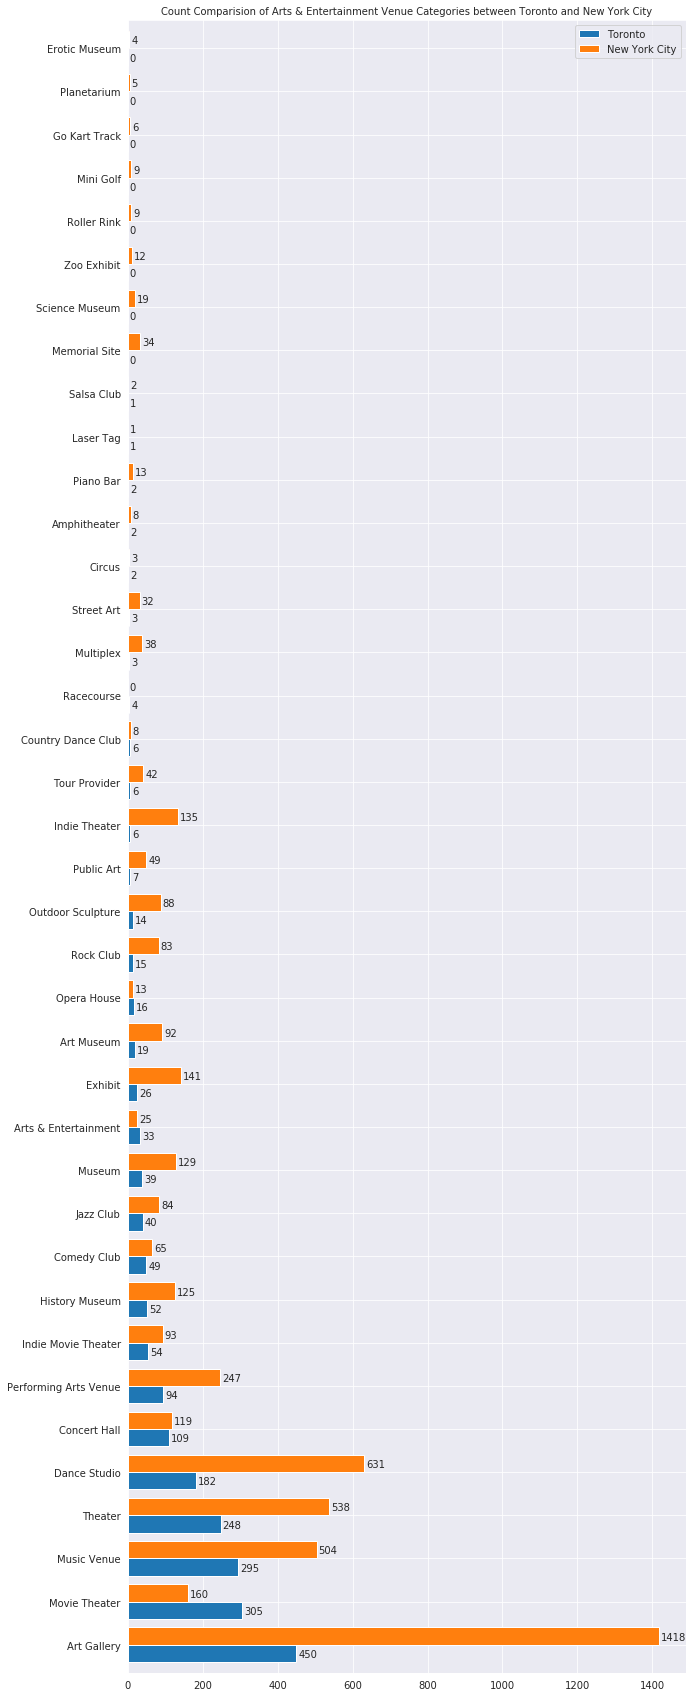

In [207]:
# creating dataframe of Toronto Arts & Entertainment Venue Categories and their counts
ds_toronto_ae_count = toronto_venues_ae['Venue Category'].value_counts()
df_toronto_ae_count = pd.DataFrame(ds_toronto_ae_count).reset_index()
df_toronto_ae_count.columns = ['Venue Category', 'Toronto']

# creating dataframe of New York City Arts & Entertainment Venue Categories and their counts
ds_newyork_ae_count = newyork_venues_ae['Venue Category'].value_counts()
df_newyork_ae_count = pd.DataFrame(ds_newyork_ae_count).reset_index()
df_newyork_ae_count.columns = ['Venue Category', 'New York City']

# creating a full outer join of the above two dataframes
df_ae_tn_outer = pd.merge(df_toronto_ae_count, df_newyork_ae_count, on='Venue Category', how='outer')
df_ae_tn_outer['Toronto'] = df_ae_tn_outer['Toronto'].replace(np.nan, 0)
df_ae_tn_outer['New York City'] = df_ae_tn_outer['New York City'].replace(np.nan, 0)
df_ae_tn_outer = df_ae_tn_outer.astype({"Toronto": int, "New York City": int})
df_ae_tn_outer.rename(columns={'Venue Category': 'Arts & Entertainment Venue Category'}, inplace=True)

# creating a grouped bar plot
ax_ae = df_ae_tn_outer.plot(kind='barh', x='Arts & Entertainment Venue Category', figsize=(10, 30.4), width=.8)
ax_ae.set_title('Count Comparision of Arts & Entertainment Venue Categories between Toronto and New York City', fontsize='medium')
for p in ax_ae.patches:
    ax_ae.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(2, 5), textcoords='offset points', fontsize=10)

ax_ae.set_ylabel("")
ax_ae.get_figure().savefig('df_ae_tn_outer_all.png', bbox_inches = 'tight')

#### 3.3 Exploring Nightlife Spot Venue Category in Toronto and New York City <a name="dataexploratoryanalysisns"></a>

Next, we'll explore the **Toronto** for its *Nightlife Spot* venue categories. We'll then repeat the same analysis for New York City. 

In [208]:
# creating a new dataframe for all the Toronto Nightlife Spot venue categories using the <code>getNearbyVenues</code> funtion
toronto_venues_ns = getNearbyVenues(names=df_postalcodes_toronto['Neighborhood'],
                                 latitudes=df_postalcodes_toronto['Latitude'],
                                 longitudes=df_postalcodes_toronto['Longitude'],
                                 categoryId='4d4b7105d754a06376d81259' # categoryId of 'Nightlife Spot'
                                )

# let's save the dataframe to a .csv file for later use.
toronto_venues_ns.to_csv('toronto_venues_ns.csv', index=False)

In [209]:
toronto_venues_ns = pd.read_csv('toronto_venues_ns.csv')

In [210]:
print(toronto_venues_ns.shape)
toronto_venues_ns.head()

(3331, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Parkwoods              43.753259              -79.329656   
1  Victoria Village              43.725882              -79.315572   
2  Victoria Village              43.725882              -79.315572   
3      Harbourfront              43.654260              -79.360636   
4      Harbourfront              43.654260              -79.360636   

                           Venue  Venue Latitude  Venue Longitude  \
0                The Bing Suites       43.747816       -79.332190   
1           the Birches Catering       43.724762       -79.307020   
2  Lobby Lounge Don Valley Hotel       43.724711       -79.327637   
3       Dominion Pub and Kitchen       43.656919       -79.358967   
4                ODIN Cafe + Bar       43.656739       -79.356503   

    Venue Category  
0  Bed & Breakfast  
1      Event Space  
2           Lounge  
3              Pub  
4             Café

##### 3.3.T.1 Neighborhoods Without Any Food Venues in Toronto

Let's find number of neighborhoods in Toronto after filtering (by 'Nightlife Spot' Venue Category)

In [211]:
toronto_neighborhoods_ns_after = toronto_venues_ns['Neighborhood'].unique()
len(toronto_neighborhoods_ns_after)

175

In [212]:
"Number of unique neighborhoods in Toronto before being filtered by Nightlife Spot venue category was {} but after fitering it has come down to {}. Let us find out the {} neighborhoods that do not have any Nightlife Spot venues around them.".format(len(toronto_neighborhoods_before), len(toronto_neighborhoods_ns_after), len(toronto_neighborhoods_before) - len(toronto_neighborhoods_ns_after) )

'Number of unique neighborhoods in Toronto before being filtered by Nightlife Spot venue category was 209 but after fitering it has come down to 175. Let us find out the 34 neighborhoods that do not have any Nightlife Spot venues around them.'

In [213]:
# Toronto neighborhoods that do not have any Nightlife Spot venues within 1000 meters around them
toronto_neighborhoods_with_no_ns = np.setdiff1d(toronto_neighborhoods_before, toronto_neighborhoods_ns_after)
toronto_neighborhoods_with_no_ns

array(['Agincourt North', 'Albion Gardens', 'Bayview Village',
       'Beaumond Heights', 'Clarks Corners', 'Downsview Central',
       'Downsview Northwest', 'Downsview West', 'Emery', 'Humber Bay',
       'Humbergate', 'Humberlea', 'Jamestown', "King's Mill Park",
       'Kingsway Park South East', "L'Amoreaux East", "L'Amoreaux West",
       'Lawrence Park', 'Milliken', 'Mimico NE', 'Mount Olive',
       'Old Mill South', 'Royal York South East', 'Silver Hills',
       'Silverstone', 'South Steeles', 'Steeles East', 'Sullivan',
       'Sunnylea', "Tam O'Shanter", 'The Queensway East', 'Thistletown',
       'Upper Rouge', 'York Mills'], dtype=object)

In [214]:
# Toronto neighborhoors with no Nightlife Spot venues within 500 meters around them
df_postalcodes_toronto[df_postalcodes_toronto['Neighborhood'].isin(toronto_neighborhoods_with_no_ns)]

Borough              Neighborhood   Latitude  Longitude
68        North York           Bayview Village  43.786947 -79.385975
81        North York              Silver Hills  43.757490 -79.374714
82        North York                York Mills  43.757490 -79.374714
83        North York            Downsview West  43.739015 -79.506944
97        North York         Downsview Central  43.728496 -79.495697
105       North York                     Emery  43.724766 -79.532242
106       North York                 Humberlea  43.724766 -79.532242
110       North York       Downsview Northwest  43.761631 -79.520999
111  Central Toronto             Lawrence Park  43.728020 -79.388790
146      Scarborough            Clarks Corners  43.781638 -79.304302
147      Scarborough                  Sullivan  43.781638 -79.304302
148      Scarborough             Tam O'Shanter  43.781638 -79.304302
154      Scarborough           Agincourt North  43.815252 -79.284577
155      Scarborough           L'Amoreaux East  43.815252 -79.284577
156      Scarborough                  Milliken  43.815252 -79.284577
157      Scarborough              Steeles East  43.815252 -79.284577
173        Etobicoke            Albion Gardens  43.739416 -79.588437
174        Etobicoke          Beaumond Heights  43.739416 -79.588437
175        Etobicoke                Humbergate  43.739416 -79.588437
176        Etobicoke                 Jamestown  43.739416 -79.588437
177        Etobicoke               Mount Olive  43.739416 -79.588437
178        Etobicoke               Silverstone  43.739416 -79.588437
179        Etobicoke             South Steeles  43.739416 -79.588437
180        Etobicoke               Thistletown  43.739416 -79.588437
181      Scarborough           L'Amoreaux West  43.799525 -79.318389
187      Scarborough               Upper Rouge  43.836125 -79.205636
197        Etobicoke                Humber Bay  43.636258 -79.498509
198        Etobicoke          King's Mill Park  43.636258 -79.498509
199        Etobicoke  Kingsway Park South East  43.636258 -79.498509
200        Etobicoke                 Mimico NE  43.636258 -79.498509
201        Etobicoke            Old Mill South  43.636258 -79.498509
202        Etobicoke        The Queensway East  43.636258 -79.498509
203        Etobicoke     Royal York South East  43.636258 -79.498509
204        Etobicoke                  Sunnylea  43.636258 -79.498509

In [215]:
# indices of Toronto neighborhoors with no Nightlife Spot venues within 500 meters around them
toronto_neighborhoods_with_no_ns_indices = df_postalcodes_toronto[df_postalcodes_toronto['Neighborhood'].isin(toronto_neighborhoods_with_no_ns)].index.values
toronto_neighborhoods_with_no_ns_indices

array([ 68,  81,  82,  83,  97, 105, 106, 110, 111, 146, 147, 148, 154,
       155, 156, 157, 173, 174, 175, 176, 177, 178, 179, 180, 181, 187,
       197, 198, 199, 200, 201, 202, 203, 204])

In [216]:
print('There are {} unique Nightlife Spot venue categories.'.format(len(toronto_venues_ns['Venue Category'].unique())))

There are 72 unique Nightlife Spot venue categories.


In [217]:
"Now let's find out what are the most common {} Nightlife Spot venue categories in Toronto.".format(len(toronto_venues_ns['Venue Category'].unique()))

"Now let's find out what are the most common 72 Nightlife Spot venue categories in Toronto."

##### 3.3.T.2 Count of Nightlife Spot Venues by Neighborhood and Nightlife Spot Venue Category in Toronto

Let's create a dataframe for the count of Toronto venues by neighborhood and Nightlife Spot venue category.

In [218]:
toronto_venues_ns_freq_by_neighborhood_and_ns_vc = toronto_venues_ns.groupby(['Neighborhood', 'Venue Category'])['Venue Category'].count().reset_index(name="Count")
toronto_venues_ns_freq_by_neighborhood_and_ns_vc = toronto_venues_ns_freq_by_neighborhood_and_ns_vc.rename(columns = {"Venue Category": "Nightlife Spot Venue Category"}) 
toronto_venues_ns_freq_by_neighborhood_and_ns_vc.head()

Neighborhood Nightlife Spot Venue Category  Count
0     Adelaide           American Restaurant      2
1     Adelaide                     BBQ Joint      2
2     Adelaide                           Bar     14
3     Adelaide                      Beer Bar      8
4     Adelaide            Belgian Restaurant      1

##### 3.3.T.3 Count of Nightlife Spot Venues in each Borough of Toronto

Let's now find count of the Nightlife Spot Venues in each Borough of Toronto. But to do that we need to add the borough of each neighborhood in our dataframe first.

In [219]:
# joining 'toronto_venues_ns_freq_by_neighborhood_and_ns_vc' with 'df_postalcodes_toronto' to add 'Borough' in the dataframe
df_toronto_venues_ns_freq_by_borough = toronto_venues_ns_freq_by_neighborhood_and_ns_vc.join(df_postalcodes_toronto.set_index('Neighborhood'), on='Neighborhood')
df_toronto_venues_ns_freq_by_borough.head()

Neighborhood Nightlife Spot Venue Category  Count           Borough  \
0     Adelaide           American Restaurant      2  Downtown Toronto   
1     Adelaide                     BBQ Joint      2  Downtown Toronto   
2     Adelaide                           Bar     14  Downtown Toronto   
3     Adelaide                      Beer Bar      8  Downtown Toronto   
4     Adelaide            Belgian Restaurant      1  Downtown Toronto   

    Latitude  Longitude  
0  43.650571 -79.384568  
1  43.650571 -79.384568  
2  43.650571 -79.384568  
3  43.650571 -79.384568  
4  43.650571 -79.384568

In [220]:
# showing the 'Count of Nightlife Spot Venues' for each 'Borough'
toronto_venues_ns_freq_by_borough = df_toronto_venues_ns_freq_by_borough.groupby(['Borough'])['Nightlife Spot Venue Category'].count().reset_index(name="Nightlife Spot Venues")
toronto_venues_ns_freq_by_borough = toronto_venues_ns_freq_by_borough.sort_values(by='Nightlife Spot Venues', ascending=False)
toronto_venues_ns_freq_by_borough

Borough  Nightlife Spot Venues
1   Downtown Toronto                    738
9       West Toronto                    137
0    Central Toronto                    129
6         North York                     87
4          Etobicoke                     72
2       East Toronto                     71
8        Scarborough                     55
7       Queen's Park                     28
3          East York                     25
10              York                     21
5        Mississauga                      3

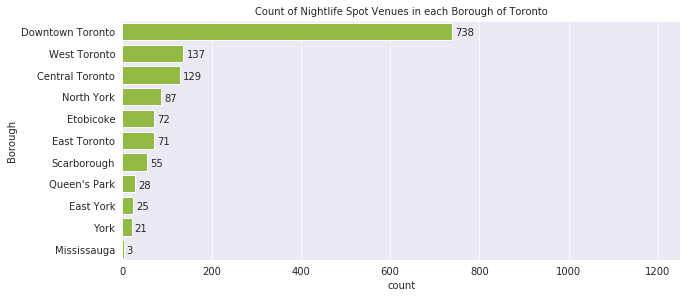

In [221]:
fig = plt.figure(figsize=(10, 4.4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Borough", x="Nightlife Spot Venues", data=toronto_venues_ns_freq_by_borough, color="yellowgreen")
ax.set_xlim(0, 1250)
plt.title("Count of Nightlife Spot Venues in each Borough of Toronto", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Borough")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('toronto_venues_ns_freq_by_borough.png', bbox_inches = 'tight')
plt.show()

##### 3.3.T.4 Count of Nightlife Spot Venues in Each Neighborhood of Toronto

Let's create a dataframe for count of Toronto Nightlife Spot venues by neighborhood.

In [222]:
toronto_venues_ns_freq_by_neighborhood = toronto_venues_ns.groupby(['Neighborhood'])['Venue Category'].count().reset_index(name='Nightlife Spot Venues')
toronto_venues_ns_freq_by_neighborhood = toronto_venues_ns_freq_by_neighborhood.sort_values(by='Nightlife Spot Venues', ascending=False)
toronto_venues_ns_freq_by_neighborhood.head()

Neighborhood  Nightlife Spot Venues
0           Adelaide                    100
18         Chinatown                    100
74              King                    100
31   Design Exchange                    100
116         Richmond                    100

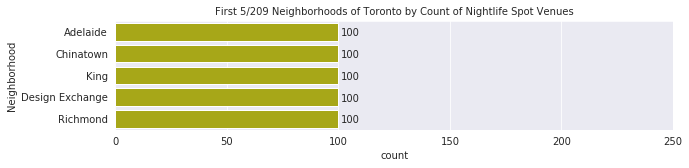

In [223]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Neighborhood", x="Nightlife Spot Venues", data=toronto_venues_ns_freq_by_neighborhood.head(5), color="y")
ax.set_xlim(0, 250)
plt.title("First 5/209 Neighborhoods of Toronto by Count of Nightlife Spot Venues", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Neighborhood")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('toronto_venues_ns_freq_by_neighborhood_first_5.png', bbox_inches = 'tight')
plt.show()

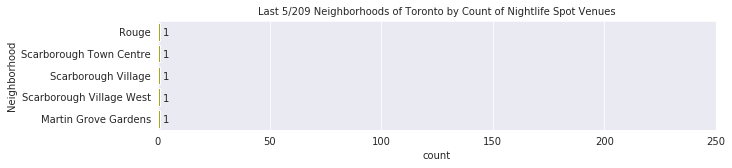

In [224]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Neighborhood", x="Nightlife Spot Venues", data=toronto_venues_ns_freq_by_neighborhood.tail(5), color="y")
ax.set_xlim(0, 250)
plt.title("Last 5/209 Neighborhoods of Toronto by Count of Nightlife Spot Venues", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Neighborhood")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('toronto_venues_ns_freq_by_neighborhood_last_5.png', bbox_inches = 'tight')
plt.show()

##### 3.3.T.5 Count of Nightlife Spot Venues of Nightlife Spot Food Venue Category in Toronto

Let's find out the count of Nightlife Spot Venue Categories in the neighborhoods of Toronoto.

In [225]:
toronto_venues_ns_vc = toronto_venues_ns['Venue Category'].value_counts().to_frame(name='Count').reset_index()
toronto_venues_ns_vc = toronto_venues_ns_vc.rename(columns = {"index": "Nightlife Spot Venue Category"}) 
toronto_venues_ns_vc.head()

Nightlife Spot Venue Category  Count
0                           Bar    713
1                           Pub    405
2                     Gastropub    211
3                        Lounge    194
4                  Cocktail Bar    150

Let's create a simple bar plot of the count of 'Nightlife Spot' venue categories  in *Toronto*.

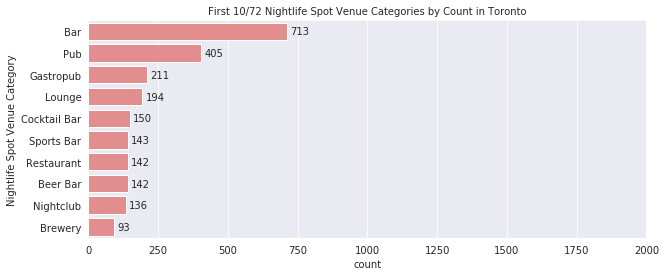

In [226]:
fig = plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Nightlife Spot Venue Category", x="Count", data=toronto_venues_ns_vc.head(10), color="lightcoral")
ax.set_xlim(0, 2000)
plt.title("First 10/72 Nightlife Spot Venue Categories by Count in Toronto", fontsize="medium")
plt.xlabel("count")
plt.ylabel ("Nightlife Spot Venue Category")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')

fig.savefig('toronto_venues_ns_vc_head_10.png', bbox_inches = 'tight')
plt.show()

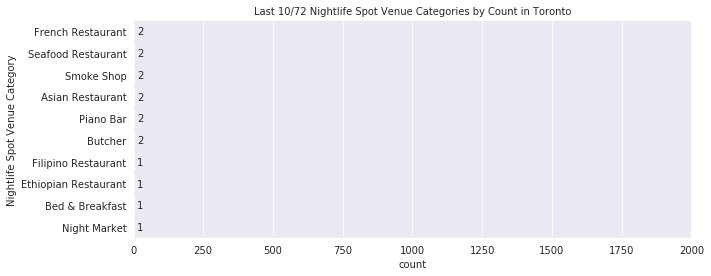

In [227]:
fig = plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Nightlife Spot Venue Category", x="Count", data=toronto_venues_ns_vc.tail(10), color="blue")
ax.set_xlim(0, 2000)
plt.title("Last 10/72 Nightlife Spot Venue Categories by Count in Toronto", fontsize="medium")
plt.xlabel("count")
plt.ylabel ("Nightlife Spot Venue Category")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')

fig.savefig('toronto_venues_ns_vc_tail_10.png', bbox_inches = 'tight')
plt.show()

Now, let's do the same analysis of 'Nightlife Spot' Venue Category for **New York City**.

In [228]:
# creating a new dataframe for all the New York City Nightlife Spot venue categories using the <code>getNearbyVenues</code> funtion
newyork_venues_ns = getNearbyVenues(names=df_newyork_neighborhoods['Neighborhood'],
                                 latitudes=df_newyork_neighborhoods['Latitude'],
                                 longitudes=df_newyork_neighborhoods['Longitude'],
                                 categoryId='4d4b7105d754a06376d81259' # categoryId of 'Nightlife Spot'
                                )

# let's save the dataframe to a .csv file for later use.
newyork_venues_ns.to_csv('newyork_venues_ns.csv', index=False)

In [229]:
newyork_venues_ns = pd.read_csv('newyork_venues_ns.csv')

In [230]:
print(newyork_venues_ns.shape)
newyork_venues_ns.head()

(6169, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4   Co-op City              40.874294              -73.829939   

                  Venue  Venue Latitude  Venue Longitude   Venue Category  
0         M.O.S. Cigars       40.890628       -73.848478       Smoke Shop  
1  k2 bar and lounge bx       40.897937       -73.854786           Lounge  
2     Inn At the Border       40.898248       -73.838641  Other Nightlife  
3         Last Stop Bar       40.902410       -73.851398              Bar  
4            The Garage       40.882165       -73.827593        Nightclub

##### 3.3.N.1 Neighborhoods Without Any Nightlife Spot Venues in New York City

Let's find number of neighborhoods in New York City after filtering (by 'Nightlife Spot' Venue Category)

In [231]:
newyork_neighborhoods_ns_after = newyork_venues_ns['Neighborhood'].unique()
len(newyork_neighborhoods_ns_after)

294

In [232]:
"Number of unique neighborhoods in New York City before being filtered by Nightlife Spot venue categories was {} but after fitering it has come down to {}. Let us find out the {} neighborhoods that do not have any Nightlife Spot venues around them.".format(len(newyork_neighborhoods_before), len(newyork_neighborhoods_ns_after), len(newyork_neighborhoods_before) - len(newyork_neighborhoods_ns_after) )

'Number of unique neighborhoods in New York City before being filtered by Nightlife Spot venue categories was 302 but after fitering it has come down to 294. Let us find out the 8 neighborhoods that do not have any Nightlife Spot venues around them.'

In [233]:
# New York City neighborhoods that do not have any Nightlife Spot venues within 500 meters around them
newyork_neighborhoods_with_no_ns = np.setdiff1d(newyork_neighborhoods_before, newyork_neighborhoods_ns_after)
newyork_neighborhoods_with_no_ns

array(['Edgemere', 'Egbertville', 'Heartland Village', 'Lighthouse Hill',
       'Mill Island', 'Richmond Town', 'South Beach', 'Todt Hill'],
      dtype=object)

In [234]:
# New York City neighborhoors with no Nightlife Spot venues within 500 meters around them
df_newyork_neighborhoods[df_newyork_neighborhoods['Neighborhood'].isin(newyork_neighborhoods_with_no_ns)]

Borough       Neighborhood   Latitude  Longitude
76        Brooklyn        Mill Island  40.606336 -73.908186
176         Queens           Edgemere  40.595642 -73.776133
203  Staten Island          Todt Hill  40.597069 -74.111329
204  Staten Island        South Beach  40.580247 -74.079553
243  Staten Island  Heartland Village  40.589139 -74.159022
251  Staten Island      Richmond Town  40.569606 -74.134057
287  Staten Island        Egbertville  40.579119 -74.127272
292  Staten Island    Lighthouse Hill  40.576506 -74.137927

In [235]:
# indices of New York City neighborhoors with no Nightlife Spot venues within 500 meters around them
newyork_neighborhoods_with_no_ns_indices = df_newyork_neighborhoods[df_newyork_neighborhoods['Neighborhood'].isin(newyork_neighborhoods_with_no_ns)].index.values
newyork_neighborhoods_with_no_ns_indices

array([ 76, 176, 203, 204, 243, 251, 287, 292])

In [236]:
print('There are {} unique Nightlife Spot venue categories.'.format(len(newyork_venues_ns['Venue Category'].unique())))

There are 135 unique Nightlife Spot venue categories.


In [237]:
"Now let's find out what are the most common {} Nightlife Spot venue categories in New York City.".format(len(newyork_venues_ns['Venue Category'].unique()))

"Now let's find out what are the most common 135 Nightlife Spot venue categories in New York City."

##### 3.3.N.2 Count of Nightlife Spot Venues by Neighborhood and Nightlife Spot Venue Category in New York City 

Let's create a dataframe for count of New York City venues by neighborhood and Nightlife Spot venue category.

In [238]:
newyork_venues_ns_freq_by_neighborhood_and_ns_vc = newyork_venues_ns.groupby(['Neighborhood', 'Venue Category'])['Venue Category'].count().reset_index(name="Count")
newyork_venues_ns_freq_by_neighborhood_and_ns_vc = newyork_venues_ns_freq_by_neighborhood_and_ns_vc.rename(columns = {"Venue Category": "Nightlife Spot Venue Category"}) 
newyork_venues_ns_freq_by_neighborhood_and_ns_vc.head()

Neighborhood Nightlife Spot Venue Category  Count
0     Allerton                           Bar      2
1     Allerton                       Brewery      1
2     Allerton                         Diner      1
3     Allerton               Other Nightlife      1
4     Annadale                  Cocktail Bar      1

##### 3.3.N.3 Count of Nightlife Spot Venues in each Borough of New York City

Let's now find count of the Nightlife Spot Venues in each Borough of New York City. But to do that we need to add the borough of each neighborhood in our dataframe first.


In [239]:
# joining 'newyork_venues_ns_freq_by_neighborhood_and_ns_vc' with 'df_newyork_neighborhoods' to add 'Borough' in the dataframe
df_newyork_venues_ns_freq_by_borough = newyork_venues_ns_freq_by_neighborhood_and_ns_vc.join(df_newyork_neighborhoods.set_index('Neighborhood'), on='Neighborhood')
df_newyork_venues_ns_freq_by_borough.head(5)

Neighborhood Nightlife Spot Venue Category  Count        Borough   Latitude  \
0     Allerton                           Bar      2          Bronx  40.865788   
1     Allerton                       Brewery      1          Bronx  40.865788   
2     Allerton                         Diner      1          Bronx  40.865788   
3     Allerton               Other Nightlife      1          Bronx  40.865788   
4     Annadale                  Cocktail Bar      1  Staten Island  40.538114   

   Longitude  
0 -73.859319  
1 -73.859319  
2 -73.859319  
3 -73.859319  
4 -74.178549

In [240]:
# showing the 'Count of Nightlife Spot Venues' for each 'Borough' in New York City
newyork_venues_ns_freq_by_borough = df_newyork_venues_ns_freq_by_borough.groupby(['Borough'])['Nightlife Spot Venue Category'].count().reset_index(name="Nightlife Spot Venues")
newyork_venues_ns_freq_by_borough = newyork_venues_ns_freq_by_borough.sort_values(by='Nightlife Spot Venues', ascending=False)
newyork_venues_ns_freq_by_borough

Borough  Nightlife Spot Venues
2      Manhattan                   1112
1       Brooklyn                    752
3         Queens                    528
4  Staten Island                    236
0          Bronx                    233

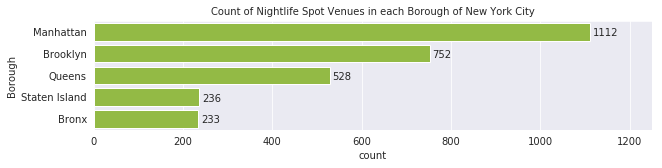

In [241]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Borough", x="Nightlife Spot Venues", data=newyork_venues_ns_freq_by_borough, color='yellowgreen')
ax.set_xlim(0, 1250)
plt.title("Count of Nightlife Spot Venues in each Borough of New York City", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Borough")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('newyork_venues_ns_freq_by_borough.png', bbox_inches = 'tight')
plt.show()

##### 3.3.N.4 Count of Nightlife Spot Venues in Each Neighborhood of  New York City 

Let's create a dataframe for count of New York City Nightlife Spot venues by neighborhood.

In [242]:
newyork_venues_ns_freq_by_neighborhood = newyork_venues_ns.groupby(['Neighborhood'])['Venue Category'].count().reset_index(name='Nightlife Spot Venues')
newyork_venues_ns_freq_by_neighborhood = newyork_venues_ns_freq_by_neighborhood.sort_values(by='Nightlife Spot Venues', ascending=False)
newyork_venues_ns_freq_by_neighborhood.head()

Neighborhood  Nightlife Spot Venues
181    Murray Hill                    122
49         Chelsea                    105
171  Midtown South                    100
170        Midtown                    100
132   Hudson Yards                    100

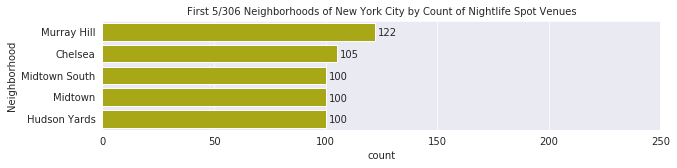

In [243]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Neighborhood", x="Nightlife Spot Venues", data=newyork_venues_ns_freq_by_neighborhood.head(5), color="y")
ax.set_xlim(0, 250)
plt.title("First 5/306 Neighborhoods of New York City by Count of Nightlife Spot Venues", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Neighborhood")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('newyork_venues_ns_freq_by_neighborhood_first_5.png', bbox_inches = 'tight')
plt.show()

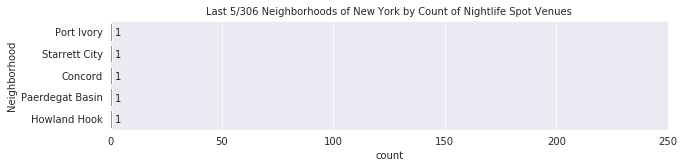

In [244]:
fig = plt.figure(figsize=(10, 2))
sns.set_style('darkgrid')
ax=sns.barplot(y="Neighborhood", x="Nightlife Spot Venues", data=newyork_venues_ns_freq_by_neighborhood.tail(5), color="y")
ax.set_xlim(0, 250)
plt.title("Last 5/306 Neighborhoods of New York by Count of Nightlife Spot Venues", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Neighborhood")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -13), textcoords='offset points')

fig.savefig('newyork_venues_ns_freq_by_neighborhood_last_5.png', bbox_inches = 'tight')
plt.show()

##### 3.3.N.5 Count of Nightlife Spot Venues of Each Nightlife Spot Venue Category in New York City

Let's find out the count of Nightlife Spot Venue Categories in the neighborhoods of New York City.

In [245]:
newyork_venues_ns_vc = newyork_venues_ns['Venue Category'].value_counts().to_frame(name='Count').reset_index()
newyork_venues_ns_vc = newyork_venues_ns_vc.rename(columns = {"index": "Nightlife Spot Venue Category"}) 
newyork_venues_ns_vc.head()

Nightlife Spot Venue Category  Count
0                           Bar   1538
1                  Cocktail Bar    540
2                        Lounge    450
3                      Wine Bar    337
4                           Pub    267

Let's create a simple bar plot of the count of 'Nightlife Spot' venue categories  in *New York City*.

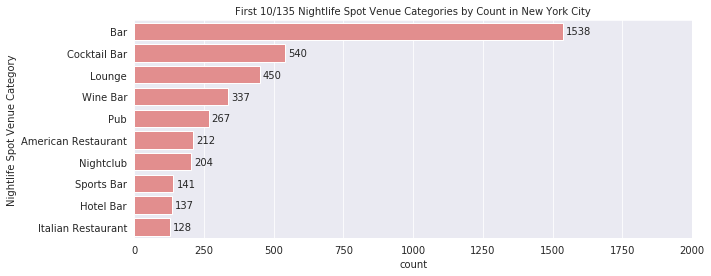

In [246]:
fig = plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Nightlife Spot Venue Category", x="Count", data=newyork_venues_ns_vc.head(10), color="lightcoral")
ax.set_xlim(0, 2000)
plt.title("First 10/135 Nightlife Spot Venue Categories by Count in New York City", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Nightlife Spot Venue Category")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')
fig.savefig('newyork_venues_ns_vc_head_10.png', bbox_inches = 'tight')
plt.show()

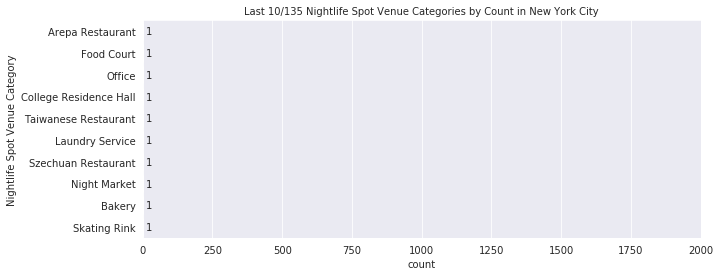

In [247]:
fig = plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Nightlife Spot Venue Category", x="Count", data=newyork_venues_ns_vc.tail(10), color="blue")
ax.set_xlim(0, 2000)
plt.title("Last 10/135 Nightlife Spot Venue Categories by Count in New York City", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("Nightlife Spot Venue Category")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')
fig.savefig('newyork_venues_ns_vc_tail_10.png', bbox_inches = 'tight')
plt.show()

##### 3.3.N.6 Nightlife Spot Venue Categories Found in New York City, but Not in Toronto

In [248]:
"So Toronto has {} unique Nightlife Spot venue categories whereas New York City has {} unique Nightlife Spot venue categories.".format(len(toronto_venues_ns['Venue Category'].unique()), len(newyork_venues_ns['Venue Category'].unique()))

'So Toronto has 72 unique Nightlife Spot venue categories whereas New York City has 135 unique Nightlife Spot venue categories.'

In [249]:
# unique Nightlife Spot venue categories in Toronto
toronto_ns_vc = toronto_venues_ns['Venue Category'].unique()

# unique Nightlife Spot venue categories in New York City
newyork_ns_vc = newyork_venues_ns['Venue Category'].unique()

Let's find out the Nightlife Spot venue categories that are available in New York City but *not* in Toronto.

In [250]:
newyork_ns_vc_not_in_toronto = np.setdiff1d(newyork_ns_vc, toronto_ns_vc)
print("The number of unique venue categories found in New York City, but not in Toronto are", len(newyork_ns_vc_not_in_toronto))
newyork_ns_vc_not_in_toronto

The number of unique venue categories found in New York City, but not in Toronto are 73


array(['African Restaurant', 'Arepa Restaurant', 'Art Gallery',
       'Australian Restaurant', 'Bakery', 'Beer Store', 'Bookstore',
       'Brazilian Restaurant', 'Building', 'Cajun / Creole Restaurant',
       'Caribbean Restaurant', 'Cheese Shop', 'Chinese Restaurant',
       'College Residence Hall', 'Colombian Restaurant',
       'Coworking Space', 'Cuban Restaurant', 'Distillery',
       'Eastern European Restaurant', 'English Restaurant',
       'Food & Drink Shop', 'Food Court', 'Food Truck',
       'Fried Chicken Joint', 'General Entertainment',
       'German Restaurant', 'Gourmet Shop', 'Greek Restaurant',
       'Harbor / Marina', 'Hostel', 'Ice Cream Shop', 'Indian Restaurant',
       'Indie Movie Theater', 'Indie Theater', 'Juice Bar',
       'Latin American Restaurant', 'Laundry Service',
       'Lebanese Restaurant', 'Market', 'Mexican Restaurant',
       'Middle Eastern Restaurant', 'Modern European Restaurant',
       'Nail Salon', 'Other Nightlife', 'Paella Restauran

In [251]:
"Let's find the count of each of these {} Nightlife Spot Venue Categories in the neighborhoods of New York City.".format(len(newyork_ns_vc_not_in_toronto))

"Let's find the count of each of these 73 Nightlife Spot Venue Categories in the neighborhoods of New York City."

In [252]:
newyork_ns_vc_not_in_toronto_count = newyork_venues_ns[newyork_venues_ns['Venue Category'].isin(newyork_ns_vc_not_in_toronto)]['Venue Category'].value_counts().rename_axis('Nightlife Spot Venue Category').reset_index(name='Count')
newyork_ns_vc_not_in_toronto_count.head(10)

Nightlife Spot Venue Category  Count
0            Mexican Restaurant     65
1          Caribbean Restaurant     32
2              Tapas Restaurant     30
3     Latin American Restaurant     26
4             German Restaurant     25
5                     Roof Deck     22
6                     Wine Shop     18
7               Other Nightlife     18
8                     Rock Club     17
9                      Tiki Bar     15

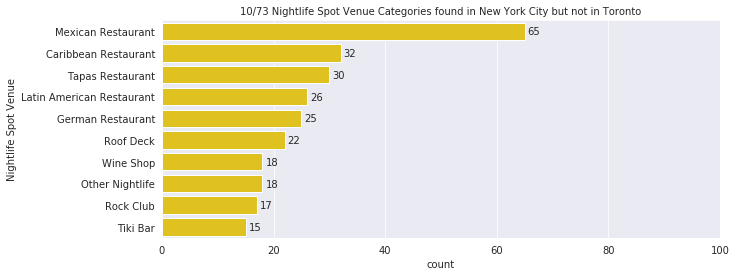

In [253]:
fig = plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Nightlife Spot Venue Category", x="Count", data=newyork_ns_vc_not_in_toronto_count.head(10), color="gold")
ax.set_xlim(0, 100)
plt.title("10/73 Nightlife Spot Venue Categories found in New York City but not in Toronto", fontsize='medium')
plt.xlabel("count")
plt.ylabel("Nightlife Spot Venue")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')

# fig.savefig('newyork_ns_vc_not_in_toronto_count.png', bbox_inches = 'tight')
plt.show()

In [254]:
display_side_by_side(newyork_ns_vc_not_in_toronto_count[0:20], newyork_ns_vc_not_in_toronto_count[20:40], newyork_ns_vc_not_in_toronto_count[40:60], newyork_ns_vc_not_in_toronto_count[60:80])

Nightlife Spot Venue Category 
 Count 
 
 
 
 
 0 
 Mexican Restaurant 
 65 
 
 
 1 
 Caribbean Restaurant 
 32 
 
 
 2 
 Tapas Restaurant 
 30 
 
 
 3 
 Latin American Restaurant 
 26 
 
 
 4 
 German Restaurant 
 25 
 
 
 5 
 Roof Deck 
 22 
 
 
 6 
 Wine Shop 
 18 
 
 
 7 
 Other Nightlife 
 18 
 
 
 8 
 Rock Club 
 17 
 
 
 9 
 Tiki Bar 
 15 
 
 
 10 
 Beer Store 
 11 
 
 
 11 
 Indian Restaurant 
 11 
 
 
 12 
 Southern / Soul Food Restaurant 
 10 
 
 
 13 
 Sandwich Place 
 9 
 
 
 14 
 Taco Place 
 8 
 
 
 15 
 English Restaurant 
 8 
 
 
 16 
 Vietnamese Restaurant 
 8 
 
 
 17 
 South American Restaurant 
 8 
 
 
 18 
 Cuban Restaurant 
 8 
 
 
 19 
 Spanish Restaurant 
 6 
 
 
 
 
 
 
 Nightlife Spot Venue Category 
 Count 
 
 
 
 
 20 
 Performing Arts Venue 
 6 
 
 
 21 
 Tea Room 
 6 
 
 
 22 
 Fried Chicken Joint 
 5 
 
 
 23 
 Cajun / Creole Restaurant 
 5 
 
 
 24 
 Australian Restaurant 
 5 
 
 
 25 
 Lebanese Restaurant 
 5 
 
 
 26 
 Turkish Restaurant 
 5 
 
 
 27 
 Brazilian Restaurant 
 5 
 
 
 28 
 African Restaurant 
 4 
 
 
 29 
 Chinese Restaurant 
 4 
 
 
 30 
 Coworking Space 
 4 
 
 
 31 
 Distillery 
 3 
 
 
 32 
 Greek Restaurant 
 3 
 
 
 33 
 Hostel 
 3 
 
 
 34 
 Salon / Barbershop 
 3 
 
 
 35 
 Gourmet Shop 
 3 
 
 
 36 
 Cheese Shop 
 3 
 
 
 37 
 Art Gallery 
 3 
 
 
 38 
 Harbor / Marina 
 3 
 
 
 39 
 General Entertainment 
 3 
 
 
 
 
 
 
 Nightlife Spot Venue Category 
 Count 
 
 
 
 
 40 
 Food Truck 
 3 
 
 
 41 
 Juice Bar 
 3 
 
 
 42 
 Ice Cream Shop 
 3 
 
 
 43 
 Nail Salon 
 2 
 
 
 44 
 Street Food Gathering 
 2 
 
 
 45 
 Tech Startup 
 2 
 
 
 46 
 Russian Restaurant 
 2 
 
 
 47 
 Paella Restaurant 
 2 
 
 
 48 
 Residential Building (Apartment / Condo) 
 2 
 
 
 49 
 Middle Eastern Restaurant 
 2 
 
 
 50 
 Theater 
 2 
 
 
 51 
 Colombian Restaurant 
 2 
 
 
 52 
 Snack Place 
 2 
 
 
 53 
 Indie Movie Theater 
 2 
 
 
 54 
 Vegetarian / Vegan Restaurant 
 2 
 
 
 55 
 Szechuan Restaurant 
 1 
 
 
 56 
 Skating Rink 
 1 
 
 
 57 
 Food Court 
 1 
 
 
 58 
 Eastern European Restaurant 
 1 
 
 
 59 
 College Residence Hall 
 1 
 
 
 
 
 
 
 Nightlife Spot Venue Category 
 Count 
 
 
 
 
 60 
 Modern European Restaurant 
 1 
 
 
 61 
 Bookstore 
 1 
 
 
 62 
 Indie Theater 
 1 
 
 
 63 
 Bakery 
 1 
 
 
 64 
 Pool 
 1 
 
 
 65 
 Market 
 1 
 
 
 66 
 Scenic Lookout 
 1 
 
 
 67 
 Laundry Service 
 1 
 
 
 68 
 Building 
 1 
 
 
 69 
 Arepa Restaurant 
 1 
 
 
 70 
 Professional & Other Places 
 1 
 
 
 71 
 Food & Drink Shop 
 1 
 
 
 72 
 Taiwanese Restaurant 
 1

##### 3.3.T.6 Nightlife Spot Venue Categories Found in Toronto, but Not in New York City

Let's find out the Nightlife Spot venue categories that are available in Toronto but *not* in New York City.

In [255]:
toronto_ns_vc_not_in_newyork = np.setdiff1d(toronto_ns_vc, newyork_ns_vc)
print("The number of unique venue categories found in Toronto, but not in New York City are", len(toronto_ns_vc_not_in_newyork))
toronto_ns_vc_not_in_newyork

The number of unique venue categories found in Toronto, but not in New York City are 10


array(['Bed & Breakfast', 'Breakfast Spot', 'Butcher',
       'College Cafeteria', 'Ethiopian Restaurant',
       'Fast Food Restaurant', 'Filipino Restaurant',
       'Hawaiian Restaurant', 'Ramen Restaurant', 'Social Club'],
      dtype=object)

In [256]:
"Let's find the count of the {} Venue Categories in the neighborhoods of Toronto.".format(len(toronto_ns_vc_not_in_newyork))

"Let's find the count of the 10 Venue Categories in the neighborhoods of Toronto."

In [257]:
toronto_ns_vc_not_in_newyork_count = toronto_venues_ns[toronto_venues_ns['Venue Category'].isin(toronto_ns_vc_not_in_newyork)]['Venue Category'].value_counts().rename_axis('Nightlife Spot Venue Category').reset_index(name='Count')
toronto_ns_vc_not_in_newyork_count

Nightlife Spot Venue Category  Count
0                Breakfast Spot     14
1          Fast Food Restaurant     11
2                   Social Club      6
3             College Cafeteria      5
4              Ramen Restaurant      3
5           Hawaiian Restaurant      2
6                       Butcher      2
7          Ethiopian Restaurant      1
8           Filipino Restaurant      1
9               Bed & Breakfast      1

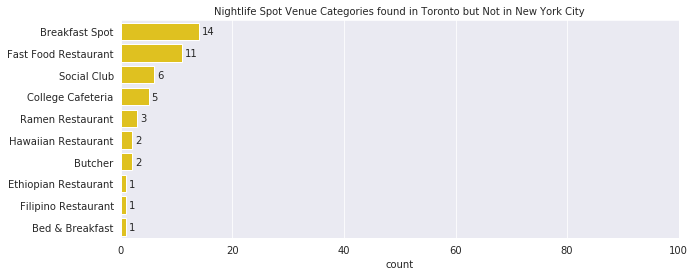

In [258]:
fig = plt.figure(figsize=(10, 4))
sns.set_style('darkgrid')
ax=sns.barplot(y="Nightlife Spot Venue Category", x="Count", data=toronto_ns_vc_not_in_newyork_count, color="gold")
ax.set_xlim(0, 100)
plt.title("Nightlife Spot Venue Categories found in Toronto but Not in New York City", fontsize='medium')
plt.xlabel("count")
plt.ylabel ("")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(3, -12), textcoords='offset points')

fig.savefig('toronto_ns_vc_not_in_newyork_count.png', bbox_inches = 'tight')
plt.show()

##### 3.3.T.7 First 4 Nightlife Spot Venue Categories by Count in Each Borough of Toronto

Now let's analyse each neighborhood of **Toronto** for Nightlife Spot Venue Category. Later, we'll repeat the same exercise for New York City.

In [259]:
# one hot encoding
toronto_onehot_ns = pd.get_dummies(toronto_venues_ns[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot_ns['Neighborhood'] = toronto_venues_ns['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [toronto_onehot_ns.columns[-1]] + list(toronto_onehot_ns.columns[:-1])
toronto_onehot_ns = toronto_onehot_ns[fixed_columns]
print(toronto_onehot_ns.shape)

toronto_onehot_ns.head()

(3331, 73)


Neighborhood  American Restaurant  Arcade  Asian Restaurant  BBQ Joint  \
0         Parkwoods                    0       0                 0          0   
1  Victoria Village                    0       0                 0          0   
2  Victoria Village                    0       0                 0          0   
3      Harbourfront                    0       0                 0          0   
4      Harbourfront                    0       0                 0          0   

   Bar  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Belgian Restaurant  \
0    0          0                1         0            0                   0   
1    0          0                0         0            0                   0   
2    0          0                0         0            0                   0   
3    0          0                0         0            0                   0   
4    0          0                0         0            0                   0   

   Bistro  Boat or Ferry  Bowling Alley  Breakfast Spot  Brewery  \
0       0              0              0               0        0   
1       0              0              0               0        0   
2       0              0              0               0        0   
3       0              0              0               0        0   
4       0              0              0               0        0   

   Burger Joint  Butcher  Café  Cocktail Bar  Coffee Shop  College Cafeteria  \
0             0        0     0             0            0                  0   
1             0        0     0             0            0                  0   
2             0        0     0             0            0                  0   
3             0        0     0             0            0                  0   
4             0        0     1             0            0                  0   

   Comedy Club  Comfort Food Restaurant  Diner  Dive Bar  \
0            0                        0      0         0   
1            0                        0      0         0   
2            0                        0      0         0   
3            0                        0      0         0   
4            0                        0      0         0   

   Ethiopian Restaurant  Event Space  Fast Food Restaurant  \
0                     0            0                     0   
1                     0            1                     0   
2                     0            0                     0   
3                     0            0                     0   
4                     0            0                     0   

   Filipino Restaurant  French Restaurant  Gastropub  Gay Bar  \
0                    0                  0          0        0   
1                    0                  0          0        0   
2                    0                  0          0        0   
3                    0                  0          0        0   
4                    0                  0          0        0   

   Hawaiian Restaurant  Hookah Bar  Hotel  Hotel Bar  Irish Pub  \
0                    0           0      0          0          0   
1                    0           0      0          0          0   
2                    0           0      0          0          0   
3                    0           0      0          0          0   
4                    0           0      0          0          0   

   Italian Restaurant  Japanese Restaurant  Jazz Club  Karaoke Bar  \
0                   0                    0          0            0   
1                   0                    0          0            0   
2                   0                    0          0            0   
3                   0                    0          0            0   
4                   0                    0          0            0   

   Korean Restaurant  Liquor Store  Lounge  Mediterranean Restaurant  \
0                  0             0       0                         0   
1                  0             0       0        

Now let's draw a Bar Plot of the first 4 Nightlife Spot venue categories by their count in each Borough of Toronto.
Earlier we found that Bar, Pub, Gastropub and Cocktail Bar were the first 4 Nightlife Spot venue categories by count in Toronto. 

In [260]:
df_toronto_venues_bar_freq_by_borough = df_toronto_venues_ns_freq_by_borough[df_toronto_venues_ns_freq_by_borough['Nightlife Spot Venue Category'].isin(["Bar"])]
df_toronto_bar_borough = df_toronto_venues_bar_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Bar').reset_index()

df_toronto_venues_pub_freq_by_borough = df_toronto_venues_ns_freq_by_borough[df_toronto_venues_ns_freq_by_borough['Nightlife Spot Venue Category'].isin(["Pub"])]
df_toronto_pub_borough = df_toronto_venues_pub_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Pub').reset_index()

df_toronto_venues_gastropub_freq_by_borough = df_toronto_venues_ns_freq_by_borough[df_toronto_venues_ns_freq_by_borough['Nightlife Spot Venue Category'].isin(["Gastropub"])]
df_toronto_gastropub_borough = df_toronto_venues_gastropub_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Gastropub').reset_index()

# df_toronto_venues_cocktail_freq_by_borough = df_toronto_venues_ns_freq_by_borough[df_toronto_venues_ns_freq_by_borough['Nightlife Spot Venue Category'].isin(["Cocktail Bar"])]
# df_toronto_cocktail_borough = df_toronto_venues_cocktail_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Cocktail Bar').reset_index()

# dfs = [df_toronto_bar_borough, df_toronto_pub_borough, df_toronto_gastropub_borough, df_toronto_cocktail_borough]

df_toronto_venues_lounge_freq_by_borough = df_toronto_venues_ns_freq_by_borough[df_toronto_venues_ns_freq_by_borough['Nightlife Spot Venue Category'].isin(["Lounge"])]
df_toronto_lounge_borough = df_toronto_venues_lounge_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Lounge').reset_index()

dfs = [df_toronto_bar_borough, df_toronto_pub_borough, df_toronto_gastropub_borough, df_toronto_lounge_borough]

df_toronto_4_mc_ns_vc = reduce(lambda left, right: pd.merge(left, right, on='Borough', how='outer'), dfs)
df_toronto_4_mc_ns_vc['Bar'] = df_toronto_4_mc_ns_vc['Bar'].replace(np.nan, 0)
df_toronto_4_mc_ns_vc = df_toronto_4_mc_ns_vc.astype({"Bar": int})
df_toronto_4_mc_ns_vc['Pub'] = df_toronto_4_mc_ns_vc['Pub'].replace(np.nan, 0)
df_toronto_4_mc_ns_vc = df_toronto_4_mc_ns_vc.astype({"Pub": int})
df_toronto_4_mc_ns_vc['Gastropub'] = df_toronto_4_mc_ns_vc['Gastropub'].replace(np.nan, 0)
df_toronto_4_mc_ns_vc = df_toronto_4_mc_ns_vc.astype({"Gastropub": int})
df_toronto_4_mc_ns_vc['Lounge'] = df_toronto_4_mc_ns_vc['Lounge'].replace(np.nan, 0)
df_toronto_4_mc_ns_vc = df_toronto_4_mc_ns_vc.astype({"Lounge": int})
# df_toronto_4_mc_ns_vc['Cocktail Bar'] = df_toronto_4_mc_ns_vc['Cocktail Bar'].replace(np.nan, 0)
# df_toronto_4_mc_ns_vc = df_toronto_4_mc_ns_vc.astype({"Cocktail Bar": int})
df_toronto_4_mc_ns_vc

Borough  Bar  Pub  Gastropub  Lounge
0   Central Toronto   27   50         17      15
1  Downtown Toronto  418  247        142     117
2      East Toronto   25   27          9       3
3         East York    4    5          5       0
4         Etobicoke    8   15          6      12
5        North York   34    8          3       5
6      Queen's Park   12   11          5       4
7       Scarborough   19    9          0       4
8      West Toronto  153   33         23      34
9              York   17    3          3       0

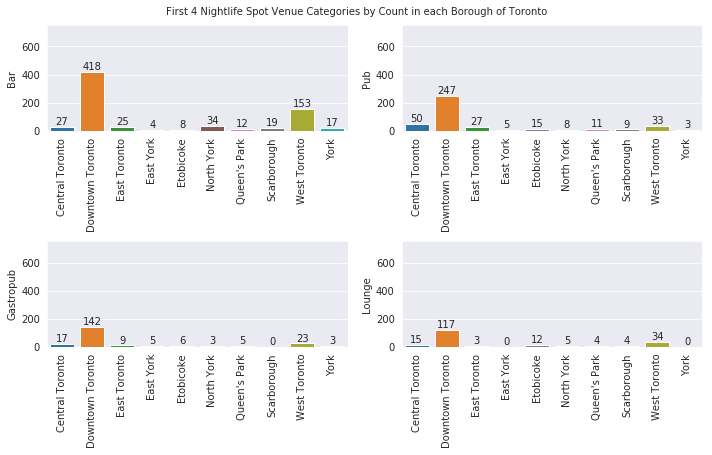

In [261]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 6.4))

sns.barplot(x="Borough", y="Bar", data=df_toronto_4_mc_ns_vc, ax=axarr[0][0]);
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 750)
for tick in axarr[0,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.barplot(x="Borough", y="Pub", data=df_toronto_4_mc_ns_vc, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 750)
for tick in axarr[0,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.barplot(x="Borough", y="Gastropub", data=df_toronto_4_mc_ns_vc, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 750)
for tick in axarr[1,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.barplot(x="Borough", y="Lounge", data=df_toronto_4_mc_ns_vc, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 750)
for tick in axarr[1,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.94)
fig.suptitle('First 4 Nightlife Spot Venue Categories by Count in each Borough of Toronto', fontsize='medium')
fig.savefig('df_toronto_4_mc_ns_vc.png', bbox_inches = 'tight')
plt.show()

##### 3.3.T.8 1st, 2nd, 3rd and 4th Most Common Nightlife Spot Venue in the Neighborhoods of Toronto

Let's group the rows by neighborhood and taking the mean of the frequency of occurrence of each *Nightlife Spot* Value category

In [262]:
toronto_grouped_ns = toronto_onehot_ns.groupby('Neighborhood').mean().reset_index()
toronto_grouped_ns.head()

Neighborhood  American Restaurant  Arcade  Asian Restaurant  BBQ Joint  \
0        Adelaide                 0.02     0.0               0.0       0.02   
1       Agincourt                 0.00     0.0               0.0       0.00   
2       Alderwood                 0.00     0.0               0.0       0.00   
3  Bathurst Manor                 0.00     0.0               0.0       0.00   
4   Bathurst Quay                 0.00     0.0               0.0       0.00   

        Bar  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  \
0  0.140000        0.0              0.0      0.08          0.0   
1  0.250000        0.0              0.0      0.00          0.0   
2  0.000000        0.0              0.0      0.00          0.0   
3  0.750000        0.0              0.0      0.00          0.0   
4  0.666667        0.0              0.0      0.00          0.0   

   Belgian Restaurant  Bistro  Boat or Ferry  Bowling Alley  Breakfast Spot  \
0                0.01    0.01       0.000000           0.01            0.01   
1                0.00    0.00       0.000000           0.00            0.00   
2                0.00    0.00       0.000000           0.00            0.00   
3                0.00    0.00       0.000000           0.00            0.00   
4                0.00    0.00       0.333333           0.00            0.00   

   Brewery  Burger Joint  Butcher  Café  Cocktail Bar  Coffee Shop  \
0      0.0           0.0      0.0   0.0          0.05          0.0   
1      0.0           0.0      0.0   0.0          0.00          0.0   
2      0.0           0.0      0.0   0.0          0.00          0.0   
3      0.0           0.0      0.0   0.0          0.00          0.0   
4      0.0           0.0      0.0   0.0          0.00          0.0   

   College Cafeteria  Comedy Club  Comfort Food Restaurant  Diner  Dive Bar  \
0                0.0         0.01                      0.0    0.0      0.01   
1                0.0         0.00                      0.0    0.0      0.00   
2                0.0         0.00                      0.0    0.0      0.25   
3                0.0         0.00                      0.0    0.0      0.00   
4                0.0         0.00                      0.0    0.0      0.00   

   Ethiopian Restaurant  Event Space  Fast Food Restaurant  \
0                   0.0          0.0                  0.01   
1                   0.0          0.0                  0.00   
2                   0.0          0.0                  0.00   
3                   0.0          0.0                  0.00   
4                   0.0          0.0                  0.00   

   Filipino Restaurant  French Restaurant  Gastropub  Gay Bar  \
0                 0.00                0.0       0.07     0.01   
1                 0.25                0.0       0.00     0.00   
2                 0.00                0.0       0.00     0.00   
3                 0.00                0.0       0.25     0.00   
4                 0.00                0.0       0.00     0.00   

   Hawaiian Restaurant  Hookah Bar  Hotel  Hotel Bar  Irish Pub  \
0                  0.0        0.01   0.01       0.02       0.01   
1                  0.0        0.00   0.00       0.00       0.00   
2                  0.0        0.00   0.00       0.00       0.00   
3                  0.0        0.00   0.00       0.00       0.00   
4                  0.0        0.00   0.00       0.00       0.00   

   Italian Restaurant  Japanese Restaurant  Jazz Club  Karaoke Bar  \
0                0.02                 0.02       0.01         0.01   
1                0.00                 0.00       0.00         0.25   
2                0.00                 0.00       0.00         0.00   
3                0.00                 0.00       0.00         0.00   
4                0.00                 0.00       0.00         0.00   

   Korean Restaurant  Liquor Store  Lounge  Mediterranean Restaurant  \
0                0.0           0.0    0.04                       0.0   
1                0.0          

Now let's create a pandas dataframe to display the top 10 Nightlife Spot venues for each neighborhood.

In [263]:
num_top_ns_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_ns_venues):
    try:
        columns.append('{}{} Most Common Nightlife Spot Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Nightlife Spot Venue'.format(ind+1))

# create a new dataframe
toronto_neighborhoods_ns_venues_sorted = pd.DataFrame(columns=columns)
toronto_neighborhoods_ns_venues_sorted['Neighborhood'] = toronto_grouped_ns['Neighborhood']

for ind in np.arange(toronto_grouped_ns.shape[0]):
    toronto_neighborhoods_ns_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped_ns.iloc[ind, :], num_top_ns_venues)

toronto_neighborhoods_ns_venues_sorted.head()

Neighborhood 1st Most Common Nightlife Spot Venue  \
0        Adelaide                                  Bar   
1       Agincourt                                  Bar   
2       Alderwood                                  Pub   
3  Bathurst Manor                                  Bar   
4   Bathurst Quay                                  Bar   

  2nd Most Common Nightlife Spot Venue 3rd Most Common Nightlife Spot Venue  \
0                                  Pub                             Beer Bar   
1                          Karaoke Bar                  Filipino Restaurant   
2                             Dive Bar                                 Café   
3                            Gastropub                          Wings Joint   
4                        Boat or Ferry                          Wings Joint   

  4th Most Common Nightlife Spot Venue 5th Most Common Nightlife Spot Venue  \
0                            Gastropub                         Cocktail Bar   
1                               Lounge                          Wings Joint   
2                         Cocktail Bar                          Coffee Shop   
3                          Event Space                    College Cafeteria   
4                          Event Space                    College Cafeteria   

  6th Most Common Nightlife Spot Venue 7th Most Common Nightlife Spot Venue  \
0                           Sports Bar                           Restaurant   
1                 Ethiopian Restaurant                    College Cafeteria   
2                    College Cafeteria                          Comedy Club   
3                          Comedy Club              Comfort Food Restaurant   
4                          Comedy Club              Comfort Food Restaurant   

  8th Most Common Nightlife Spot Venue 9th Most Common Nightlife Spot Venue  \
0                             Wine Bar                               Lounge   
1                          Comedy Club              Comfort Food Restaurant   
2              Comfort Food Restaurant                                Diner   
3                                Diner                             Dive Bar   
4                                Diner                             Dive Bar   

  10th Most Common Nightlife Spot Venue  
0                             Speakeasy  
1                                 Diner  
2                           Wings Joint  
3                  Ethiopian Restaurant  
4                  Ethiopian Restaurant

In [264]:
print('The shape of toronto_neighborhoods_ns_venues_sorted is', toronto_neighborhoods_ns_venues_sorted.shape)

The shape of toronto_neighborhoods_ns_venues_sorted is (175, 11)


Now let's draw a plot for the 1st, 2nd, 3rd and 4th Most Common Nightlife Spot Venue in the neighborhoods of Toronto.

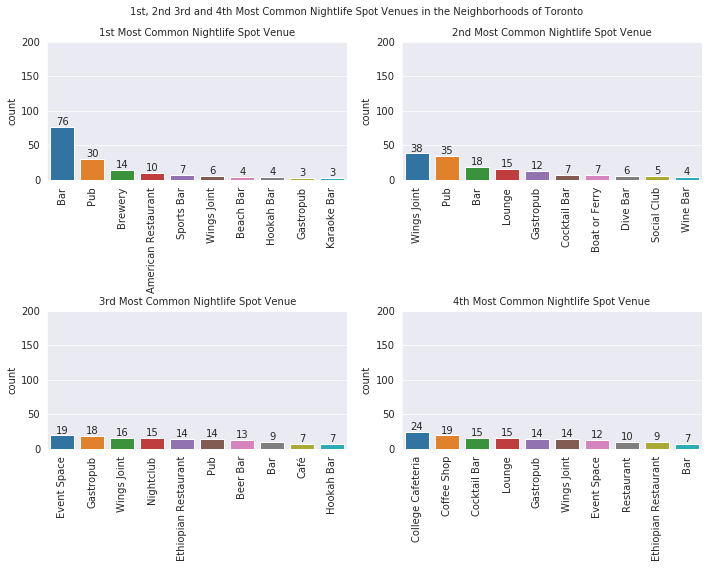

In [265]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 8))

sns.countplot(x="1st Most Common Nightlife Spot Venue", data=toronto_neighborhoods_ns_venues_sorted, 
                 order=toronto_neighborhoods_ns_venues_sorted["1st Most Common Nightlife Spot Venue"].value_counts().iloc[:10].index, ax=axarr[0][0])
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 200)
axarr[0,0].set_title('1st Most Common Nightlife Spot Venue', fontsize='medium')
for tick in axarr[0,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="2nd Most Common Nightlife Spot Venue", data=toronto_neighborhoods_ns_venues_sorted, 
                 order=toronto_neighborhoods_ns_venues_sorted["2nd Most Common Nightlife Spot Venue"].value_counts().iloc[:10].index, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 200)
axarr[0,1].set_title('2nd Most Common Nightlife Spot Venue', fontsize='medium')
for tick in axarr[0,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="3rd Most Common Nightlife Spot Venue", data=toronto_neighborhoods_ns_venues_sorted, 
                 order=toronto_neighborhoods_ns_venues_sorted["3rd Most Common Nightlife Spot Venue"].value_counts().iloc[:10].index, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 200)
axarr[1,0].set_title('3rd Most Common Nightlife Spot Venue', fontsize='medium')
for tick in axarr[1,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="4th Most Common Nightlife Spot Venue", data=toronto_neighborhoods_ns_venues_sorted, 
                 order=toronto_neighborhoods_ns_venues_sorted["4th Most Common Nightlife Spot Venue"].value_counts().iloc[:10].index, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 200)
axarr[1,1].set_title('4th Most Common Nightlife Spot Venue', fontsize='medium')
for tick in axarr[1,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle('1st, 2nd 3rd and 4th Most Common Nightlife Spot Venues in the Neighborhoods of Toronto', fontsize='medium')
fig.savefig('df_toronto_4_mc_ns_vc_all.png', bbox_inches = 'tight')
plt.show()

##### 3.3.N.7 First 4 Nightlife Spot Venue Categories by Count in Each Borough of New York City

Just like we analysed each neighborhood of *Toronto* for *Nightlife Spot* Venue Category. Let's do the same analysis for **New York City** now.

In [266]:
# one hot encoding
newyork_onehot_ns = pd.get_dummies(newyork_venues_ns[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot_ns['Neighborhood'] = newyork_venues_ns['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [newyork_onehot_ns.columns[-1]] + list(newyork_onehot_ns.columns[:-1])
newyork_onehot_ns = newyork_onehot_ns[fixed_columns]
print(newyork_onehot_ns.shape)

newyork_onehot_ns.head()

(6169, 136)


Neighborhood  African Restaurant  American Restaurant  Arcade  \
0    Wakefield                   0                    0       0   
1    Wakefield                   0                    0       0   
2    Wakefield                   0                    0       0   
3    Wakefield                   0                    0       0   
4   Co-op City                   0                    0       0   

   Arepa Restaurant  Art Gallery  Asian Restaurant  Australian Restaurant  \
0                 0            0                 0                      0   
1                 0            0                 0                      0   
2                 0            0                 0                      0   
3                 0            0                 0                      0   
4                 0            0                 0                      0   

   BBQ Joint  Bakery  Bar  Beach Bar  Beer Bar  Beer Garden  Beer Store  \
0          0       0    0          0         0            0           0   
1          0       0    0          0         0            0           0   
2          0       0    0          0         0            0           0   
3          0       0    1          0         0            0           0   
4          0       0    0          0         0            0           0   

   Belgian Restaurant  Bistro  Boat or Ferry  Bookstore  Bowling Alley  \
0                   0       0              0          0              0   
1                   0       0              0          0              0   
2                   0       0              0          0              0   
3                   0       0              0          0              0   
4                   0       0              0          0              0   

   Brazilian Restaurant  Brewery  Building  Burger Joint  Café  \
0                     0        0         0             0     0   
1                     0        0         0             0     0   
2                     0        0         0             0     0   
3                     0        0         0             0     0   
4                     0        0         0             0     0   

   Cajun / Creole Restaurant  Caribbean Restaurant  Cheese Shop  \
0                          0                     0            0   
1                          0                     0            0   
2                          0                     0            0   
3                          0                     0            0   
4                          0                     0            0   

   Chinese Restaurant  Cocktail Bar  Coffee Shop  College Residence Hall  \
0                   0             0            0                       0   
1                   0             0            0                       0   
2                   0             0            0                       0   
3                   0             0            0                       0   
4                   0             0            0                       0   

   Colombian Restaurant  Comedy Club  Comfort Food Restaurant  \
0                     0            0                        0   
1                     0            0                        0   
2                     0            0                        0   
3                     0            0                        0   
4                     0            0                        0   

   Coworking Space  Cuban Restaurant  Diner  Distillery  Dive Bar  \
0                0                 0      0           0         0   
1                0                 0      0           0         0   
2                0                 0      0           0         0   
3                0                 0      0           0         0   
4                0                 0      0           0         0   

   Eastern European Restaurant  English Restaurant  Event Space  \
0                            0                   0            0   
1                            0             

Just like we did for Toronto, let's draw a Bar Plot of First 4 Nightlife Spot Venue Categories by their Count in each Borough of New York City. Earlier we found that Bar, Cocktail Bar, Lounge and Wine Bar were the first 4 Nightlife Spot venue categories by count in New York City.

In [267]:
df_newyork_venues_bar_freq_by_borough = df_newyork_venues_ns_freq_by_borough[df_newyork_venues_ns_freq_by_borough['Nightlife Spot Venue Category'].isin(["Bar"])]
df_newyork_bar_borough = df_newyork_venues_bar_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Bar').reset_index()

df_newyork_venues_cocktail_freq_by_borough = df_newyork_venues_ns_freq_by_borough[df_newyork_venues_ns_freq_by_borough['Nightlife Spot Venue Category'].isin(["Cocktail Bar"])]
df_newyork_cocktail_borough = df_newyork_venues_cocktail_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Cocktail Bar').reset_index()

df_newyork_venues_lounge_freq_by_borough = df_newyork_venues_ns_freq_by_borough[df_newyork_venues_ns_freq_by_borough['Nightlife Spot Venue Category'].isin(["Lounge"])]
df_newyork_lounge_borough = df_newyork_venues_lounge_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Lounge').reset_index()

df_newyork_venues_wine_freq_by_borough = df_newyork_venues_ns_freq_by_borough[df_newyork_venues_ns_freq_by_borough['Nightlife Spot Venue Category'].isin(["Wine Bar"])]
df_newyork_wine_borough = df_newyork_venues_wine_freq_by_borough.groupby(['Borough'])['Count'].sum().to_frame(name='Wine Bar').reset_index()

dfs = [df_newyork_bar_borough, df_newyork_cocktail_borough, df_newyork_lounge_borough, df_newyork_wine_borough]

df_newyork_4_mc_ns_vc = reduce(lambda left, right: pd.merge(left, right, on='Borough', how='outer'), dfs)
df_newyork_4_mc_ns_vc['Bar'] = df_newyork_4_mc_ns_vc['Bar'].replace(np.nan, 0)
df_newyork_4_mc_ns_vc = df_newyork_4_mc_ns_vc.astype({"Bar": int})
df_newyork_4_mc_ns_vc['Lounge'] = df_newyork_4_mc_ns_vc['Lounge'].replace(np.nan, 0)
df_newyork_4_mc_ns_vc = df_newyork_4_mc_ns_vc.astype({"Lounge": int})
df_newyork_4_mc_ns_vc['Wine Bar'] = df_newyork_4_mc_ns_vc['Wine Bar'].replace(np.nan, 0)
df_newyork_4_mc_ns_vc = df_newyork_4_mc_ns_vc.astype({"Wine Bar": int})
df_newyork_4_mc_ns_vc['Cocktail Bar'] = df_newyork_4_mc_ns_vc['Cocktail Bar'].replace(np.nan, 0)
df_newyork_4_mc_ns_vc = df_newyork_4_mc_ns_vc.astype({"Cocktail Bar": int})
df_newyork_4_mc_ns_vc


Borough  Bar  Cocktail Bar  Lounge  Wine Bar
0          Bronx  130             5      52         9
1       Brooklyn  521           147     153        73
2      Manhattan  536           358     163       214
3         Queens  292            34      76        32
4  Staten Island  103            16      18        29

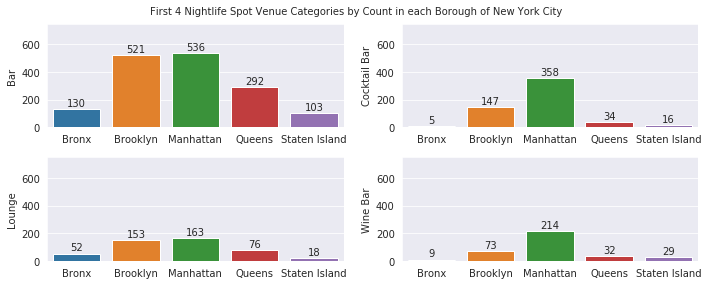

In [268]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 4))

sns.barplot(x="Borough", y="Bar", data=df_newyork_4_mc_ns_vc, ax=axarr[0][0]);
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 750)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 3), textcoords='offset points')

sns.barplot(x="Borough", y="Cocktail Bar", data=df_newyork_4_mc_ns_vc, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 750)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 3), textcoords='offset points')

sns.barplot(x="Borough", y="Lounge", data=df_newyork_4_mc_ns_vc, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 750)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 3), textcoords='offset points')

sns.barplot(x="Borough", y="Wine Bar", data=df_newyork_4_mc_ns_vc, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 750)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 3), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle('First 4 Nightlife Spot Venue Categories by Count in each Borough of New York City', fontsize='medium')
fig.savefig('df_newyork_4_mc_ns_vc_bar.png', bbox_inches = 'tight')
plt.show()

##### 3.3.N.8 1st, 2nd, 3rd and 4th Most Common Nightlife Spot Venue in the Neighborhoods of New York City

Let's group the rows by neighborhood and taking the mean of the frequency of occurrence of each *Nightlife Spot* Value category

In [269]:
newyork_grouped_ns = newyork_onehot_ns.groupby('Neighborhood').mean().reset_index()
newyork_grouped_ns.head()

Neighborhood  African Restaurant  American Restaurant  Arcade  \
0       Allerton                 0.0                  0.0     0.0   
1       Annadale                 0.0                  0.0     0.0   
2  Arden Heights                 0.0                  0.0     0.0   
3      Arlington                 0.0                  0.0     0.0   
4       Arrochar                 0.0                  0.0     0.0   

   Arepa Restaurant  Art Gallery  Asian Restaurant  Australian Restaurant  \
0               0.0          0.0               0.0                    0.0   
1               0.0          0.0               0.0                    0.0   
2               0.0          0.0               0.0                    0.0   
3               0.0          0.0               0.0                    0.0   
4               0.0          0.0               0.0                    0.0   

   BBQ Joint  Bakery       Bar  Beach Bar  Beer Bar  Beer Garden  Beer Store  \
0        0.0     0.0  0.400000        0.0       0.0          0.0         0.0   
1        0.0     0.0  0.000000        0.0       0.0          0.0         0.0   
2        0.0     0.0  0.333333        0.0       0.0          0.0         0.0   
3        0.0     0.0  0.400000        0.0       0.0          0.0         0.0   
4        0.0     0.0  0.666667        0.0       0.0          0.0         0.0   

   Belgian Restaurant  Bistro  Boat or Ferry  Bookstore  Bowling Alley  \
0                 0.0     0.0            0.0        0.0            0.0   
1                 0.0     0.0            0.0        0.0            0.0   
2                 0.0     0.0            0.0        0.0            0.0   
3                 0.0     0.0            0.0        0.0            0.0   
4                 0.0     0.0            0.0        0.0            0.0   

   Brazilian Restaurant  Brewery  Building  Burger Joint  Café  \
0                   0.0      0.2       0.0           0.0   0.0   
1                   0.0      0.0       0.0           0.0   0.0   
2                   0.0      0.0       0.0           0.0   0.0   
3                   0.0      0.2       0.0           0.0   0.0   
4                   0.0      0.0       0.0           0.0   0.0   

   Cajun / Creole Restaurant  Caribbean Restaurant  Cheese Shop  \
0                        0.0                   0.0          0.0   
1                        0.0                   0.0          0.0   
2                        0.0                   0.0          0.0   
3                        0.0                   0.0          0.0   
4                        0.0                   0.0          0.0   

   Chinese Restaurant  Cocktail Bar  Coffee Shop  College Residence Hall  \
0                 0.0      0.000000          0.0                     0.0   
1                 0.0      0.333333          0.0                     0.0   
2                 0.0      0.000000          0.0                     0.0   
3                 0.0      0.000000          0.0                     0.0   
4                 0.0      0.000000          0.0                     0.0   

   Colombian Restaurant  Comedy Club  Comfort Food Restaurant  \
0                   0.0          0.0                      0.0   
1                   0.0          0.0                      0.0   
2                   0.0          0.0                      0.0   
3                   0.0          0.0                      0.0   
4                   0.0          0.0                      0.0   

   Coworking Space  Cuban Restaurant  Diner  Distillery  Dive Bar  \
0              0.0               0.0    0.2         0.0       0.0   
1              0.0               0.0    0.0         0.0       0.0   
2              0.0               0.0    0.0         0.0       0.0   
3              0.0               0.0    0.0         0.0       0.0   
4              0.0               0.0    0.0         0.0       0.0   

   Eastern European Restaurant  English Restaurant  Event Space  \
0                          0.0                 0.0          0.0   
1  

Now let's create a pandas dataframe to display the top 10 Nightlife Spot venues for each neighborhood.

In [270]:
num_top_ns_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_ns_venues):
    try:
        columns.append('{}{} Most Common Nightlife Spot Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Nightlife Spot Venue'.format(ind+1))

# create a new dataframe
newyork_neighborhoods_ns_venues_sorted = pd.DataFrame(columns=columns)
newyork_neighborhoods_ns_venues_sorted['Neighborhood'] = newyork_grouped_ns['Neighborhood']

for ind in np.arange(newyork_grouped_ns.shape[0]):
    newyork_neighborhoods_ns_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped_ns.iloc[ind, :], num_top_ns_venues)

newyork_neighborhoods_ns_venues_sorted.head()

Neighborhood 1st Most Common Nightlife Spot Venue  \
0       Allerton                                  Bar   
1       Annadale                           Sports Bar   
2  Arden Heights                             Wine Bar   
3      Arlington                                  Bar   
4       Arrochar                                  Bar   

  2nd Most Common Nightlife Spot Venue 3rd Most Common Nightlife Spot Venue  \
0                                Diner                              Brewery   
1                         Cocktail Bar                                  Pub   
2                                  Pub                                  Bar   
3                       Nightlife Spot                              Gay Bar   
4                           Steakhouse                          Wings Joint   

  4th Most Common Nightlife Spot Venue 5th Most Common Nightlife Spot Venue  \
0                      Other Nightlife                          Wings Joint   
1                          Wings Joint                          Event Space   
2                          Wings Joint                          Event Space   
3                              Brewery                General Entertainment   
4                General Entertainment                            Gastropub   

  6th Most Common Nightlife Spot Venue 7th Most Common Nightlife Spot Venue  \
0                            Gastropub                  Fried Chicken Joint   
1                    French Restaurant                           Food Truck   
2                  Fried Chicken Joint                    French Restaurant   
3                            Gastropub                  Fried Chicken Joint   
4                  Fried Chicken Joint                    French Restaurant   

  8th Most Common Nightlife Spot Venue 9th Most Common Nightlife Spot Venue  \
0                    French Restaurant                           Food Truck   
1                           Food Court                    Food & Drink Shop   
2                           Food Truck                           Food Court   
3                    French Restaurant                           Food Truck   
4                           Food Truck                           Food Court   

  10th Most Common Nightlife Spot Venue  
0                            Food Court  
1           Eastern European Restaurant  
2                     Food & Drink Shop  
3                           Wings Joint  
4                     Food & Drink Shop

In [271]:
print('The shape of newyork_neighborhoods_ns_venues_sorted is', newyork_neighborhoods_ns_venues_sorted.shape)

The shape of newyork_neighborhoods_ns_venues_sorted is (294, 11)


Now let's draw a plot for the 1st, 2nd, 3rd and 4th Most Common Nightlife Spot Venue in the neighborhoods of New York City. 

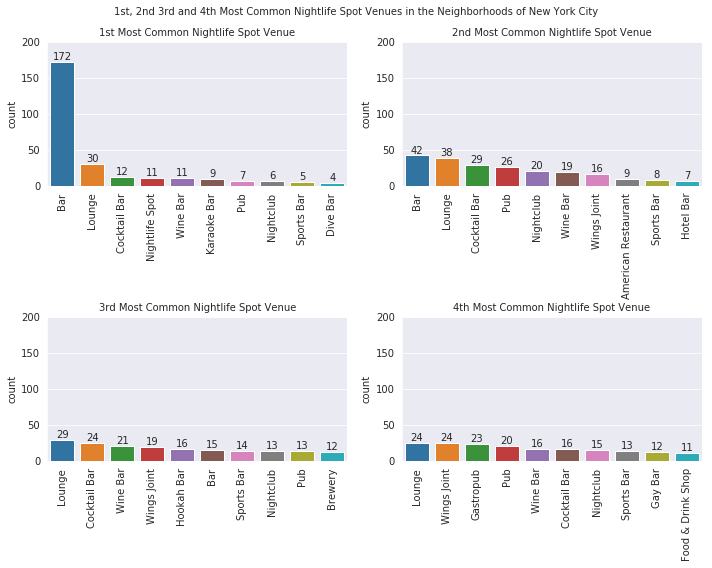

In [272]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 8))

sns.countplot(x="1st Most Common Nightlife Spot Venue", data=newyork_neighborhoods_ns_venues_sorted, 
                 order=newyork_neighborhoods_ns_venues_sorted["1st Most Common Nightlife Spot Venue"].value_counts().iloc[:10].index, ax=axarr[0][0])
axarr[0,0].set_xlabel('')
axarr[0,0].set_ylim(0, 200)
axarr[0,0].set_title('1st Most Common Nightlife Spot Venue', fontsize='medium')
for tick in axarr[0,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,0].patches:
    axarr[0,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="2nd Most Common Nightlife Spot Venue", data=newyork_neighborhoods_ns_venues_sorted, 
                 order=newyork_neighborhoods_ns_venues_sorted["2nd Most Common Nightlife Spot Venue"].value_counts().iloc[:10].index, ax=axarr[0][1])
axarr[0,1].set_xlabel('')
axarr[0,1].set_ylim(0, 200)
axarr[0,1].set_title('2nd Most Common Nightlife Spot Venue', fontsize='medium')
for tick in axarr[0,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[0,1].patches:
    axarr[0,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="3rd Most Common Nightlife Spot Venue", data=newyork_neighborhoods_ns_venues_sorted, 
                 order=newyork_neighborhoods_ns_venues_sorted["3rd Most Common Nightlife Spot Venue"].value_counts().iloc[:10].index, ax=axarr[1][0])
axarr[1,0].set_xlabel('')
axarr[1,0].set_ylim(0, 200)
axarr[1,0].set_title('3rd Most Common Nightlife Spot Venue', fontsize='medium')
for tick in axarr[1,0].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,0].patches:
    axarr[1,0].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

sns.countplot(x="4th Most Common Nightlife Spot Venue", data=newyork_neighborhoods_ns_venues_sorted, 
                 order=newyork_neighborhoods_ns_venues_sorted["4th Most Common Nightlife Spot Venue"].value_counts().iloc[:10].index, ax=axarr[1][1])
axarr[1,1].set_xlabel('')
axarr[1,1].set_ylim(0, 200)
axarr[1,1].set_title('4th Most Common Nightlife Spot Venue', fontsize='medium')
for tick in axarr[1,1].get_xticklabels():
        tick.set_rotation(90)
for p in axarr[1,1].patches:
    axarr[1,1].annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height()),
                        ha="center", xytext=(0, 2), textcoords='offset points')

fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.suptitle('1st, 2nd 3rd and 4th Most Common Nightlife Spot Venues in the Neighborhoods of New York City', fontsize='medium')
fig.savefig('df_newyork_4_mc_ns_vc_all.png', bbox_inches = 'tight')
plt.show()

##### 3.3.T.9 Cluster the Neighborhoods in Toronto based on Nightlife Spot Venue Categories

Let's **Cluster the Neighborhoods in Toronto** next to determine similar neighborhoods based on Nightlife Spot venue categories. But first, let's find out the optimum value of k using Elbow Method.

Sqaured Error (Cost) [61.26298270780029, 47.82405360701215, 43.59641829921987, 39.804726063453316, 36.75835433651137, 33.14772283832619, 30.221378998612636, 27.016128148951505, 24.5803929885177, 23.42025948404263, 21.78910456115986]
Elbow Point 3


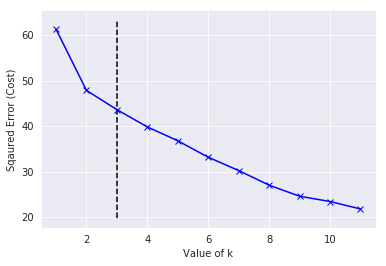

In [273]:
# cluster dataset
toronto_grouped_ns_clustering = toronto_grouped_ns.drop('Neighborhood', 1)

cost =[] 
for i in range(1, 12): 
    KM = KMeans(n_clusters = i, random_state=0) 
    KM.fit(toronto_grouped_ns_clustering)       
    cost.append(KM.inertia_)  
    
print("Sqaured Error (Cost)", cost)
  
k = range(1, len(cost)+1)

kn = KneeLocator(k, cost, curve='convex', direction='decreasing')
t_ns_knee = kn.knee
print("Elbow Point", t_ns_knee)
plt.xlabel('Value of k')
plt.ylabel('Sqaured Error (Cost)')
plt.plot(k, cost, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [274]:
"As the Elbow Point turns out to be {}, we'll run *k*-means to cluster the neighborhood into {} clusters".format(t_ns_knee, t_ns_knee)

"As the Elbow Point turns out to be 3, we'll run *k*-means to cluster the neighborhood into 3 clusters"

In [275]:
# set number of clusters
kclusters = t_ns_knee

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_ns_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0], dtype=int32)

In [276]:
# drop clustering labels if already inserted
# toronto_neighborhoods_ns_venues_sorted = toronto_neighborhoods_ns_venues_sorted.drop('Cluster Labels', axis=1)

# add clustering labels
toronto_neighborhoods_ns_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# toronto_neighborhoods_with_no_ns_indices do not have any Nightlife Spot venues 1000 meters around it, so let's drop them.
# execute the following line just once
toronto_merged_ns = df_postalcodes_toronto.drop(df_postalcodes_toronto.index[toronto_neighborhoods_with_no_ns_indices]) 

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged_ns = toronto_merged_ns.join(toronto_neighborhoods_ns_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged_ns.head() # check the last columns!

Borough      Neighborhood   Latitude  Longitude  Cluster Labels  \
0        North York         Parkwoods  43.753259 -79.329656               0   
1        North York  Victoria Village  43.725882 -79.315572               0   
2  Downtown Toronto      Harbourfront  43.654260 -79.360636               0   
3  Downtown Toronto       Regent Park  43.654260 -79.360636               0   
4        North York  Lawrence Heights  43.718518 -79.464763               0   

  1st Most Common Nightlife Spot Venue 2nd Most Common Nightlife Spot Venue  \
0                      Bed & Breakfast                          Wings Joint   
1                          Event Space                               Lounge   
2                                  Pub                            Gastropub   
3                                  Pub                            Gastropub   
4                                  Pub                                  Bar   

  3rd Most Common Nightlife Spot Venue 4th Most Common Nightlife Spot Venue  \
0                          Event Space                    College Cafeteria   
1                 Ethiopian Restaurant                          Coffee Shop   
2                              Brewery                                  Bar   
3                              Brewery                                  Bar   
4                        Bowling Alley                         Cocktail Bar   

  5th Most Common Nightlife Spot Venue 6th Most Common Nightlife Spot Venue  \
0                          Comedy Club              Comfort Food Restaurant   
1                    College Cafeteria                          Comedy Club   
2                                 Café                          Beer Garden   
3                                 Café                          Beer Garden   
4                          Wings Joint                             Dive Bar   

  7th Most Common Nightlife Spot Venue 8th Most Common Nightlife Spot Venue  \
0                                Diner                             Dive Bar   
1              Comfort Food Restaurant                                Diner   
2                          Event Space                           Sports Bar   
3                          Event Space                           Sports Bar   
4                    College Cafeteria                          Comedy Club   

  9th Most Common Nightlife Spot Venue 10th Most Common Nightlife Spot Venue  
0                 Ethiopian Restaurant                  Fast Food Restaurant  
1                             Dive Bar                           Wings Joint  
2                            Speakeasy                          Burger Joint  
3                            Speakeasy                          Burger Joint  
4              Comfort Food Restaurant                                 Diner

Let's visualize the resulting clusters now.

In [277]:
# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_ns['Latitude'], toronto_merged_ns['Longitude'], toronto_merged_ns['Neighborhood'], toronto_merged_ns['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label, #map not rendering with popup specified
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, let's examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

In [278]:
# Cluster 0
toronto_merged_ns.loc[toronto_merged_ns['Cluster Labels'] == 0, toronto_merged_ns.columns[[1] + list(range(5, toronto_merged_ns.shape[1]))]]

Neighborhood  \
0                                            Parkwoods   
1                                     Victoria Village   
2                                         Harbourfront   
3                                          Regent Park   
4                                     Lawrence Heights   
5                                       Lawrence Manor   
6                                         Queen's Park   
7                                     Islington Avenue   
8                                                Rouge   
9                                              Malvern   
10                                     Don Mills North   
11                                    Woodbine Gardens   
12                                       Parkview Hill   
13                                             Ryerson   
14                                     Garden District   
16                                          Cloverdale   
17                                           Islington   
18                                        Martin Grove   
19                                    Princess Gardens   
20                                     West Deane Park   
24                                     Flemingdon Park   
25                                     Don Mills South   
35                                         The Beaches   
36                                         Berczy Park   
38                                              Woburn   
40                                  Central Bay Street   
41                                            Christie   
42                                           Cedarbrae   
43                                   Hillcrest Village   
48                                            Adelaide   
49                                                King   
50                                            Richmond   
59                                        East Toronto   
60                                   Harbourfront East   
61                                     Toronto Islands   
62                                       Union Station   
63                                     Little Portugal   
64                                             Trinity   
71                                   The Danforth West   
72                                           Riverdale   
73                                     Design Exchange   
74                             Toronto Dominion Centre   
75                                            Brockton   
76                                    Exhibition Place   
77                                    Parkdale Village   
78                                            Clairlea   
79                                         Golden Mile   
80                                            Oakridge   
84                                    The Beaches West   
85                                        India Bazaar   
86                                      Commerce Court   
87                                      Victoria Hotel   
88                                           Downsview   
89                                          North Park   
90                                         Upwood Park   
91                                       Humber Summit   
95                                         Newtonbrook   
96                                          Willowdale   
98                                     Studio District   
99                                        Bedford Park   
100                                Lawrence Manor East   
107                                        Birch Cliff   
108                                     Cliffside West   
109                                   Willowdale South   
112                                           Roselawn   
114                                          Runnymede   
115                                             Weston   
119                                    York Mills West   
120                                   Da

In [279]:
# Cluster 1
toronto_merged_ns.loc[toronto_merged_ns['Cluster Labels'] == 1, toronto_merged_ns.columns[[1] + list(range(5, toronto_merged_ns.shape[1]))]]

Neighborhood 1st Most Common Nightlife Spot Venue  \
15              Glencairn                                  Bar   
21         Highland Creek                                  Bar   
22             Rouge Hill                                  Bar   
23             Port Union                                  Bar   
27     Humewood-Cedarvale                                  Bar   
28      Bloordale Gardens                                  Bar   
29               Eringate                                  Bar   
30          Markland Wood                                  Bar   
31      Old Burnhamthorpe                                  Bar   
37    Caledonia-Fairbanks                                  Bar   
44         Bathurst Manor                                  Bar   
45        Downsview North                                  Bar   
46         Wilson Heights                                  Bar   
51     Dovercourt Village                                  Bar   
52               Dufferin                                  Bar   
65   East Birchmount Park                                  Bar   
66                Ionview                                  Bar   
67           Kennedy Park                                  Bar   
69            CFB Toronto                                  Bar   
70         Downsview East                                  Bar   
101               Del Ray                                  Bar   
102            Keelesdale                                  Bar   
103          Mount Dennis                                  Bar   
104           Silverthorn                                  Bar   
121     Forest Hill North                                  Bar   
122      Forest Hill West                                  Bar   
123             High Park                                  Bar   
124    The Junction South                                  Bar   
125             Westmount                                  Bar   
163              CN Tower                                  Bar   
164         Bathurst Quay                                  Bar   
165        Island airport                                  Bar   
166     Harbourfront West                                  Bar   
167      King and Spadina                                  Bar   
168         Railway Lands                                  Bar   
169         South Niagara                                  Bar   

    2nd Most Common Nightlife Spot Venue 3rd Most Common Nightlife Spot Venue  \
15                            Hookah Bar                                  Pub   
21                           Wings Joint                          Event Space   
22                           Wings Joint                          Event Space   
23                           Wings Joint                          Event Space   
27                             Gastropub                       Breakfast Spot   
28                           Wings Joint                          Event Space   
29                           Wings Joint                          Event Space   
30                           Wings Joint                          Event Space   
31                           Wings Joint                          Event Space   
37                              Dive Bar                             Beer Bar   
44                             Gastropub                          Wings Joint   
45                             Gastropub                          Wings Joint   
46                             Gastropub                          Wings Joint   
51                               Brewery                          Wings Joint   
52                               Brewery                          Wings Joint   
65                              Sake Bar                          Wings Joint   
66                              Sake Bar                          Wings Joint   
67                              Sake Bar                          Wings Joint   
69                           Wi

In [280]:
# Cluster 2
toronto_merged_ns.loc[toronto_merged_ns['Cluster Labels'] == 2, toronto_merged_ns.columns[[1] + list(range(5, toronto_merged_ns.shape[1]))]]

Neighborhood 1st Most Common Nightlife Spot Venue  \
26           Woodbine Heights                              Brewery   
32                  Guildwood                           Sports Bar   
33                Morningside                           Sports Bar   
34                  West Hill                           Sports Bar   
39                    Leaside                              Brewery   
47           Thorncliffe Park                              Brewery   
53        Scarborough Village                           Sports Bar   
54                   Fairview                              Brewery   
55                 Henry Farm                              Brewery   
56                     Oriole                              Brewery   
57             Northwood Park                                  Bar   
58            York University                                  Bar   
92                 Cliffcrest                           Sports Bar   
93                  Cliffside                           Sports Bar   
94   Scarborough Village West                           Sports Bar   
113        The Junction North                              Brewery   
116               Dorset Park                              Brewery   
117   Scarborough Town Centre                              Brewery   
118           Wexford Heights                              Brewery   

    2nd Most Common Nightlife Spot Venue 3rd Most Common Nightlife Spot Venue  \
26                                   Pub                                  Bar   
32                             Nightclub                                  Bar   
33                             Nightclub                                  Bar   
34                             Nightclub                                  Bar   
39                            Sports Bar                          Wings Joint   
47                              Wine Bar                            Gastropub   
53                           Wings Joint                 Ethiopian Restaurant   
54                                   Bar                           Sports Bar   
55                                   Bar                           Sports Bar   
56                                   Bar                           Sports Bar   
57                            Sports Bar                           Hookah Bar   
58                            Sports Bar                           Hookah Bar   
92                           Wings Joint                 Ethiopian Restaurant   
93                           Wings Joint                 Ethiopian Restaurant   
94                           Wings Joint                 Ethiopian Restaurant   
113                                  Bar                             Dive Bar   
116                          Wings Joint                         Cocktail Bar   
117                          Wings Joint                         Cocktail Bar   
118                          Wings Joint                         Cocktail Bar   

    4th Most Common Nightlife Spot Venue 5th Most Common Nightlife Spot Venue  \
26                           Wings Joint                 Ethiopian Restaurant   
32                            Restaurant                          Wings Joint   
33                            Restaurant                          Wings Joint   
34                            Restaurant                          Wings Joint   
39                  Ethiopian Restaurant                          Coffee Shop   
47                  Ethiopian Restaurant                          Coffee Shop   
53                           Coffee Shop                    College Cafeteria   
54                           Wings Joint                 Ethiopian Restaurant   
55                           Wings Joint                 Ethiopian Restaurant   
56                           Wings Joint                 Ethiopian Restaurant   
57                                Lounge                    College Cafeteria   
58                     

##### 3.3.N.9 Cluster the Neighborhoods in New York City based on Nightlife Spot Venue Categories

Let's **Cluster the Neighborhoods in New York City** to determine similar neighborhoods based on Nightlife Spot venue categories. But first, let's find out the optimum value of k using Elbow Method.

Sqaured Error (Cost) [55.15362814418816, 47.55940383426036, 43.04617582219129, 40.18742729305646, 38.07227605260448, 35.728285218169866, 34.62171555152709, 32.526073566697576, 32.0786495363917, 30.353186443545823, 29.78534636920748]
Elbow Point 4


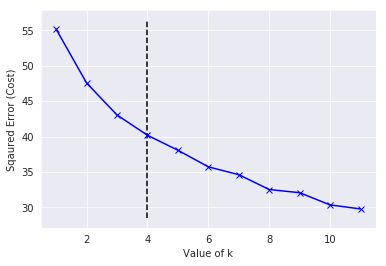

In [281]:
# cluster dataset
newyork_grouped_ns_clustering = newyork_grouped_ns.drop('Neighborhood', 1)

cost =[] 
for i in range(1, 12): 
    KM = KMeans(n_clusters = i, random_state=0) 
    KM.fit(newyork_grouped_ns_clustering)       
    cost.append(KM.inertia_)  
    
print("Sqaured Error (Cost)", cost)
  
k = range(1, len(cost)+1)

from kneed import KneeLocator
kn = KneeLocator(k, cost, curve='convex', direction='decreasing')
n_ns_knee = kn.knee
print("Elbow Point", n_ns_knee)
plt.xlabel('Value of k')
plt.ylabel('Sqaured Error (Cost)')
plt.plot(k, cost, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [282]:
"As the Elbow Point turns out to be {}, we'll run *k*-means to cluster the neighborhood into {} clusters".format(n_ns_knee, n_ns_knee)

"As the Elbow Point turns out to be 4, we'll run *k*-means to cluster the neighborhood into 4 clusters"

In [283]:
# set number of clusters
kclusters = n_ns_knee

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_ns_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 3, 1, 1, 0, 3, 3, 3, 3], dtype=int32)

In [284]:
# drop clustering labels if already inserted
# newyork_neighborhoods_ns_venues_sorted = newyork_neighborhoods_ns_venues_sorted.drop('Cluster Labels', axis=1)

# add clustering labels
newyork_neighborhoods_ns_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# newyork_neighborhoods_with_no_ns_indices do not have any Nightlife Spot venues 1000 meters around it, so let's drop them.
# execute the following line just once
newyork_merged_ns = df_newyork_neighborhoods.drop(df_newyork_neighborhoods.index[newyork_neighborhoods_with_no_ns_indices])


# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
newyork_merged_ns = newyork_merged_ns.join(newyork_neighborhoods_ns_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

newyork_merged_ns.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201               3   
1   Bronx   Co-op City  40.874294 -73.829939               3   
2   Bronx  Eastchester  40.887556 -73.827806               3   
3   Bronx    Fieldston  40.895437 -73.905643               1   
4   Bronx    Riverdale  40.890834 -73.912585               1   

  1st Most Common Nightlife Spot Venue 2nd Most Common Nightlife Spot Venue  \
0                                  Bar                      Other Nightlife   
1                            Nightclub                                  Bar   
2                                  Bar                           Sports Bar   
3                                  Bar                      Other Nightlife   
4                                  Bar                            Hotel Bar   

  3rd Most Common Nightlife Spot Venue 4th Most Common Nightlife Spot Venue  \
0                           Smoke Shop                               Lounge   
1                       Nightlife Spot                           Sports Bar   
2                         Cocktail Bar                            Nightclub   
3                               Lounge                          Wings Joint   
4                         Cocktail Bar                               Lounge   

  5th Most Common Nightlife Spot Venue 6th Most Common Nightlife Spot Venue  \
0                          Wings Joint                  Fried Chicken Joint   
1                                  Pub                            Gastropub   
2                          Wings Joint                            Gastropub   
3                            Gastropub                  Fried Chicken Joint   
4                       Nightlife Spot                    Food & Drink Shop   

  7th Most Common Nightlife Spot Venue 8th Most Common Nightlife Spot Venue  \
0                    French Restaurant                           Food Truck   
1                  Fried Chicken Joint                    French Restaurant   
2                  Fried Chicken Joint                    French Restaurant   
3                    French Restaurant                           Food Truck   
4                            Gastropub                  Fried Chicken Joint   

  9th Most Common Nightlife Spot Venue 10th Most Common Nightlife Spot Venue  
0                           Food Court                     Food & Drink Shop  
1                           Food Truck                            Food Court  
2                           Food Truck                            Food Court  
3                           Food Court                     Food & Drink Shop  
4                    French Restaurant                            Food Truck

Let's visualize the resulting clusters now.

In [285]:

# create map
map_clusters = folium.Map(location=[newyork_latitude, newyork_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged_ns['Latitude'], newyork_merged_ns['Longitude'], newyork_merged_ns['Neighborhood'], newyork_merged_ns['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label, #map not rendering with popup specified
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [286]:
# Cluster 0
newyork_merged_ns.loc[newyork_merged_ns['Cluster Labels'] == 0, newyork_merged_ns.columns[[1] + list(range(5, newyork_merged_ns.shape[1]))]]

Neighborhood 1st Most Common Nightlife Spot Venue  \
23          Longwood                             Wine Bar   
24       Hunts Point                             Wine Bar   
74          Canarsie                             Wine Bar   
80      Borough Park                             Wine Bar   
177          Arverne                              Brewery   
192       Somerville                              Brewery   
226     Graniteville                              Brewery   
245       Bloomfield                             Wine Bar   
255     Emerson Hill                             Wine Bar   
261  Paerdegat Basin                             Wine Bar   

    2nd Most Common Nightlife Spot Venue 3rd Most Common Nightlife Spot Venue  \
23                             Nightclub                                  Bar   
24                             Nightclub                          Wings Joint   
74                               Brewery                          Wings Joint   
80                             Nightclub                               Lounge   
177                          Wings Joint                    Food & Drink Shop   
192                          Wings Joint                    Food & Drink Shop   
226                             Wine Bar                                  Pub   
245                          Wings Joint                          Event Space   
255                           Sports Bar                            Speakeasy   
261                          Wings Joint                          Event Space   

    4th Most Common Nightlife Spot Venue 5th Most Common Nightlife Spot Venue  \
23                                Lounge                           Sports Bar   
24                     Food & Drink Shop                            Gastropub   
74                     Food & Drink Shop                            Gastropub   
80                          Cocktail Bar                                  Bar   
177                            Gastropub                  Fried Chicken Joint   
192                            Gastropub                  Fried Chicken Joint   
226                                 Café                          Wings Joint   
245                            Gastropub                  Fried Chicken Joint   
255                          Wings Joint                          Event Space   
261                            Gastropub                  Fried Chicken Joint   

    6th Most Common Nightlife Spot Venue 7th Most Common Nightlife Spot Venue  \
23                         Indie Theater                              Brewery   
24                   Fried Chicken Joint                    French Restaurant   
74                   Fried Chicken Joint                    French Restaurant   
80                            Sports Bar                             Dive Bar   
177                    French Restaurant                           Food Truck   
192                    French Restaurant                           Food Truck   
226                    Food & Drink Shop                  Fried Chicken Joint   
245                    French Restaurant                           Food Truck   
255                    French Restaurant                           Food Truck   
261                    French Restaurant                           Food Truck   

    8th Most Common Nightlife Spot Venue 9th Most Common Nightlife Spot Venue  \
23                            Food Court                            Gastropub   
24                            Food Truck                           Food Court   
74                            Food Truck                           Food Court   
80           Eastern European Restaurant                   English Restaurant   
177                           Food Court                          Event Space   
192                           Food Court                          Event Space   
226                    French Restaurant                           Food Truck   
245         

In [287]:
# Cluster 1
newyork_merged_ns.loc[newyork_merged_ns['Cluster Labels'] == 1, newyork_merged_ns.columns[[1] + list(range(5, newyork_merged_ns.shape[1]))]]

Neighborhood 1st Most Common Nightlife Spot Venue  \
3              Fieldston                                  Bar   
4              Riverdale                                  Bar   
5            Kingsbridge                                  Bar   
10            Baychester                                  Bar   
14    University Heights                                  Bar   
15        Morris Heights                                  Bar   
20               Melrose                                  Bar   
30           Parkchester                                  Bar   
31    Westchester Square                                  Bar   
32              Van Nest                                  Bar   
33           Morris Park                                  Bar   
34               Belmont                                  Bar   
36       North Riverdale                                  Bar   
39        Edgewater Park                                  Bar   
40           Castle Hill                                  Bar   
42        Pelham Gardens                                  Bar   
44             Unionport                                  Bar   
45              Edenwald                                  Bar   
48           Sunset Park                                  Bar   
58       Windsor Terrace                                  Bar   
62              Bushwick                                  Bar   
63    Bedford Stuyvesant                                  Bar   
72         East New York                                  Bar   
81         Dyker Heights                                  Bar   
82       Gerritsen Beach                                  Bar   
83           Marine Park                                  Bar   
94            Georgetown                                  Bar   
124     Manhattan Valley                                  Bar   
130             Woodside                                  Bar   
133         Howard Beach                                  Bar   
140            Sunnyside                                  Bar   
143            Ridgewood                                  Bar   
144             Glendale                          Beer Garden   
147           Ozone Park                                  Bar   
148     South Ozone Park                                  Bar   
150           Whitestone                                  Bar   
156            Bellerose                                  Bar   
157    Kew Gardens Hills                                  Bar   
159            Briarwood                                  Bar   
160       Jamaica Center                                  Bar   
161      Oakland Gardens                                  Bar   
163               Hollis                                  Bar   
172         Breezy Point                                  Bar   
174           Beechhurst                                  Bar   
179             Neponsit                                  Bar   
182           Holliswood                                  Bar   
183      Jamaica Estates                                  Bar   
184      Queensboro Hill                                  Bar   
187           Lindenwood                                  Bar   
191        Rockaway Park                                  Bar   
199            Stapleton                                  Bar   
200             Rosebank                                  Bar   
201        West Brighton                                  Bar   
205        Port Richmond                                  Bar   
207           Port Ivory                                  Bar   
210               Travis                                  Bar   
212              Oakwood                       Nightlife Spot   
213          Great Kills                                  Bar   
216              Woodrow                                  Bar   
220            Sunnyside                                  Bar   
224            Park Hill                       

In [288]:
# Cluster 2
newyork_merged_ns.loc[newyork_merged_ns['Cluster Labels'] == 2, newyork_merged_ns.columns[[1] + list(range(5, newyork_merged_ns.shape[1]))]]

Neighborhood 1st Most Common Nightlife Spot Venue  \
11      Pelham Parkway                                  Bar   
17        East Tremont                               Lounge   
18          West Farms                               Lounge   
19        High  Bridge                               Lounge   
22         Port Morris                               Lounge   
26           Soundview                       Nightlife Spot   
27        Clason Point                               Lounge   
43           Concourse                           Sports Bar   
50           Gravesend                               Lounge   
53   Manhattan Terrace                               Lounge   
56       East Flatbush                               Lounge   
60         Brownsville                               Lounge   
75           Flatlands                               Lounge   
90           City Line                               Lounge   
98       Ocean Parkway                               Lounge   
102             Inwood                               Lounge   
166           Rochdale                               Lounge   
168    Cambria Heights                       Nightlife Spot   
185          Hillcrest                               Lounge   
188          Laurelton                               Lounge   
193         Brookville                               Lounge   
222            Wingate                            Nightclub   
223              Rugby                               Lounge   
238       Butler Manor                                  Bar   
239         Charleston                               Lounge   
257       Howland Hook                               Lounge   
259     Remsen Village                               Lounge   
270         Mount Hope                            Nightclub   
289          Homecrest                               Lounge   
300            Erasmus                               Lounge   

    2nd Most Common Nightlife Spot Venue 3rd Most Common Nightlife Spot Venue  \
11                                Lounge                          Wings Joint   
17                            Smoke Shop                          Wings Joint   
18                            Smoke Shop                            Nightclub   
19                                   Bar                           Sports Bar   
22                                   Bar                            Nightclub   
26                                   Bar                               Lounge   
27                           Wings Joint                          Event Space   
43                                Lounge                           Restaurant   
50                                   Bar                          Music Venue   
53                             Nightclub                General Entertainment   
56                             Nightclub                 Caribbean Restaurant   
60                            Sports Bar                       Nightlife Spot   
75                             Nightclub                                  Bar   
90                             Nightclub                           Sports Bar   
98                              Sake Bar                            Nightclub   
102                             Wine Bar                                  Bar   
166                                  Pub                            BBQ Joint   
168                                  Bar                               Lounge   
185                          Karaoke Bar                            Nightclub   
188                                  Bar                            Gastropub   
193                       Nightlife Spot                          Wings Joint   
222                               Lounge                             Wine Bar   
223                            Speakeasy                             Sake Bar   
238                               Lounge                          Wings Joint   
239                            

In [289]:
# Cluster 3
newyork_merged_ns.loc[newyork_merged_ns['Cluster Labels'] == 3, newyork_merged_ns.columns[[1] + list(range(5, newyork_merged_ns.shape[1]))]]

Neighborhood 1st Most Common Nightlife Spot Venue  \
0                    Wakefield                                  Bar   
1                   Co-op City                            Nightclub   
2                  Eastchester                                  Bar   
6                  Marble Hill                                  Bar   
7                     Woodlawn                                  Pub   
8                      Norwood                                  Bar   
9               Williamsbridge                                  Bar   
12                 City Island                  American Restaurant   
13                Bedford Park                 Caribbean Restaurant   
16                     Fordham                                  Bar   
21                  Mott Haven                            Bookstore   
25                  Morrisania                               Lounge   
28                 Throgs Neck                                  Bar   
29                Country Club                             Dive Bar   
35              Spuyten Duyvil                       Nightlife Spot   
37                  Pelham Bay                             Dive Bar   
38               Schuylerville                                  Bar   
41                   Olinville                                  Bar   
46                   Bay Ridge                                  Bar   
47                 Bensonhurst                          Karaoke Bar   
49                  Greenpoint                                  Bar   
51              Brighton Beach                          Karaoke Bar   
52              Sheepshead Bay                                  Bar   
54                    Flatbush                                  Bar   
55               Crown Heights                                  Bar   
57                  Kensington                  American Restaurant   
59            Prospect Heights                                  Bar   
61                Williamsburg                                  Bar   
64            Brooklyn Heights                                  Bar   
65                 Cobble Hill                                  Bar   
66             Carroll Gardens                                  Bar   
67                    Red Hook                                  Bar   
68                     Gowanus                                  Bar   
69                 Fort Greene                                  Bar   
70                  Park Slope                                  Bar   
71               Cypress Hills                               Lounge   
73               Starrett City                   Seafood Restaurant   
77             Manhattan Beach                                  Bar   
78                Coney Island                                  Bar   
79                  Bath Beach                          Karaoke Bar   
84                Clinton Hill                                  Bar   
85                    Sea Gate                            Gastropub   
86                    Downtown                                  Bar   
87                 Boerum Hill                                  Bar   
88   Prospect Lefferts Gardens                            Nightclub   
89                  Ocean Hill                                  Bar   
91                Bergen Beach                       Nightlife Spot   
92                     Midwood                          Karaoke Bar   
93         Prospect Park South                                  Bar   
95           East Williamsburg                                  Bar   
96                  North Side                                  Bar   
97                  South Side                                  Bar   
99               Fort Hamilton                                  Bar   
100                  Chinatown                         Cocktail Bar   
101         Washington Heights                                  Bar   
103           Hamilton Heights            

##### 3.3.TN Count Comparision of Nightlife Spot Venue Categories between Toronto and New York City

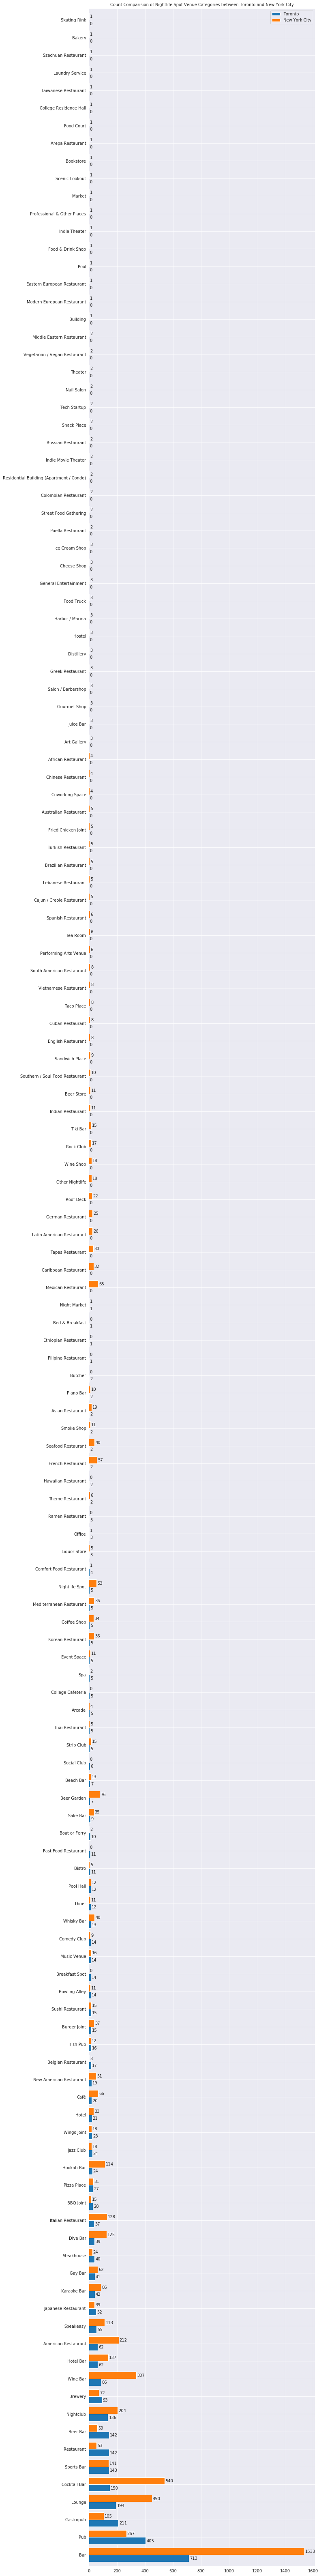

In [290]:
# creating dataframe of Toronto Nightlife Spot Venue Categories and their counts
ds_toronto_ns_count = toronto_venues_ns['Venue Category'].value_counts()
df_toronto_ns_count = pd.DataFrame(ds_toronto_ns_count).reset_index()
df_toronto_ns_count.columns = ['Venue Category', 'Toronto']

# creating dataframe of New York City Nightlife Spot Venue Categories and their counts
ds_newyork_ns_count = newyork_venues_ns['Venue Category'].value_counts()
df_newyork_ns_count = pd.DataFrame(ds_newyork_ns_count).reset_index()
df_newyork_ns_count.columns = ['Venue Category', 'New York City']

# creating a full outer join of the above two dataframes
df_ns_tn_outer = pd.merge(df_toronto_ns_count, df_newyork_ns_count, on='Venue Category', how='outer')
df_ns_tn_outer['Toronto'] = df_ns_tn_outer['Toronto'].replace(np.nan, 0)
df_ns_tn_outer['New York City'] = df_ns_tn_outer['New York City'].replace(np.nan, 0)
df_ns_tn_outer = df_ns_tn_outer.astype({"Toronto": int, "New York City": int})
df_ns_tn_outer.rename(columns={'Venue Category': 'Nightlife Spot Venue Category'}, inplace=True)

# creating a grouped bar plot
ax_ns = df_ns_tn_outer.plot(kind='barh', x='Nightlife Spot Venue Category', figsize=(10, 116), width=.8)
ax_ns.set_title('Count Comparision of Nightlife Spot Venue Categories between Toronto and New York City', fontsize='medium')
for p in ax_ns.patches:
    ax_ns.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()),
                xytext=(2, 5), textcoords='offset points', fontsize=10)

ax_ns.set_ylabel("")
ax_ns.get_figure().savefig('df_ns_tn_outer_all.png', bbox_inches = 'tight')

### 4. Results<a name="results"></a>

This results section provides an overview of some of the outcomes of the methodology and their relevance to the similarities and dissimilarities between Toronto and New York City on Food, Arts & Entertainment and Nightlife.

We’ll start with the 3 example questions we had mentioned [1.1 Business Problem](#business_problem) section of this report.

**1 - How frequent Japanese Restaurants are in the neighborhoods of Toronto as compared to New York City?**

The total count of ‘Japanese Restaurant’ in Toronto is 225, while its count in the New York City is 322. Also, ‘Japanese Restaurant’ also falls in the 5th place (with a count of 14) in the 2nd  most commonly found Food venues in Toronto, but it is not found in the first 4 most commonly found Food venues in New York City. So ‘Japanese Restaurant’ is more commonly found in Toronto than in New York City. 

But overall, it could be said that New York City and Toronto are more similar to each other than dissimilar as both have a lot of ‘Japanese Restaurant’ venues in them.

**2 - If Museums play an important role in deciding which place to tour, then should you choose Toronto or New York City?**

New York City has 129 ‘Museum’ venues while Toronto has 39 of them. There are actually various sub-categories of ‘Museum’ in both Toronto and New York City. These are ‘History Museum’, ‘Art Museum’, ‘Science Museum’ and also ‘Erotic Museum’.

In New York City, ‘Erotic Museum’ is the 3rd and 4th most common Arts and Entertainment venue with a count of 35 and 41. It has a presence of ‘Museum’ and ‘History Museum’ venues as well in the 1st and 2nd most common venues.

Just like New York City, Toronto also a presence of ‘History Museum’, ‘Museum’ and ‘Art Museum’ in 1st, 2nd, 3rd and 4th most common venues of Arts and Entertainment.

So, New York City and Toronto are similar to each when it comes to ‘Museum’, ‘History Museum’, ‘Art Museum’ and ‘Science Museum’ venues, but dissimilar when it comes to ‘Erotic Museum’ as Toronto does not have any ‘Erotic Museum’ venues in it.

So people interested in only ‘Erotic Museum’ category of museums might feel a bit disappointed in Toronto as compared to New York City.


**3 - If Art Gallaries are your favourite place to explore in your free time, would it matter much if you choose to visit New York City rather than Toronto?**

Toronto has 450 ‘Art Gallery’ venues while New York City has 1418 of them. ‘Art Gallery’ venues is the 1st most common Arts and Entertainment venue in both Toronto and New York City. ‘Downtown Toronto’ in Toronto has the highest count of 246 ‘Art Gallery’ venues while ‘Manhattan’ in New York City has a total 809 of them. 

Both the cities have a lot of ‘Art Gallery’ venues, so it could be easily said that Toronto and New York City are quite similar to each other when it comes to ‘Art Gallery’ venues.

So, it doesn’t matter much which city is chosen for a visit or tour as both the cities have many of ‘Art Gallery’ venues in them.

____

For all the 3 categories, the easiest way to find the dissimilarities between Toronto and New York City is to find the venue categories in Toronto that are not found in New York City and vice-versa. So we explored the venue categories in both the cities and found the following dissimilarities and similarities:

***I.  Dissimilarities between Toronto and New York City***

**I.A Food Category**

One of the major dissimilarity between Toronto and New York was that Toronto had 28 of ‘Poutine Place’ venues while New York City had none of them. Toronto had a total of 6 food venue categories were not found in New York City.

On the other hand, New York City was found to have 61 of ‘Peruvian Restaurant’, 28 of ‘Russian Restaurant’ and 26 of ‘Argentinian Restaurant’ as the top 3 out of 39 food venue categories that were not found in Toronto.

Another major dissimilarity between NYC and Toronto is regarding ‘Deli / Bodega’, which has the second highest venue count in NYC. NYC had 1426 of them while Toronto had just 128 of them.

**I.B Arts & Entertainment Category**

With Arts & Entertainment, Toronto was dissimilar to New York City with just 1 venue category. It was Racecourse. Toronto had 4 of them, while New York City had none.

One of the other hand, the one major dissimilarity between New York City and Toronto was caused by ‘Memorial Site’ venues. New York City had 34 of them while Toronto had none. Also, New York City also had 4 ‘Erotic Museum’ venues while Toronto had none. Toronto also didn’t have any ‘Science Museum’ and ‘Planetarium’ was NYC had 19 and 5 of them.

Although in our data exploration, we got to know that Toronto had no ‘Memorial Site’ venues, this page from Wikipedia told us otherwise as it showed us that Toronto in-fact had many war ‘Mamorial Site’ venues.

**I.C Nightlife Spot Category**

Nightlife Spot venues get even more interesting when Toronto has 14 of ‘Breakfast Spot’ venues while NYC has none. Also, there are no ‘Ramen Restaurant’, ‘Hawaiian Restaurant’, ‘Ethiopian Restaurant’ and ‘Filipino Restaurant’ venues that are open as a Nightlife Spot type venues in NYC. A total of 10 categories of these venues are not found in NYC to make it dissimilar to Toronto.

On the other hand, NYC has a total of 39 Nightlife Spot venue categories that are not found in Toronto. Almost all of them are restaurants. 65 of ‘Mexican Restaurant’ to 6 of ‘Spanish Restaurant’, while there are 16 of ‘Rock Club’ and 6 of ‘Performing Arts Venue’ as well.


***II.  Similarities between Toronto and New York City***

**II.A Food Category**

5 of the first 10 Food venue categories by count in both Toronto and NYC are common. These include, ‘Pizza Place’, ‘Café’, ‘Italian Restaurant’, ‘Bakery’ and ‘Sandwich Place’.
They’re all high in numbers. It is a good indication that Based on Food venue categories, Toronto and NYC are more similar than others.

Out of first 4, 2 of the Food venue categories by count are common in Toronto and NYC. These are, ‘Pizza Place’ and ‘Italian Restaurant’. 

In face the 1st most common Food venue in both Toronto and NYC is ‘Pizza Place’. Just like ‘Café’ is almost the 1st most common Food venue in Toronto, ‘Deli / Bodega’ is also frequently found in NYC.

The first 4 Food venue categories by count in Toronto are, ‘Café’, ‘Pizza Place’, ‘Restaurant’ and ‘Italian Restaurant’. For NYC, these are, ‘Pizza Place’, ‘Deli / Bodega’, ‘Chinese Restaurant’ and ‘Italian Restaurant’.

When comparing the counts of all the Food venue category between Toronto and New York City, it could be easily seen that Toronto and NYC are more similar to NYC than dissimilar.


**II.B Arts & Entertainment Category**

Just like Food, when it comes to Arts & Entertainment, both Toronto and NYC has 3 out of 4 venues in common based on their counts. These are ‘Art Gallery’, ‘Theater’ and ‘Music venue’.

If this wasn’t enough to reflect how similar they are, out of first 10 by count, 7 of venues are common, and if you consider ‘Indie Movie Theater’ and ‘Indie Theater’ same, then it make 8 out of first 10 venue categories to be common between the 2 cities.

These common venue categories are, ‘Art Gallery’, ‘Movie Theater’, ‘Music Venue’, ‘Theater’, ‘Dance Studio’, ‘Performing Arts Venue’ and ‘History Museum.’

When it comes to first 4 most commonly found venues in Toronto, these include, ‘Art Gallery’, ‘Music Venue’, ‘Tour Provider’ and ‘Jazz Club’. For NYC, these are, ‘Art Gallery’, ‘Music Venue’, ‘Erotic Venue’ and even on the 4th position as well we have ‘Erotic Venue’.  

**II.C Nightlife Spot Category**

When it comes to Nightlife Spot both NYC and Toronto are very similar. They’re full of ‘Bar’, ‘Pub’, ‘Lounge’, ‘Nightclub’ and different kind of restaurant venues.

Out of first 10 by count, 5 of venues are common between the 2 cities.


These common venue categories are, ‘Bar, ‘Pub’, ‘Lounge’, ‘Cocktail Bar’, ‘Sports Bar’, and ‘Nightclub’.

Out of first 4 common venues, ‘Bar’ and ‘Pub’ are the 1st and 2nd most common Nightlife Spot venues in both Toronto, while in NYC, these are ‘Bar’ and ‘Lounge’. 


### 5. Discussions <a name="discussions"></a>

The Results presented above describe how the analyses performed above lead to various insights about various venue categories. This section summarizes the decision factors that could lead to those insights and some of its limitations.

1 - One of the limitation of the data provided by Foursquare Place API is that it returns a maximum of 100 venues for an explore endpoint API call that we used in our project for all the 3 categories. This was the reason why many neighborhoods in Toronto were showing 100 as the maximum value for venues of a particular category within a circle of 1000 meters of radius.


But for New York City and Food venue categories it returned 200, 115 and 105 for ‘Murray Hill’, ‘Chelsea’ and ‘Sunny Side’. 

This was due to the fact out of 306 neighborhoods in New York City, 4 of them were duplicates.

In [291]:
# 4 duplicate neighborhoods in NYC dataset
df_newyork_neighborhoods[df_newyork_neighborhoods.duplicated(['Neighborhood'], keep=False)]

Borough Neighborhood   Latitude  Longitude
115      Manhattan  Murray Hill  40.748303 -73.978332
116      Manhattan      Chelsea  40.744035 -74.003116
140         Queens    Sunnyside  40.740176 -73.926916
175         Queens  Bay Terrace  40.782843 -73.776802
180         Queens  Murray Hill  40.764126 -73.812763
220  Staten Island    Sunnyside  40.612760 -74.097126
235  Staten Island  Bay Terrace  40.553988 -74.139166
244  Staten Island      Chelsea  40.594726 -74.189560

As we can see from above table that all the 4 duplicate neighborhoods (‘Murray Hill’, ‘Chelsea’, ‘Sunnyside’, ‘Bay Terrace’) are found in two different boroughs. It means that 4 neighborhoods of the same name are found in 2 different boroughs. But they all have different (Latitude, Longitude) values.
According to Wikipedia at https://en.wikipedia.org/wiki/Murray_Hill, ‘Murray Hill’ neighborhood is not only found in Manhattan and Queens, but a few other places as well. So we kept ‘Murray Hill’ and other 3 neighborhoods in the dataset used for our exploratory analysis.
So it looks like, that because ‘Murray Hill’, ‘Chelsea’ and ‘Sunny Side’ were found in two boroughs, the sum of food venues from two boroughs got added up and resulted in a value above 100.

2 - It is important to note is the setting of the radius used in the analysis. As we keep increasing the radius a neighbourhood might start overlapping with its neighbour neighbourhood resulting in an increase in the total number of venues in a neighbourhood. The default setting by Foursquare is a radius of 250 meters, but that seemed a little undervalued for a neighborhood in our analysis so we increased it to 1000 meters. 

3 - We have a 'Restaurant' Venue Category who is among the 2nd, 3rd and 4th most common food venues with a total count of 397 in Toronto. It seems to be a generic restaurant where most of the different kinds of cuisines are served.

4 - While exploring data to find the dissimilarities between Toronto and NYC, it turned out that Toronto didn’t have any ‘Memorial Site’ venues. We were quite surprised just with the thought of it. So we did a web search, and it didn’t take much time to find out that Toronto had in-fact many war ‘Memorial Site’ venues, according to this Wikipedia page. The two reasons behind this discrepancy that immediately come to mind are, either Foursquare Place API does not have enough data, or the value of radius 1000 meters chosen for gathering data missed all of those ‘Memorial Site’ venues. 

5 - The exact number of venues for a neighbourhood is next to impossible to find as radius is going to be fixed when gathering data regardless of the population densities of the neighborhoods in Toronto or NYC.

6 - For all the 3 categories we had neighborhoods that did not have any venues of any of the venue categories. For example, Toronto had 20 neighborhoods that did not have any Arts & Entertainment venues. This number is likely to go down if the radius setting is increased. In some cases, it might be genuine as there is a possibility that Foursquare explore API call missed a venue which was indeed available in a neighbourhood due to selection of short radius, but there is also a possibility that a neighbourhood indeed did not have venue and the radius was increased it overlapped with its neighbour neighbourhood and picked a venue from its neighbour neighbourhood. Hence, the selection of radius is very important.

7 - There was a clear conflict in the data that came to the fore during the data exploration. It was about the number of ‘Erotic Museum’ venues in NYC. When we compared the counts of them Totonto and NYC, Tonrot had 0 and NYC had 4. But when we analysed our neighborhoods to find the first 4 most commonly found venues, in NYC ‘Erotic Museum’ was on the first position in count for the the 3rd and 4th most common venues. The count of ‘Erotic Museum’ venues was 41 for the 4th most common ‘Art & Entertainment’ category. How could this be possible if NYC had a count of just 4 ‘Erotic Museum’ venues?

### 6. Conclusion <a name="conclusion"></a>

This project along with this Notebook comes with serves as a reference to identify the similarities and dissimilarities between Toronto and New York City on Food, Arts & Entertainment and Nightlife. It can be extended to include data from many other categories provided in the Foursquare Places API.

As expected, more venue categories are found in NYC than Toronto. This could be attributed to the fact that people from all walks of life from different countries have been coming to US for a better life, so from the culture’s perspective it is more diverse than Toronto.

Data provided by the Foursquare is not perfect and needs to be worked upon. For example, In ‘Food’ category there is a venue category called ‘Food’. It is not clear what type of Food is served here, but NYC has 241 of these while Toronto has 12. Many such venue categories are found in the datasets provided by Foursquare for all the 3 categories explored in this project that need to be made better sense of.


### 7. Future Directions <a name="future"></a>

The preceding discussions have highlighted, in addition to factors and insights resulting from the data analysis, other factors beyond the scope of this project at this point.

1 - It would be interesting to gather, explore data and analyse it with a different setting of radius and try to find difference in the outcomes compared this project.


2 - If findings of this project could be supplemented with the dataset from a Food ordering web portal, zomato for example, it would add additional value to this project and its outcomes.

3 - Incorporating population density of each neighbourhoods can aid the accuracy, additional analysis and visualization to complement this project.
